# **Предсказание рисков сердечного приступа**

Ссылка на проект в GitHub:  
https://github.com/Irina147/heart-attack-predictor

**Описание проекта:**

В данном проекте необходимо разработать модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови, а также реализовать приложение на FastAPI для получения предсказаний по пользовательскому запросу.  
Предполагается работа с датасетом из открытого источника.

**Цель проекта:**

Разработать модель машинного обучения для предсказания риска сердечного приступа, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

**Этапы проекта:**

- Загрузка и исследование датасета, поиск дополнительной информации для лучшего понимания природы данных
- Предобработка данных
- Исследовательский анализ данных
- Обучение моделей и выбор лучшей модели и ее параметров
- Предсказания на тестовой выборке 
- Написание инструмента для тестирования на FastAPI
- Оформление документации

**Описание данных**  

Файлы heart_train.csv и heart_test.csv содержат данные пациентов для предсказания риска сердечных приступов:

Антропометрические параметры (возраст, ИМТ);
Привычки (курение, алкогольная зависимость, физическая активность, качество сна, диета и т.п.);
Медицинские показатели (давление, уровень холестерина, триглицериды, пульс );
Наличие хронических заболеваний (диабет, ожирение, сердечные заболевания, наличие проблем с сердцем у родственников, применение медикаментов);
Биохимия крови (уровень сахара в крови, ck-mb(уровень фермента для диагностики и мониторинга повреждения сердечной мышцы, особенно при подозрении на инфаркт миокарда), тропонин (белок, повышенный уровень которого указывает на повреждение сердечной мышцы));
Уровень стресса;
Таргет - высокий или низкий риск сердечного приступа.  


<u>Описание признаков для модели<u>

*Демографические и социальные признаки*

Age (Возраст) — количество полных лет пациента  
Gender (Пол) — мужской/женский  
Income (Доход) — уровень финансового благосостояния  
id (Идентификатор) — уникальный номер записи    

*Антропометрические показатели*

BMI (Индекс массы тела) — соотношение веса и роста  
Obesity (Ожирение) — наличие/отсутствие ожирения  

*Физиологические показатели*

Cholesterol (Холестерин) — уровень холестерина в крови  
Triglycerides (Триглицериды) — уровень триглицеридов в крови  
Blood sugar (Уровень сахара) — концентрация глюкозы в крови  
Systolic blood pressure (Систолическое давление) — верхнее давление  
Diastolic blood pressure (Диастолическое давление) — нижнее давление  
Heart rate (Пульс) — частота сердечных сокращений  
CK-MB — маркер повреждения сердечной мышцы  
Troponin — белок, показатель повреждения миокарда    

*Образ жизни, привычки*

Smoking (Курение) — наличие/отсутствие привычки к курению  
Alcohol Consumption (Употребление алкоголя) — частота и количество употребления  
Exercise Hours Per Week (Часы физических упражнений в неделю)  
Physical Activity Days Per Week (Дни физической активности в неделю)  
Diet (Питание) — тип и качество питания  
Stress Level (Уровень стресса) — субъективная оценка стресса    
Sedentary Hours Per Day (Часы малоподвижности в день) — время, проведенное в сидячем положении  
Sleep Hours Per Day (Часы сна в день) — продолжительность ночного сна   

*Медицинские показатели и анамнез*

Diabetes (Диабет) — наличие/отсутствие диабета  
Family History (Семейный анамнез) — наличие сердечно-сосудистых заболеваний у родственников  
Previous Heart Problems (Предыдущие проблемы с сердцем) — наличие сердечно-сосудистых заболеваний в анамнезе  
Medication Use (Прием лекарств) — использование медикаментов  
Heart Attack Risk (Binary) (Риск инфаркта, бинарный) — целевая переменная, указывающая на риск инфаркта    

Взаимосвязи признаков

BMI тесно связан с Obesity  
Exercise Hours Per Week и Physical Activity Days Per Week связаны между собой и с Sedentary Hours Per Day  
Medication Use часто связана с Diabetes, Previous Heart Problems

## 1. Загрузка и изучение данных

Импортируем необходимые библиотеки, зададим настройки и константы.

In [1]:
#!pip install -q -U scikit-learn==1.5.2
#!pip install -q shap
#!pip install -q optuna
#!pip install -q optuna-integration
!pip install phik -q
#!pip install -q imbalanced-learn
!pip install catboost -q

In [2]:
try:
    import phik
    print("Библиотека успешно установлена!")
except ImportError as e:
    print("Ошибка установки:", e)

Библиотека успешно установлена!


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import joblib
import pickle
#import sklearn
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn import tree
from sklearn.impute import SimpleImputer#, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (roc_auc_score,
                             classification_report,
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    OneHotEncoder,
    LabelEncoder, 
    OrdinalEncoder)
from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from scipy.stats import randint, uniform


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')
#sns.set_style('whitegrid')

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загружаем данные из файлов
`heart_train.csv` и `heart_test.csv`

In [4]:
folder_path = r'C:\Datasets'
file_names = ['heart_train.csv', 'heart_test.csv']

dataframes = {}

for file in file_names:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        df_name = file.replace('.csv', '')  
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Файл {file} успешно загружен")
    else:
        print(f"Файл {file} не найден по пути: {file_path}")

Файл heart_train.csv успешно загружен
Файл heart_test.csv успешно загружен


In [5]:
heart_train = dataframes['heart_train']
heart_test = dataframes['heart_test']

In [6]:
def info (df):
    display(df.head(10))
    display(df.info()) 

<u>Файл `heart_train`<u>

In [7]:
# Смотрим файл `heart_train` и общую информацию по нему
info(heart_train)

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   
3           3  0.730337     0.007143    0.053162       0.0             0.0   
4           4  0.775281     0.757143    0.021998       0.0             0.0   
5           5  0.168539     0.764286    0.057745       0.0             1.0   
6           6  0.483146     0.021429    0.036664       1.0             0.0   
7           7  0.235955     0.939286    0.081577       1.0             0.0   
8           8  0.685393     0.317857    0.039413       0.0             0.0   
9           9  0.213483     0.796429    0.076994       1.0             1.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0      1.0                  1.0                 0.535505     1   
1      0.0      0.0                  1.0                 0.068690     2   
2      1.0      1.0                  1.0                 0.944001     2   
3      1.0      0.0                  1.0                 0.697023     0   
4      1.0      0.0                  1.0                 0.412878     1   
5      1.0      1.0                  1.0                 0.082682     1   
6      1.0      0.0                  1.0                 0.540206     2   
7      1.0      0.0                  1.0                 0.290837     2   
8      1.0      0.0                  0.0                 0.803160     0   
9      1.0      1.0                  0.0                 0.506971     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   
5                      1.0             0.0           7.0   
6                      0.0             1.0           9.0   
7                      0.0             1.0           7.0   
8                      1.0             1.0           3.0   
9                      0.0             0.0           7.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   
5                 0.558262  0.640836  0.110571       0.238961   
6                 0.827611  0.774609  0.073718       0.072727   
7                 0.225275  0.999364  0.001534       0.180519   
8                 0.828176  0.142208  0.093073       0.990909   
9                 0.692973  0.820952  0.145447       0.171429   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   
5                              6.0             0.833333   
6                              5.0             0.000000   
7                              4.0             0.000000   
8                              6.0             0.166667   
9                              3.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Femal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

Датафрейм `heart_train` состоит из 8685 строк и 28 столбцов, в которых представлены следующие данные о пациентах:

- демографические параметры ('Age', 'Gender', 'Income');  
- антропометрические параметры ('BMI', 'Obesity');  
- образ жизни, привычки ('Smoking', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Sedentary Hours Per Day', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Stress Level ');  
- физиологические показатели ('Cholesterol', 'Triglycerides', 'Blood sugar', 'Systolic blood pressure', 'Diastolic blood pressure', 'Heart rate', 'CK-MB', 'Troponin');  
- медицинские показатели и анамнез ('Diabetes', 'Family History', 'Previous Heart Problems', 'Medication Use');  
и целевой признак - высокий или низкий риск поражения сердца ('Heart Attack Risk (Binary)').

В датафрейме находятся данные с типами object, int64 и float64.   

Видим, что количественные признаки масштабированы. 

В датасете также есть категориальные признаки, в т.ч. бинарные.

Общее количество индексов в таблице составляет 8685, в столбцах 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems','Medication Use', 'Stress Level' и 'Physical Activity Days Per Week' их количество составляет 8442, поэтому предположим, что в этих столбцах есть пропуски, остальные же столбцы не содержат пропусков.  


Файл `heart_test`

In [8]:
# Смотрим файл `heart_test` и общую информацию по нему
info(heart_test)

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   
3           3  0.460674     0.567857    0.055912       1.0             1.0   
4           4  0.719101     0.485714    0.022915       1.0             0.0   
5           5  0.561798     0.792857    0.026581       1.0             1.0   
6           6  0.674157     0.853571    0.019248       1.0             1.0   
7           7  0.539326     0.335714    0.036664       1.0             1.0   
8           8  0.449438     0.328571    0.075160       1.0             0.0   
9           9  0.617978     0.728571    0.032081       0.0             1.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0      1.0                  1.0                 0.361618     2   
1      0.0      1.0                  0.0                 0.996483     2   
2      1.0      1.0                  0.0                 0.995561     0   
3      1.0      1.0                  1.0                 0.437277     0   
4      1.0      0.0                  1.0                 0.514920     0   
5      1.0      1.0                  0.0                 0.774470     2   
6      1.0      0.0                  1.0                 0.149123     1   
7      1.0      0.0                  1.0                 0.329720     1   
8      1.0      0.0                  0.0                 0.487405     2   
9      1.0      0.0                  0.0                 0.211485     2   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   
5                      0.0             1.0           8.0   
6                      0.0             0.0           8.0   
7                      1.0             0.0           1.0   
8                      1.0             0.0          10.0   
9                      1.0             1.0           8.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.194370  0.587759  0.283490       0.306494   
1                 0.329888  0.602883  0.467036       0.087013   
2                 0.780075  0.370436  0.409366       0.205195   
3                 0.785071  0.368242  0.910261       0.163636   
4                 0.070919  0.729578  0.758924       0.580519   
5                 0.044114  0.813517  0.723416       0.362338   
6                 0.305998  0.562542  0.696128       0.211688   
7                 0.377016  0.235091  0.484368       0.835065   
8                 0.089371  0.486634  0.409407       0.819481   
9                 0.524318  0.083936  0.657387       0.196104   

   Physical Activity Days Per Week  Sleep Hours Per Day  Blood sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   
5                              1.0             0.666667     0.227018   
6                              3.0             0.000000     0.227018   
7                              7.0             0.666667     0.695652   
8                              2.0             0.166667     0.227018   
9                              0.0             1.000000     0.227018   

      CK-MB  Troponin  Gender  Systolic blood pressure  \
0  0.048229  0.036512    Male                 0.283871   
1  0.048229  0.036512  Female   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

None

Датафрейм `heart_test` состоит из 966 строк и 27 столбцов, в которых представлены такие же данные о пациентах, как и в датафрейме `heart_train`, за исключением целевого признака.  

В датафрейме находятся данные с типами object, int64 и float64.   

Видим, что количественные признаки как и в первом датафрейме масштабированы. 

В датасете также есть категориальные признаки, в т.ч. бинарные.

Общее количество индексов в таблице составляет 966, в столбцах 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems','Medication Use', 'Stress Level' и 'Physical Activity Days Per Week' их количество составляет 935, поэтому в данном случае также предположим, что в этих столбцах есть пропуски, остальные же столбцы не содержат пропусков.  

**Выводы после первичного просмотра наборов данных:**

- Для работы были загружены две таблицы.
- Названия стобцов приведем к виду snake_case.
- Предполагаем, что в таблицах есть пропуски. Изучим их в дальнейшем.
- Рассмотрим возможность приведения некоторых столбцов к целочисленному типу данных (int).
- Рассмотрим возможность убрать столбец `Unnamed: 0`, который не представляется нужным для анализа.

## 2. Предобработка данных

### 2.1. Удаление столбца 'Unnamed: 0', приведение наименований столбцов к "змеиному" виду, перемещение столбцов `id` и с целевым признаком в начало, сортировка таблиц по `id` 

Приведем названия столбцов к нижнему регистру и змеиному стилю. Также удалим столбец 'Unnamed: 0', так как в нем дублируются порядковые номера строк и не содержится существенной информации.

In [9]:
def remove(df1, df2):
    df1 = df1.drop(columns=['Unnamed: 0'], errors='ignore')
    df2 = df2.drop(columns=['Unnamed: 0'], errors='ignore')
    return df1, df2

In [10]:
heart_train, heart_test = remove(heart_train, heart_test)

In [11]:
def snake_case(df1, df2):
    df1.columns = df1.columns.str.lower().str.replace(' ', '_') 
    df2.columns = df2.columns.str.lower().str.replace(' ', '_')   
    return df1, df2

In [12]:
heart_train, heart_test = snake_case(heart_train, heart_test)

In [13]:
# Проверим
for с in [heart_train, heart_test]:
    print(с.columns)

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin',
       'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')
Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar',
       'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_

В датафрейме `heart_train` переместим столбец `id` и столбец с целевым признаком в начало датафрейма, чтобы было удобнее.

In [14]:
columns_to_move = ['id', 'heart_attack_risk_(binary)'] 
new_columns = columns_to_move + [col for col in heart_train.columns if col not in columns_to_move]
heart_train = heart_train[new_columns]


In [15]:
heart_train.head()

id  heart_attack_risk_(binary)       age  cholesterol  heart_rate  \
0  2664                         0.0  0.359551     0.732143    0.074244   
1  9287                         0.0  0.202247     0.325000    0.047663   
2  5379                         0.0  0.606742     0.860714    0.055912   
3  8222                         1.0  0.730337     0.007143    0.053162   
4  4047                         1.0  0.775281     0.757143    0.021998   

   diabetes  family_history  smoking  obesity  alcohol_consumption  \
0       1.0             1.0      1.0      1.0                  1.0   
1       1.0             1.0      0.0      0.0                  1.0   
2       1.0             0.0      1.0      1.0                  1.0   
3       0.0             0.0      1.0      0.0                  1.0   
4       0.0             0.0      1.0      0.0                  1.0   

   exercise_hours_per_week  diet  previous_heart_problems  medication_use  \
0                 0.535505     1                      1.0             0.0   
1                 0.068690     2                      1.0             0.0   
2                 0.944001     2                      1.0             1.0   
3                 0.697023     0                      0.0             1.0   
4                 0.412878     1                      0.0             0.0   

   stress_level  sedentary_hours_per_day    income       bmi  triglycerides  \
0           8.0                 0.225704  0.105948  0.459176       0.979221   
1           9.0                 0.289923  0.164217  0.117053       0.515584   
2           6.0                 0.550133  0.598745  0.373574       0.012987   
3           3.0                 0.330962  0.077605  0.049735       0.131169   
4           8.0                 0.524600  0.341960  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              3.0             0.333333     0.227018   
1                              3.0             0.833333     0.150198   
2                              2.0             1.000000     0.227018   
3                              0.0             0.333333     0.227018   
4                              5.0             1.000000     0.227018   

      ck-mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512    Male                 0.212903   
1  0.017616  0.000194  Female                 0.412903   
2  0.048229  0.036512  Female                 0.238710   
3  0.048229  0.036512  Female                 0.348387   
4  0.048229  0.036512    Male                 0.619355   

   diastolic_blood_pressure  
0                  0.709302  
1                  0.569767  
2                  0.220930  
3                  0.267442  
4                  0.441860

В датафрейме `heart_test` переместим столбец `id` в начало датафрейма

In [16]:
column_to_move = 'id' 

heart_test = heart_test[[column_to_move] + [col for col in heart_test.columns if col != column_to_move]]

In [17]:
heart_test.head()

id       age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  7746  0.494382     0.264286    0.062328       0.0             1.0      1.0   
1  4202  0.224719     0.953571    0.082493       1.0             0.0      0.0   
2  6632  0.629213     0.092857    0.064161       0.0             1.0      1.0   
3  4639  0.460674     0.567857    0.055912       1.0             1.0      1.0   
4  4825  0.719101     0.485714    0.022915       1.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.361618     2   
1      1.0                  0.0                 0.996483     2   
2      1.0                  0.0                 0.995561     0   
3      1.0                  1.0                 0.437277     0   
4      0.0                  1.0                 0.514920     0   

   previous_heart_problems  medication_use  stress_level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.194370  0.587759  0.283490       0.306494   
1                 0.329888  0.602883  0.467036       0.087013   
2                 0.780075  0.370436  0.409366       0.205195   
3                 0.785071  0.368242  0.910261       0.163636   
4                 0.070919  0.729578  0.758924       0.580519   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   

      ck-mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512    Male                 0.283871   
1  0.048229  0.036512  Female                 0.703226   
2  0.002666  0.088455    Male                 0.458065   
3  0.056390  0.271774  Female                 0.741935   
4  0.048229  0.036512    Male                 0.412903   

   diastolic_blood_pressure  
0                  0.372093  
1                  0.441860  
2                  0.779070  
3                  0.255814  
4                  0.395349

Отсортируем по `id` обе таблицы

In [18]:
heart_train = heart_train.sort_values(by='id').reset_index(drop=True)
heart_train.head()

id  heart_attack_risk_(binary)       age  cholesterol  heart_rate  \
0   1                         0.0  0.595506     0.096429    0.047663   
1   2                         0.0  0.595506     0.189286    0.047663   
2   4                         0.0  0.078652     0.792857    0.071494   
3   5                         0.0  0.078652     0.771429    0.071494   
4   6                         1.0  0.078652     0.492857    0.071494   

   diabetes  family_history  smoking  obesity  alcohol_consumption  \
0       1.0             1.0      1.0      1.0                  1.0   
1       0.0             0.0      1.0      0.0                  1.0   
2       1.0             0.0      1.0      1.0                  0.0   
3       1.0             1.0      1.0      0.0                  1.0   
4       1.0             0.0      1.0      0.0                  0.0   

   exercise_hours_per_week  diet  previous_heart_problems  medication_use  \
0                 0.752420     1                      0.0             0.0   
1                 0.200998     2                      1.0             1.0   
2                 0.601030     2                      1.0             0.0   
3                 0.658864     2                      1.0             0.0   
4                 0.849607     1                      0.0             0.0   

   stress_level  sedentary_hours_per_day    income       bmi  triglycerides  \
0           3.0                 0.710786  0.825422  0.274469       0.276623   
1           9.0                 0.320478  0.005041  0.890332       0.057143   
2           4.0                 0.315026  0.300191  0.169495       0.768831   
3           2.0                 0.910628  0.146060  0.394175       0.485714   
4           2.0                 0.583318  0.111129  0.834293       0.407792   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              2.0             0.666667     0.227018   
1                              4.0             1.000000     0.227018   
2                              1.0             0.166667     0.227018   
3                              2.0             0.666667     0.227018   
4                              0.0             1.000000     0.227018   

      ck-mb  troponin gender  systolic_blood_pressure  \
0  0.048229  0.036512   Male                 0.574194   
1  0.048229  0.036512   Male                 0.187097   
2  0.048229  0.036512   Male                 0.251613   
3  0.048229  0.036512   Male                 0.735484   
4  0.048229  0.036512   Male                 0.419355   

   diastolic_blood_pressure  
0                  0.569767  
1                  0.674419  
2                  0.383721  
3                  0.383721  
4                  0.720930

In [19]:
heart_test = heart_test.sort_values(by='id').reset_index(drop=True)
heart_test.head()

id       age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0   0  0.595506     0.314286    0.047663       0.0             0.0      1.0   
1   3  0.078652     0.960714    0.071494       1.0             1.0      1.0   
2  10  0.786517     0.375000    0.048579       1.0             1.0      1.0   
3  14  0.584270     0.935714    0.066911       0.0             1.0      1.0   
4  19  0.853933     0.160714    0.058662       0.0             1.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      0.0                  0.0                 0.208326     0   
1      1.0                  1.0                 0.090557     2   
2      1.0                  1.0                 0.173545     1   
3      0.0                  1.0                 0.292691     1   
4      1.0                  0.0                 0.284116     2   

   previous_heart_problems  medication_use  stress_level  \
0                      0.0             0.0           9.0   
1                      1.0             0.0           1.0   
2                      0.0             0.0           4.0   
3                      1.0             1.0           4.0   
4                      0.0             1.0           3.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.551234  0.862268  0.602363       0.332468   
1                 0.413584  0.949316  0.417945       0.266234   
2                 0.572033  0.187454  0.146128       0.971429   
3                 0.495582  0.633684  0.596568       0.279221   
4                 0.910359  0.681431  0.447749       0.297403   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              0.0             0.333333     0.227018   
1                              1.0             0.500000     0.227018   
2                              7.0             0.666667     0.227018   
3                              2.0             0.000000     0.227018   
4                              5.0             0.666667     0.227018   

      ck-mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512    Male                 0.600000   
1  0.048229  0.036512    Male                 0.645161   
2  0.048229  0.036512  Female                 0.593548   
3  0.048229  0.036512    Male                 0.690323   
4  0.048229  0.036512    Male                 0.625806   

   diastolic_blood_pressure  
0                  0.534884  
1                  0.593023  
2                  0.267442  
3                  0.360465  
4                  0.790698

### 2.2. Изучение и обработка пропущенных значений

In [20]:
# Проверим наличие пропусков в `heart_train` - выведем, в каких столбцах есть пропуски
heart_train.isna().sum()[heart_train.isna().sum()>0]

diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
previous_heart_problems            243
medication_use                     243
stress_level                       243
physical_activity_days_per_week    243
dtype: int64

Как и предполагалось, в столбцах 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems','Medication Use', 'Stress Level' и 'Physical Activity Days Per Week' есть пропущенные значения.
Причем количество пропусков одинаковое (243), скорее всего эти данные отсутствуют в одних и тех же строках. 

Посмотрим количество строк с пропусками 

In [21]:
heart_train.isna().any(axis=1).sum()

243

In [22]:
# Посчитаем долю пропусков
(heart_train.isna().mean().round(4) * 100)[heart_train.isna().sum()>0]

diabetes                           2.8
family_history                     2.8
smoking                            2.8
obesity                            2.8
alcohol_consumption                2.8
previous_heart_problems            2.8
medication_use                     2.8
stress_level                       2.8
physical_activity_days_per_week    2.8
dtype: float64

В вышеупомянутых столбцах пропущено по 2.8% данных.  

In [23]:
# Проверим наличие пропусков в `heart_test` - выведем, в каких солбцах есть пропуски
heart_test.isna().sum()[heart_test.isna().sum()>0]

diabetes                           31
family_history                     31
smoking                            31
obesity                            31
alcohol_consumption                31
previous_heart_problems            31
medication_use                     31
stress_level                       31
physical_activity_days_per_week    31
dtype: int64

In [24]:
heart_test.isna().any(axis=1).sum()

31

In [25]:
# Посчитаем долю пропусков
(heart_test.isna().mean().round(4) * 100)[heart_test.isna().sum()>0]

diabetes                           3.21
family_history                     3.21
smoking                            3.21
obesity                            3.21
alcohol_consumption                3.21
previous_heart_problems            3.21
medication_use                     3.21
stress_level                       3.21
physical_activity_days_per_week    3.21
dtype: float64

Пропущено по 3.21% данных.  
Позже решим, как поступить с пропусками.

### 2.3. Изучение и обработка дубликатов

In [26]:
# Проверим наличие дубликатов в датафреймах
for i in [heart_train, heart_test]:
    print(i.duplicated().sum())

0
0


Явных дубликатов не имеется.

*Проверка неявных дубликатов*

В `heart_train`

In [27]:
for col in heart_train.columns:
    if heart_train[col].dtype == 'object':
        print(f'Столбец {col} - уникальные значения: {heart_train[col].unique()}')

Столбец gender - уникальные значения: ['Male' 'Female' '1.0' '0.0']


Собственно, это относится только к столбцу `gender`. Неявных дубликатов не наблюдается, однако помимо значений 'Male' и 'Female' есть также значения '1.0' и '0.0'. Нам не известно, какой именно пол к какому обозначению отнесли. Посмотрим, как много таких значений.

In [28]:
heart_train['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

In [29]:
len(heart_train.query('gender in ["1.0", "0.0"]'))

243

Количество строк со значениями '1.0' и '0.0' - 243, т.е., такое же, как и количество строк с пропусками. Возможно, что эти значения находятся в тех же самых строках. Проверим, так ли это.

Посмотрим строки с пропусками

In [30]:
heart_train[heart_train.isna().any(axis=1)].head(10)

id  heart_attack_risk_(binary)       age  cholesterol  heart_rate  \
8442  9377                         0.0  0.516854      0.49978    0.065995   
8443  9378                         0.0  0.516854      0.49978    0.065995   
8444  9379                         0.0  0.516854      0.49978    0.065995   
8445  9380                         0.0  0.382022      0.49978    0.105408   
8446  9381                         0.0  0.370787      0.49978    0.042163   
8447  9382                         0.0  0.449438      0.49978    0.096242   
8448  9383                         0.0  0.561798      0.49978    0.034830   
8449  9384                         0.0  0.404494      0.49978    0.069661   
8450  9385                         0.0  0.550562      0.49978    0.065078   
8451  9386                         0.0  0.494382      0.49978    0.069661   

      diabetes  family_history  smoking  obesity  alcohol_consumption  \
8442       NaN             NaN      NaN      NaN                  NaN   
8443       NaN             NaN      NaN      NaN                  NaN   
8444       NaN             NaN      NaN      NaN                  NaN   
8445       NaN             NaN      NaN      NaN                  NaN   
8446       NaN             NaN      NaN      NaN                  NaN   
8447       NaN             NaN      NaN      NaN                  NaN   
8448       NaN             NaN      NaN      NaN                  NaN   
8449       NaN             NaN      NaN      NaN                  NaN   
8450       NaN             NaN      NaN      NaN                  NaN   
8451       NaN             NaN      NaN      NaN                  NaN   

      exercise_hours_per_week  diet  previous_heart_problems  medication_use  \
8442                  0.50211     3                      NaN             NaN   
8443                  0.50211     3                      NaN             NaN   
8444                  0.50211     3                      NaN             NaN   
8445                  0.50211     3                      NaN             NaN   
8446                  0.50211     3                      NaN             NaN   
8447                  0.50211     3                      NaN             NaN   
8448                  0.50211     3                      NaN             NaN   
8449                  0.50211     3                      NaN             NaN   
8450                  0.50211     3                      NaN             NaN   
8451                  0.50211     3                      NaN             NaN   

      stress_level  sedentary_hours_per_day    income       bmi  \
8442           NaN                  0.49992  0.494889  0.494774   
8443           NaN                  0.49992  0.494889  0.494774   
8444           NaN                  0.49992  0.494889  0.494774   
8445           NaN                  0.49992  0.494889  0.494774   
8446           NaN                  0.49992  0.494889  0.494774   
8447           NaN                  0.49992  0.494889  0.494774   
8448           NaN                  0.49992  0.494889  0.494774   
8449           NaN                  0.49992  0.494889  0.494774   
8450           NaN                  0.49992  0.494889  0.494774   
8451           NaN                  0.49992  0.494889  0.494774   

      triglycerides  physical_activity_days_per_week  sleep_hours_per_day  \
8442       0.503603                              NaN             0.504621   
8443       0.503603                              NaN             0.504621   
8444       0.503603                              NaN             0.504621   
8445       0.503603                              NaN             0.504621   
8446       0.503603                              NaN             0.504621   
8447       0.503603                              NaN             0.504621   
8448       0.503603                              NaN             0.504621   
8449       0.503603                              NaN             0.504621   
8450       0.503603                         

В строках с пропусками и значения в столбце `gender` указаны именно как '1.0' и '0.0', что подтверждает предположение о том, что пропуски и значения '1.0' и '0.0' в столбце `gender` находятся в одних и тех же строках.  

Проверим еще количество строк, которые содержат и пропуски, и значения '1.0' и '0.0' в столбце `gender`


In [31]:
print(f'Количество строк и с пропусками, и с 1.0/0.0: {(heart_train.isna().any(axis=1) | heart_train["gender"].isin(["1.0", "0.0"])).sum()}')
print(f"Это {heart_train.isna().any(axis=1).sum()/len(heart_train)*100:.2f}% от всех строк")

Количество строк и с пропусками, и с 1.0/0.0: 243
Это 2.80% от всех строк


Считаем подтвержденным, что пропуски и значения '1.0' и '0.0' в столбце `gender` находятся в одних и тех же строках. 

Поскольку пропуски у нас в медицинских данных, и мы не можем их восстановить, замена их медианными (или какими-либо иными) значениями может исказить результаты, что весьма чувствительно при предсказании рисков сердечного приступа. При этом доля строк с пропусками незначительна - 243 строки (2.8%) из 8685 строк (менее 5% от общего объема данных), лучшим вариантом, на мой взгляд, будет удалить строки с пропущенными значениями (и в этих же строках будут значения '1.0' и '0.0' в столбце `gender`, т.е., их тоже не останется).

В `heart_test`

In [32]:
for col in heart_test.columns:
    if heart_test[col].dtype == 'object':
        print(f'Столбец {col} - уникальные значения: {heart_test[col].unique()}')

Столбец gender - уникальные значения: ['Male' 'Female' '1.0' '0.0']


Как и в предыдущем датафрейме неявных дубликатов не наблюдается, однако помимо значений 'Male' и 'Female' есть также значения '1.0' и '0.0'. Посмотрим, как много таких значений.

In [33]:
heart_test['gender'].value_counts()

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

In [34]:
len(heart_test.query('gender in ["1.0", "0.0"]'))

31

Количество строк со значениями '1.0' и '0.0' - 31, т.е., такое же, как и количество строк с пропусками. Возможно, что и в данном датафрейме эти значения находятся в тех же самых строках. Проверим, так ли это.

In [35]:
heart_test[heart_test.isna().any(axis=1)].head(10)

id       age  cholesterol  heart_rate  diabetes  family_history  \
935  9391  0.370787      0.49978    0.056829       NaN             NaN   
936  9394  0.348315      0.49978    1.000000       NaN             NaN   
937  9399  0.438202      0.49978    0.054995       NaN             NaN   
938  9403  0.438202      0.49978    0.048579       NaN             NaN   
939  9412  0.348315      0.49978    0.054079       NaN             NaN   
940  9424  0.606742      0.49978    0.048579       NaN             NaN   
941  9425  0.606742      0.49978    0.048579       NaN             NaN   
942  9442  0.550562      0.49978    0.040330       NaN             NaN   
943  9447  0.584270      0.49978    0.043996       NaN             NaN   
944  9457  0.516854      0.49978    0.084326       NaN             NaN   

     smoking  obesity  alcohol_consumption  exercise_hours_per_week  diet  \
935      NaN      NaN                  NaN                  0.50211     3   
936      NaN      NaN                  NaN                  0.50211     3   
937      NaN      NaN                  NaN                  0.50211     3   
938      NaN      NaN                  NaN                  0.50211     3   
939      NaN      NaN                  NaN                  0.50211     3   
940      NaN      NaN                  NaN                  0.50211     3   
941      NaN      NaN                  NaN                  0.50211     3   
942      NaN      NaN                  NaN                  0.50211     3   
943      NaN      NaN                  NaN                  0.50211     3   
944      NaN      NaN                  NaN                  0.50211     3   

     previous_heart_problems  medication_use  stress_level  \
935                      NaN             NaN           NaN   
936                      NaN             NaN           NaN   
937                      NaN             NaN           NaN   
938                      NaN             NaN           NaN   
939                      NaN             NaN           NaN   
940                      NaN             NaN           NaN   
941                      NaN             NaN           NaN   
942                      NaN             NaN           NaN   
943                      NaN             NaN           NaN   
944                      NaN             NaN           NaN   

     sedentary_hours_per_day    income       bmi  triglycerides  \
935                  0.49992  0.494889  0.494774       0.503603   
936                  0.49992  0.494889  0.494774       0.503603   
937                  0.49992  0.494889  0.494774       0.503603   
938                  0.49992  0.494889  0.494774       0.503603   
939                  0.49992  0.494889  0.494774       0.503603   
940                  0.49992  0.494889  0.494774       0.503603   
941                  0.49992  0.494889  0.494774       0.503603   
942                  0.49992  0.494889  0.494774       0.503603   
943                  0.49992  0.494889  0.494774       0.503603   
944                  0.49992  0.494889  0.494774       0.503603   

     physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
935                              NaN             0.504621     0.199605   
936                              NaN             0.504621     0.146245   
937                              NaN             0.504621     0.302372   
938                              NaN             0.504621     0.128458   
939                              NaN             0.504621     0.207510   
940                              NaN             0.504621     0.134387   
941                              NaN             0.504621     0.126482   
942                              NaN             0.504621     0.098814   
943                              NaN             0.504621     0.150198   
944                              NaN             0.504621     0.102767   

        ck-mb  troponin gender  systolic_blood_pressure  \
935  0.005970  0.006408    1.0                 0.

Как и в `heart_train`, в строках с пропусками и значения в столбце `gender` указаны именно как '1.0' и '0.0', то есть, пропуски и значения '1.0' и '0.0' в столбце `gender` находятся в одних и тех же строках.  

Проверим еще количество строк, которые содержат и пропуски, и значения '1.0' и '0.0' в столбце `gender`.

In [36]:
print(f'Количество строк и с пропусками, и с 1.0/0.0: {(heart_test.isna().any(axis=1) | heart_test["gender"].isin(["1.0", "0.0"])).sum()}')
print(f"Это {heart_test.isna().any(axis=1).sum()/len(heart_test)*100:.2f}% от всех строк")

Количество строк и с пропусками, и с 1.0/0.0: 31
Это 3.21% от всех строк


В `heart_test` также пропуски и значения '1.0' и '0.0' в столбце `gender` находятся в одних и тех же строках. 

Так же, как и в предыдущем датасете, поскольку количество строк с пропусками небольшое (31 строка (3.21%)), и мы не можем восстановить пропущенные значения, а заменять их, например, медианным значением, будет не очень хорошим решением, удалим эти строки.

In [37]:
def remove_rows(df1, df2):
    df1_cl = df1.dropna()
    df2_cl = df2.dropna()
    
    return df1_cl, df2_cl

In [38]:
heart_train_cl, heart_test_cl = remove_rows(heart_train, heart_test)

In [39]:
print(f'Размеры датасетов до удаления строк: {heart_train.shape, heart_test.shape}')
print(f'Размеры датасетов после удаления строк: {heart_train_cl.shape, heart_test_cl.shape}')
print(f'Количество пропусков в `heart_train_cl`: {heart_train_cl.isna().sum()}')
print(f'Количество пропусков в `heart_test_cl`: {heart_test_cl.isna().sum()}')

Размеры датасетов до удаления строк: ((8685, 27), (966, 26))
Размеры датасетов после удаления строк: ((8442, 27), (935, 26))
Количество пропусков в `heart_train_cl`: id                                 0
heart_attack_risk_(binary)         0
age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
blood_sugar                        0
ck-mb               

*Проверка наличия неявных дубликатов по значениям столбца id (уникальные идентификаторы)*

In [40]:
print('Количество дубликатов по значениям столбца `id` в `heart_train` равно', heart_train['id'].duplicated().sum())
print('Количество дубликатов по значениям столбца `id` в `heart_test` равно', heart_test['id'].duplicated().sum())

Количество дубликатов по значениям столбца `id` в `heart_train` равно 0
Количество дубликатов по значениям столбца `id` в `heart_test` равно 0


### 2.4. Типы данных

Как уже ранее упоминалось, в таблицах есть ряд столбцов, которые можно привести к целочисленному типу данных int. Проверим, какие в этих столбцах значения.

В `heart_train_cl`

In [41]:
for i in ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level',
          'physical_activity_days_per_week', 'heart_attack_risk_(binary)']:
    print(f'{i}: {heart_train_cl[i].unique()}')

diabetes: [1. 0.]
family_history: [1. 0.]
smoking: [1. 0.]
obesity: [1. 0.]
alcohol_consumption: [1. 0.]
previous_heart_problems: [0. 1.]
medication_use: [0. 1.]
stress_level: [ 3.  9.  4.  2.  6.  7.  5.  8.  1. 10.]
physical_activity_days_per_week: [2. 4. 1. 0. 3. 5. 6. 7.]
heart_attack_risk_(binary): [0. 1.]


В `heart_test_cl`

In [42]:
for i in ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level',
          'physical_activity_days_per_week']:
    print(f'{i}: {heart_test_cl[i].unique()}')

diabetes: [0. 1.]
family_history: [0. 1.]
smoking: [1. 0.]
obesity: [0. 1.]
alcohol_consumption: [0. 1.]
previous_heart_problems: [0. 1.]
medication_use: [0. 1.]
stress_level: [ 9.  1.  4.  3.  5.  6.  8.  2. 10.  7.]
physical_activity_days_per_week: [0. 1. 7. 2. 5. 4. 3. 6.]


Теперь изменим тип данных в нужных столбцах с float на int

In [43]:
columns_change_type = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', \
'stress_level', 'physical_activity_days_per_week', 'heart_attack_risk_(binary)']
heart_train_cl[columns_change_type] = heart_train_cl[columns_change_type].astype(int)
heart_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8441
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               8442 non-null   int64  
 1   heart_attack_risk_(binary)       8442 non-null   int32  
 2   age                              8442 non-null   float64
 3   cholesterol                      8442 non-null   float64
 4   heart_rate                       8442 non-null   float64
 5   diabetes                         8442 non-null   int32  
 6   family_history                   8442 non-null   int32  
 7   smoking                          8442 non-null   int32  
 8   obesity                          8442 non-null   int32  
 9   alcohol_consumption              8442 non-null   int32  
 10  exercise_hours_per_week          8442 non-null   float64
 11  diet                             8442 non-null   int64  
 12  previous_heart_problems  

In [44]:
columns_change_type_t = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', \
'stress_level', 'physical_activity_days_per_week']
heart_test_cl[columns_change_type_t] = heart_test_cl[columns_change_type_t].astype(int)
heart_test_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 934
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               935 non-null    int64  
 1   age                              935 non-null    float64
 2   cholesterol                      935 non-null    float64
 3   heart_rate                       935 non-null    float64
 4   diabetes                         935 non-null    int32  
 5   family_history                   935 non-null    int32  
 6   smoking                          935 non-null    int32  
 7   obesity                          935 non-null    int32  
 8   alcohol_consumption              935 non-null    int32  
 9   exercise_hours_per_week          935 non-null    float64
 10  diet                             935 non-null    int64  
 11  previous_heart_problems          935 non-null    int32  
 12  medication_use             

**Выводы:**  

Проведена предобработка данных:

- наименования столбцов были приведены к единому стилю написания;
- обработаны пропущенные значения;
- данные были проверены на наличие дубликатов;
- были удалены неочевидные значения в столбце `gender`;
- изменены типы данных c `float` на `int` в определенных столбцах.

## 3. Исследовательский анализ данных

Создадим функции для построения графиков:

In [45]:
def num_plot(data_1, data_2, feature, title_1, xlabel, title_2, var=1):
    '''
    Гистограмма для непрерывных признаков (var=1) или
    столбчатая диаграмма для дискретных признаков (var=2) 
    и диаграмма размаха 
    ''' 
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    
    if var == 1:
        sns.histplot(data_1[feature], bins=30, ax=ax[0], kde=True, label='Тренировочная выборка')
        ax[0].vlines(x=data_1[feature].median(), colors='red', ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), 
                     lw=3, alpha=0.6, label='Медиана (train)')
        sns.histplot(data_2[feature], bins=30, ax=ax[0], kde=True, label='Тестовая выборка')
        ax[0].vlines(x=data_2[feature].median(), colors='green', ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), 
                     lw=3, alpha=0.6, label='Медиана (test)')
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].set_ylabel('Количество')
        ax[0].legend()
        sns.move_legend(ax[0], "lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, frameon=False)
        ax[0].grid(True)
        
    if var == 2:
        sns.countplot(data_1, x=feature, ax=ax[0], color='#1f77b4', alpha=0.7, label='Тренировочная выборка')
        sns.countplot(data_2, x=feature, ax=ax[0], color='orange', alpha=0.7, label='Тестовая выборка')
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].tick_params(axis='x', labelrotation=30)
        ax[0].set_ylabel('Количество') 
        ax[0].grid(True)
        
        for p in ax[0].patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax[0].text(x+width/2, 
                       y+height*1.02, 
                       int(height), 
                       horizontalalignment='center', 
                       verticalalignment='center',
                       fontsize=12)  
    
    ax[1].boxplot([data_1[feature], data_2[feature]], vert=False, tick_labels=['train', 'test'])
    ax[1].set_title(title_2)
    ax[1].set_xlabel(xlabel)
    
    plt.grid(True)
    plt.show()


In [46]:
# Функция построения столбчатых и круговых диаграмм

def count_pie_plot(data, x, title, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(
        data=data,
        x=x,
        order=data[x].value_counts().index,
        ax=axes[0]
    )
    axes[0].set_title(title)#axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    for container in axes[0].containers:
        for bar in container:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{height}',
                        ha='center', va='center', 
                        fontsize=13, fontweight='bold', color='black')
                
    data[x].value_counts().plot(
        kind='pie',
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1]
    )
    axes[1].set_title(title)#axes[1].set_title(f'Распределение {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

### 3.1. Анализ количественных признаков

In [47]:
num_col_names = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', \
'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', \
'diastolic_blood_pressure']
print('Статистические характеристики данных тренировочной выборки')
display(heart_train_cl[num_col_names].describe().T)
print('\nСтатистические характеристики данных тестовой выборки')
heart_test_cl[num_col_names].describe().T

Статистические характеристики данных тренировочной выборки


count      mean       std       min  \
age                              8442.0  0.449008  0.232809  0.044944   
cholesterol                      8442.0  0.501108  0.288785  0.000000   
heart_rate                       8442.0  0.050194  0.018442  0.018332   
exercise_hours_per_week          8442.0  0.503415  0.288881  0.000000   
sedentary_hours_per_day          8442.0  0.499142  0.289418  0.000000   
income                           8442.0  0.496089  0.288767  0.000000   
bmi                              8442.0  0.496831  0.286599  0.000000   
triglycerides                    8442.0  0.505539  0.290412  0.000000   
physical_activity_days_per_week  8442.0  3.508292  2.281772  0.000000   
sleep_hours_per_day              8442.0  0.503712  0.332749  0.000000   
blood_sugar                      8442.0  0.227998  0.074623  0.000000   
ck-mb                            8442.0  0.047745  0.070399  0.000000   
troponin                         8442.0  0.036867  0.059284  0.000000   
systolic_blood_pressure          8442.0  0.451955  0.170187  0.161290   
diastolic_blood_pressure         8442.0  0.501672  0.170302  0.209302   

                                      25%       50%       75%       max  
age                              0.247191  0.460674  0.640449  0.853933  
cholesterol                      0.260714  0.496429  0.750000  1.000000  
heart_rate                       0.034830  0.050412  0.065995  0.082493  
exercise_hours_per_week          0.253359  0.508244  0.754901  1.000000  
sedentary_hours_per_day          0.247650  0.492734  0.751047  1.000000  
income                           0.244591  0.496052  0.747603  1.000000  
bmi                              0.247935  0.490801  0.744399  1.000000  
triglycerides                    0.257143  0.507792  0.758442  1.000000  
physical_activity_days_per_week  2.000000  3.000000  6.000000  7.000000  
sleep_hours_per_day              0.166667  0.500000  0.833333  1.000000  
blood_sugar                      0.227018  0.227018  0.227018  1.000000  
ck-mb                            0.048229  0.048229  0.048229  1.000000  
troponin                         0.036512  0.036512  0.036512  1.000000  
systolic_blood_pressure          0.303226  0.451613  0.600000  0.741935  
diastolic_blood_pressure         0.348837  0.500000  0.651163  0.790698


Статистические характеристики данных тестовой выборки


count      mean       std       min  \
age                              935.0  0.452106  0.233873  0.044944   
cholesterol                      935.0  0.487796  0.286674  0.000000   
heart_rate                       935.0  0.050624  0.018031  0.018332   
exercise_hours_per_week          935.0  0.490327  0.289584  0.000336   
sedentary_hours_per_day          935.0  0.506941  0.292561  0.001187   
income                           935.0  0.484060  0.278380  0.003351   
bmi                              935.0  0.476200  0.296775  0.002598   
triglycerides                    935.0  0.486127  0.289200  0.000000   
physical_activity_days_per_week  935.0  3.443850  2.302778  0.000000   
sleep_hours_per_day              935.0  0.512834  0.327594  0.000000   
blood_sugar                      935.0  0.225876  0.063750  0.029644   
ck-mb                            935.0  0.049011  0.074523  0.000000   
troponin                         935.0  0.034728  0.044943  0.000194   
systolic_blood_pressure          935.0  0.449722  0.171918  0.161290   
diastolic_blood_pressure         935.0  0.500759  0.173262  0.209302   

                                      25%       50%       75%       max  
age                              0.235955  0.460674  0.651685  0.853933  
cholesterol                      0.235714  0.485714  0.723214  0.996429  
heart_rate                       0.036664  0.050412  0.065995  0.082493  
exercise_hours_per_week          0.235647  0.493305  0.739898  0.998938  
sedentary_hours_per_day          0.247833  0.518151  0.767566  0.999033  
income                           0.256395  0.482586  0.721821  0.998885  
bmi                              0.211395  0.456156  0.734170  0.999496  
triglycerides                    0.243506  0.471429  0.732468  0.998701  
physical_activity_days_per_week  1.000000  3.000000  5.000000  7.000000  
sleep_hours_per_day              0.166667  0.500000  0.833333  1.000000  
blood_sugar                      0.227018  0.227018  0.227018  0.750988  
ck-mb                            0.048229  0.048229  0.048229  1.000000  
troponin                         0.036512  0.036512  0.036512  0.970871  
systolic_blood_pressure          0.296774  0.458065  0.600000  0.741935  
diastolic_blood_pressure         0.348837  0.500000  0.651163  0.790698

Мы видели, что почти все данные отмасштабированы (при этом, например, `physical_activity_days_per_week` выглядит не мастштабированным). Не совсем понятно, если ли среди них какие-то выбивающиеся / аномальные значения. Видно, что данные тренировочного датасета по значениям схожи с данными тествового датасета. Медианы и средние практически совпадают. Посмотрим на распределения этих признаков.

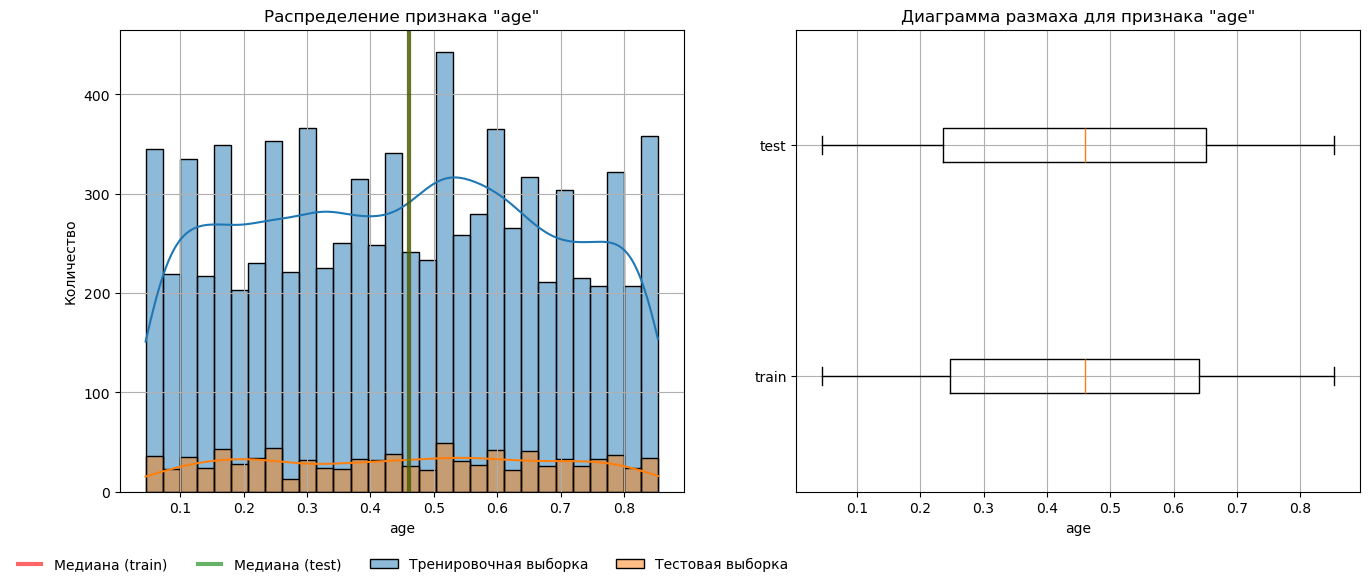

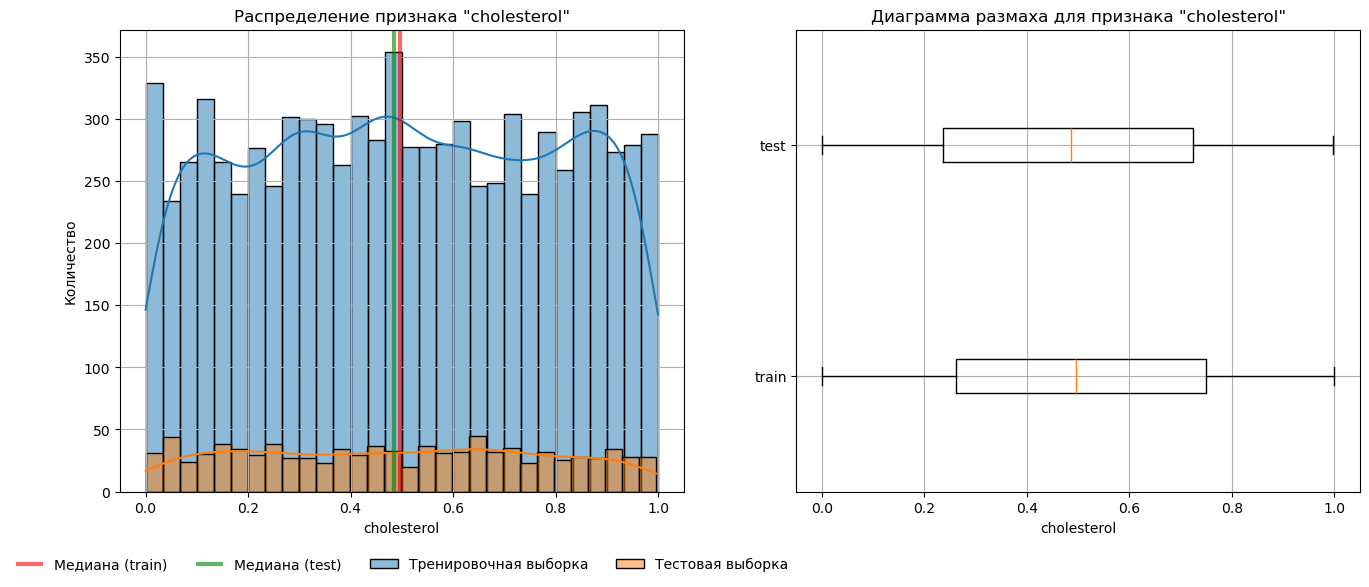

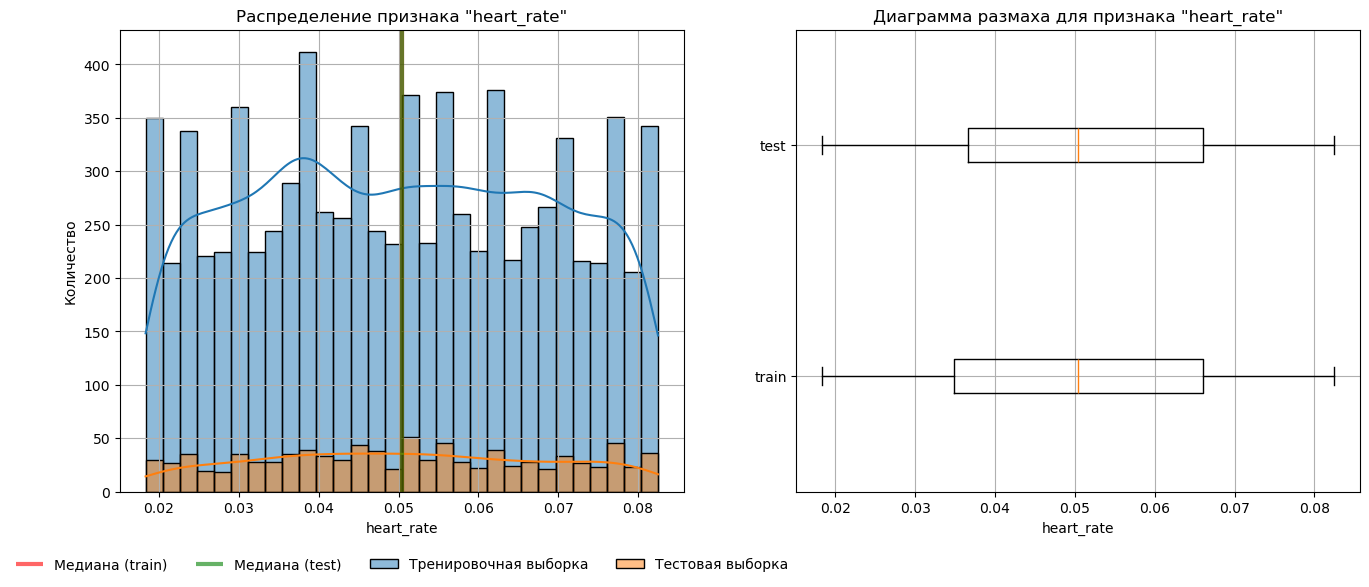

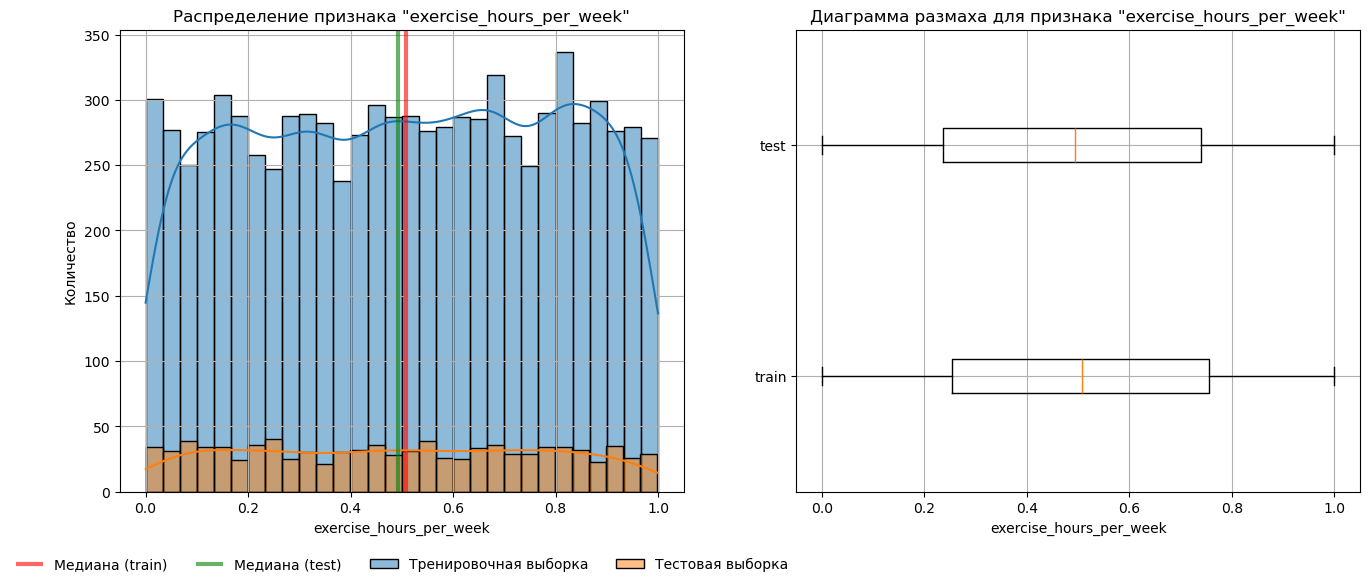

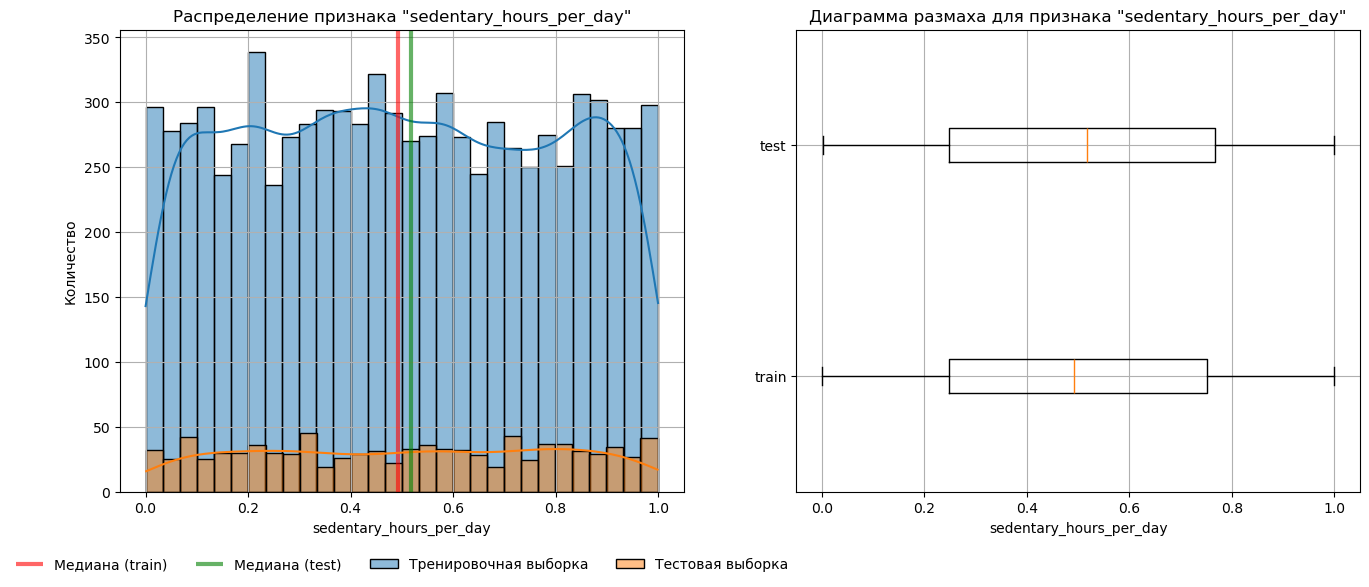

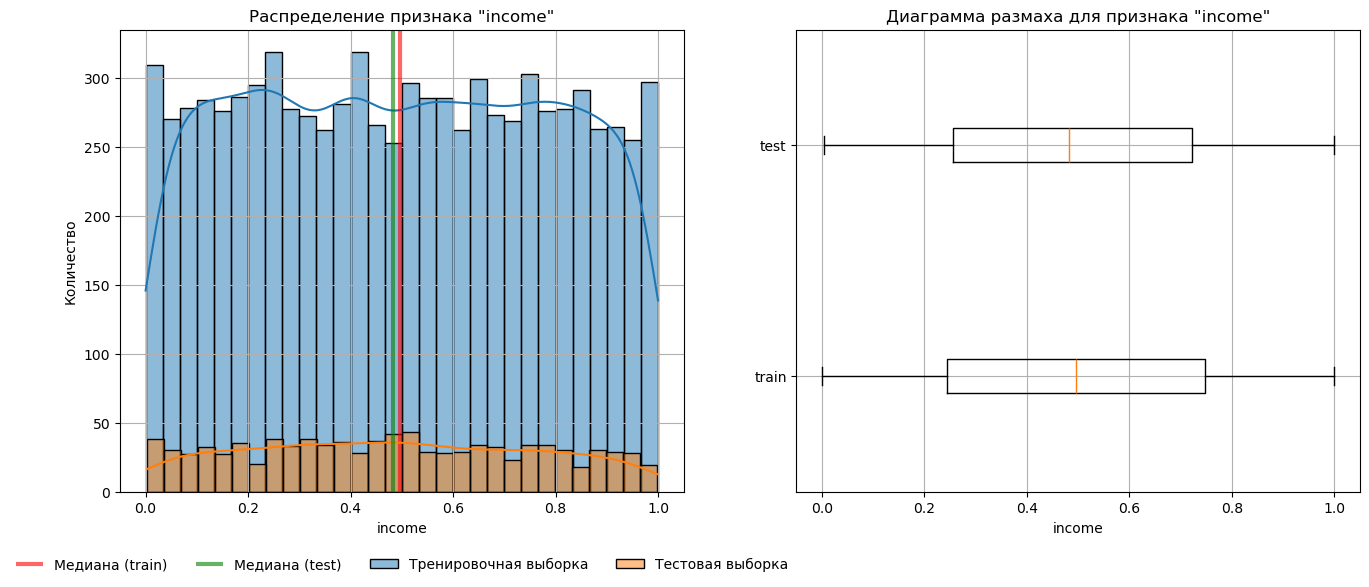

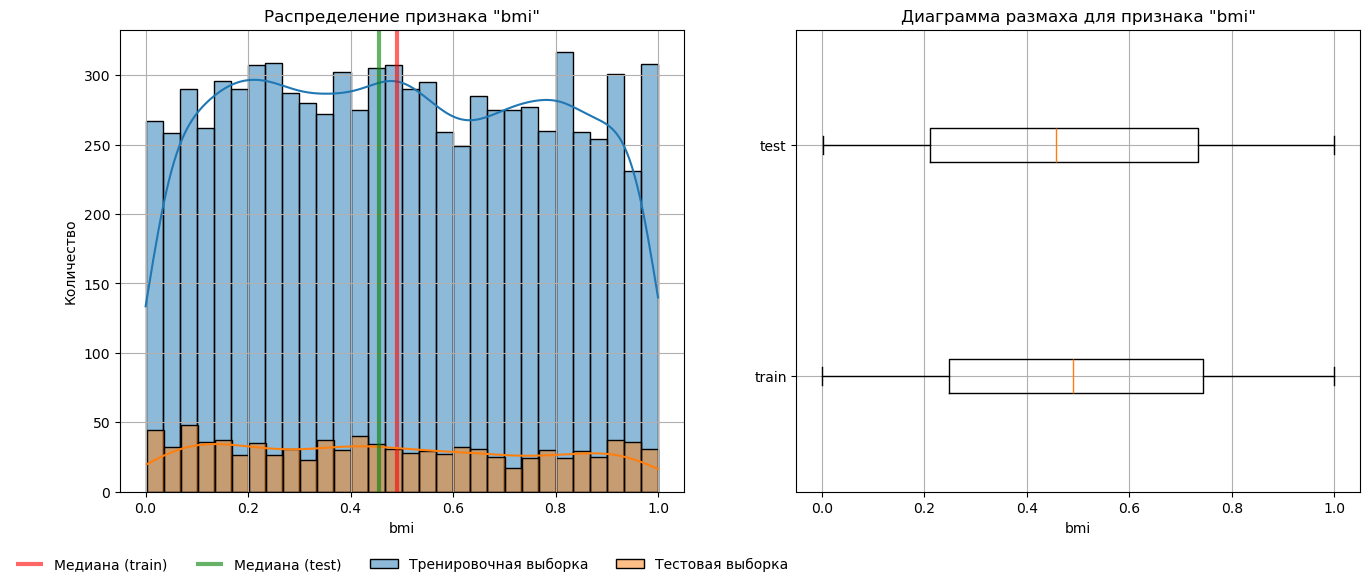

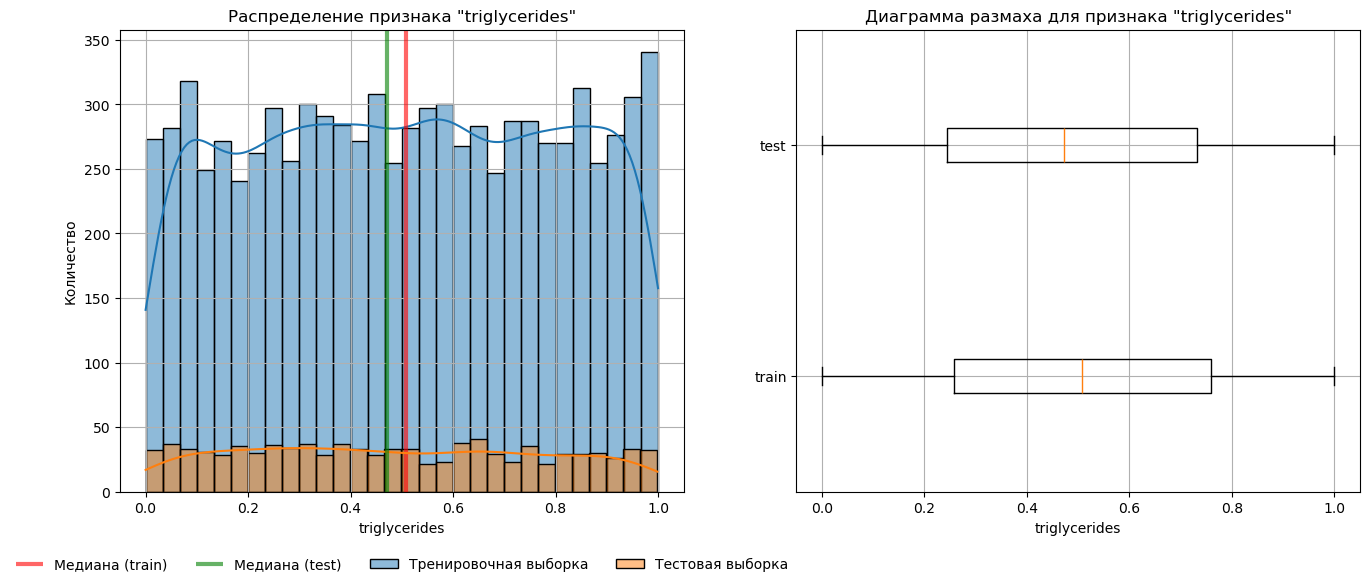

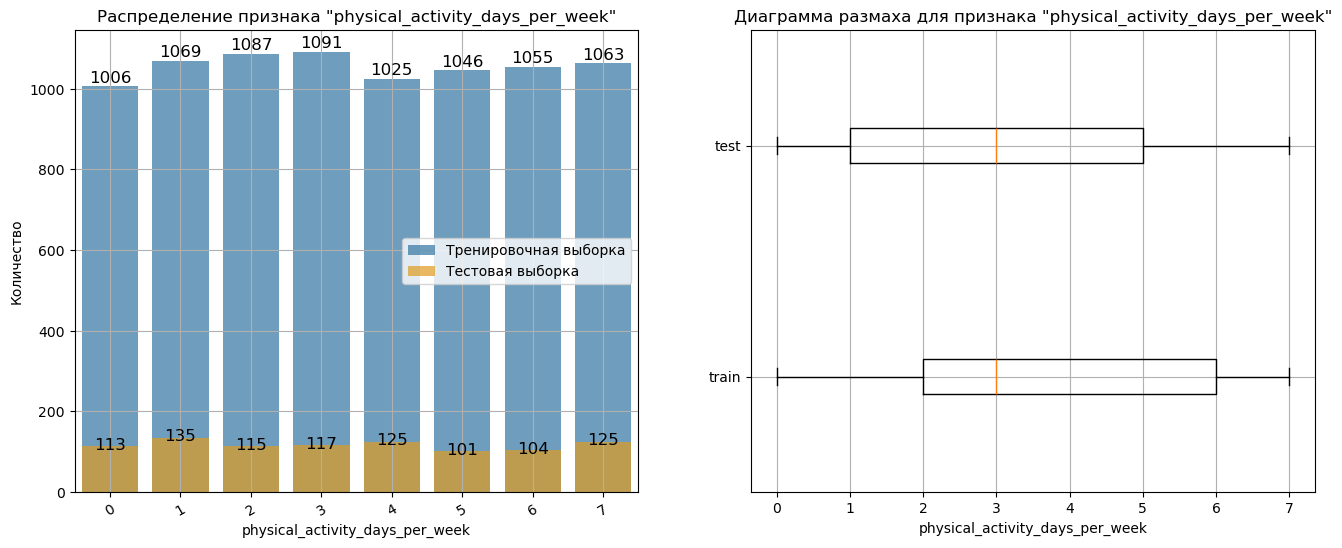

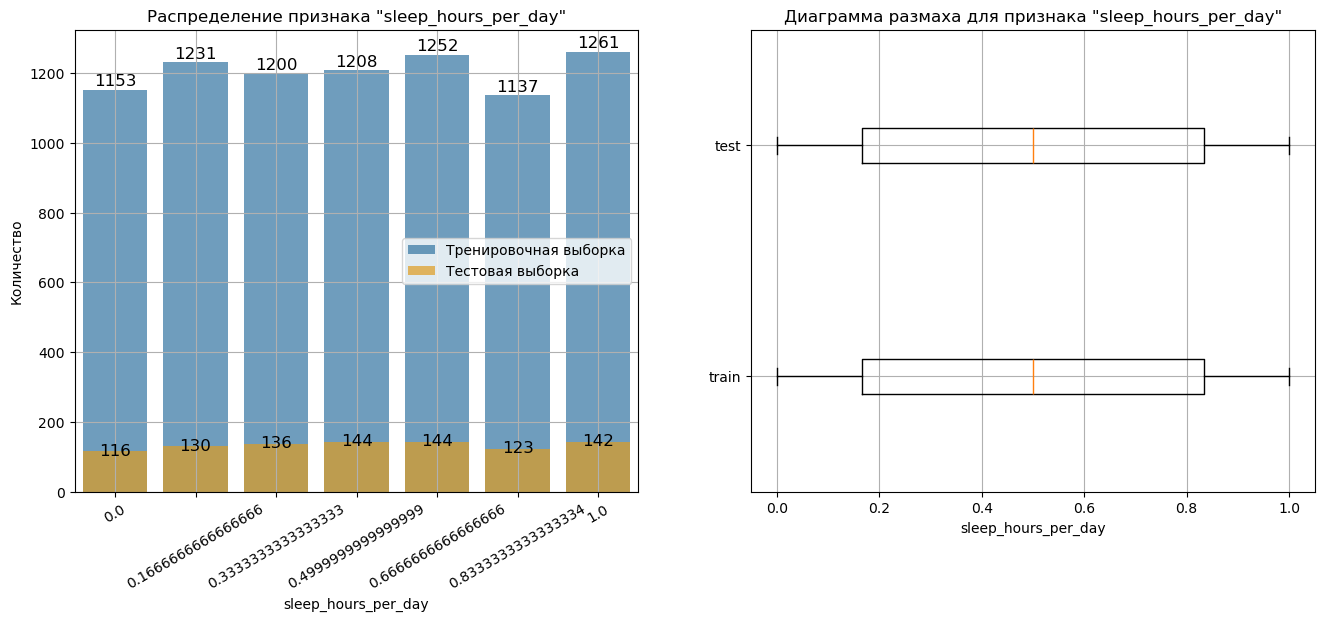

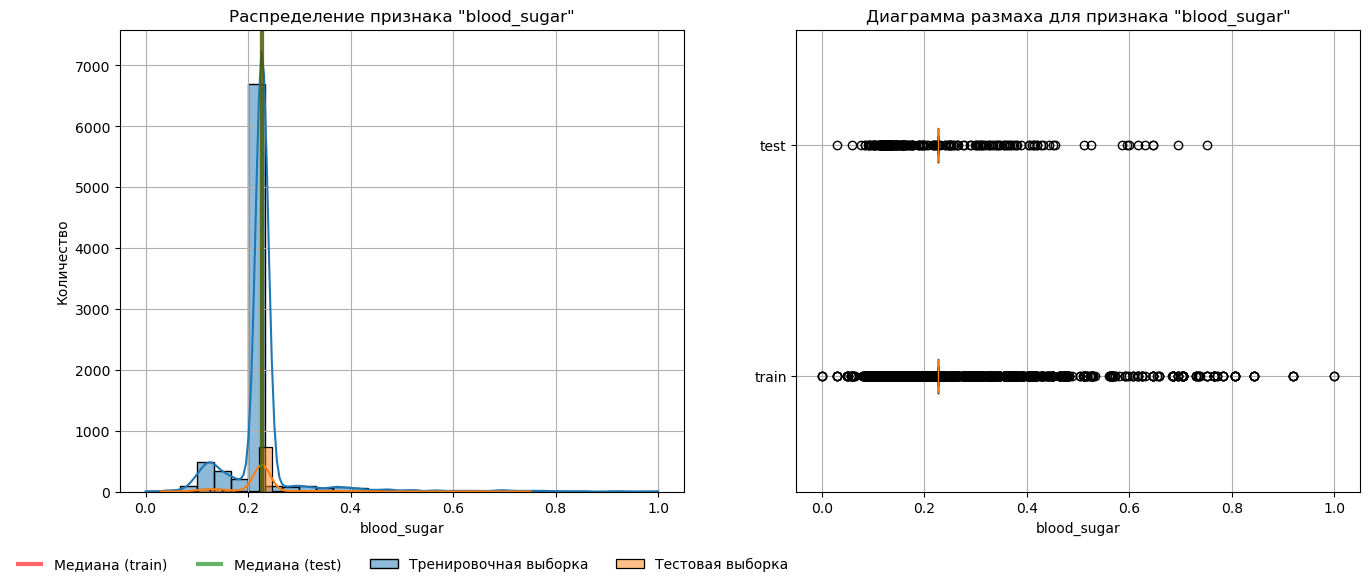

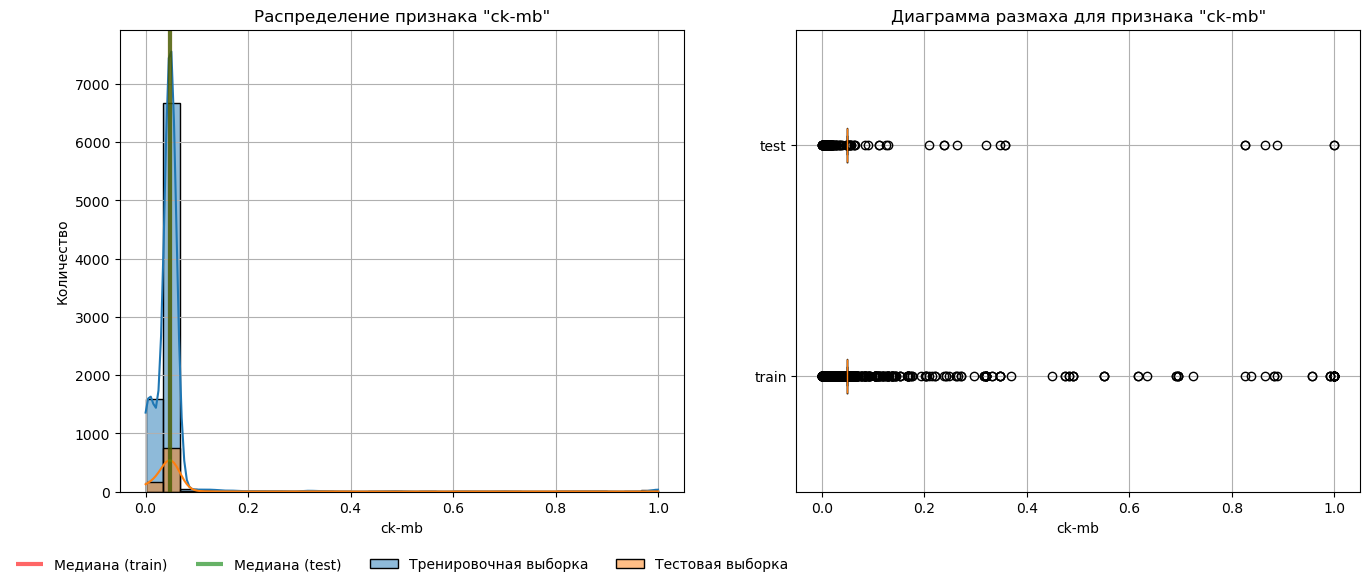

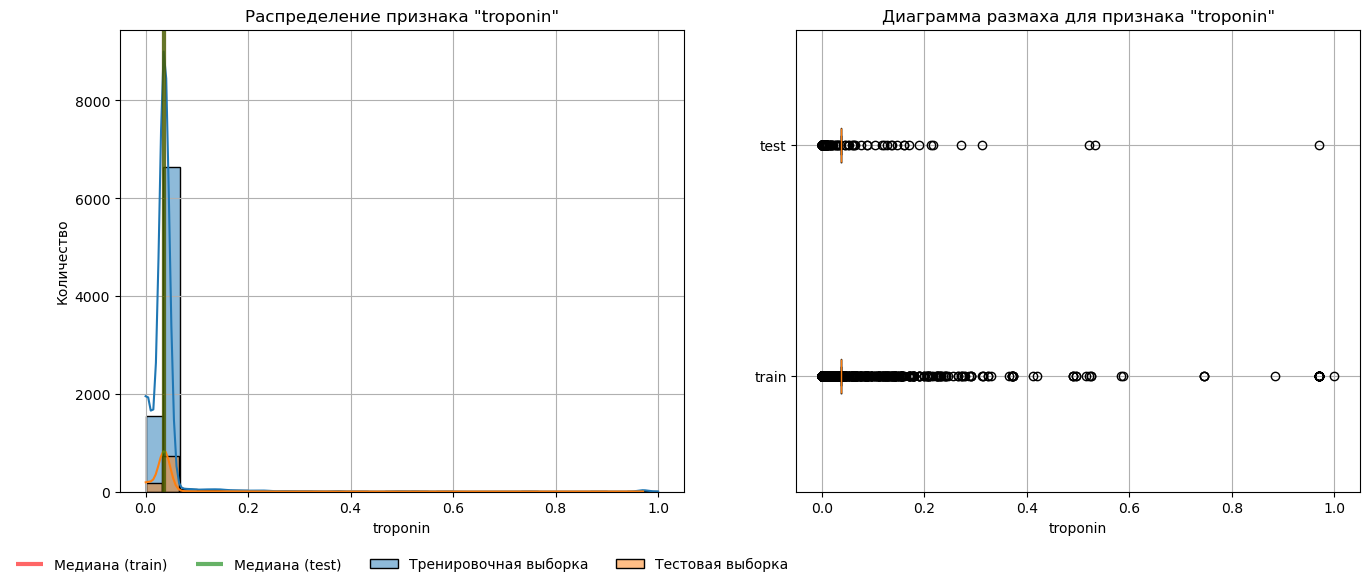

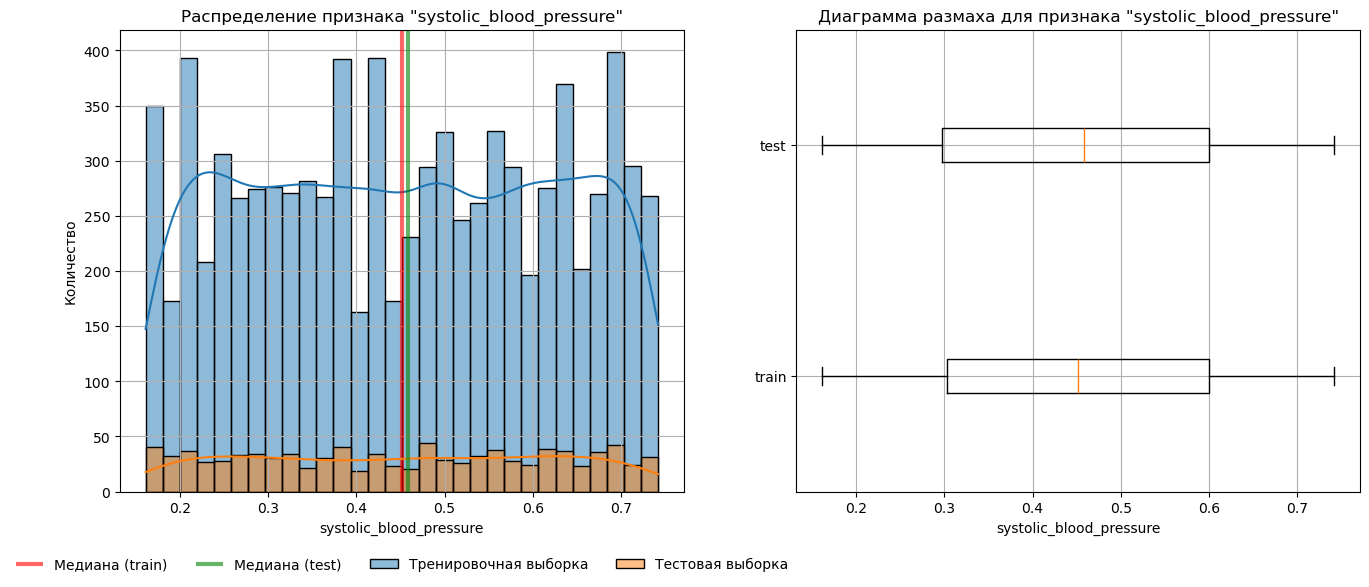

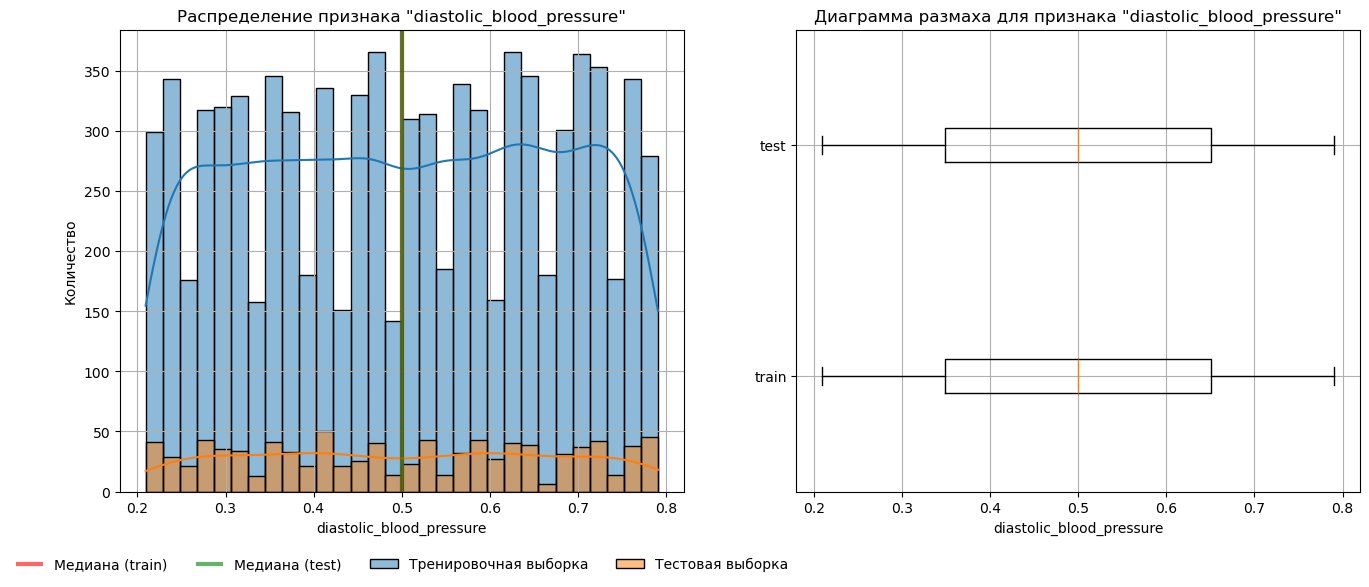

In [48]:
for i in num_col_names:
    if i not in ['sleep_hours_per_day', 'physical_activity_days_per_week']:
        num_plot(
            heart_train_cl, 
            heart_test_cl,
            i, 
            f'Распределение признака "{i}"', 
            f'{i}', 
            f'Диаграмма размаха для признака "{i}"')
    else:
        num_plot(
            heart_train_cl, 
            heart_test_cl,
            i, 
            f'Распределение признака "{i}"', 
            f'{i}', 
            f'Диаграмма размаха для признака "{i}"', 
            var=2)

По графикам видно, что значения тренировочных и тестовых данных очень близки.

У многих признаков (`age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `sleep_hours_per_day`, `systolic_blood_pressure`, `diastolic_blood_pressure`) распределение равномерное, выбросы отсутствуют. Поскольку значения уже масштабированы, они лежат в диапазоне от 0 до 1. Но только у признака `heart_rate` значения в 10 раз меньше и распределены в диапазоне от 0.02 до 0.08. 

Данные у дискретных признаков `physical_activity_days_per_week` и `sleep_hours_per_day` также распределены равномерно, но только у `sleep_hours_per_day` значения масштабированы и лежат в диапазоне от 0 до 1, а у `physical_activity_days_per_week` значения не масштабированы и находятся в диапазоне от 0 до 7. Нужно будет это учесть при построении модели.

У признака `blood_sugar` большая часть значений приходится на довольно узкий диапазон (от 0 до 0.5) и есть выбросы. Но из-за того, что данные уже масштабированы, мы не знаем, какие значения за ними скрыты. Поэтому пока оставим как есть и посмотрим дальше.

Признаки же `ck-mb` и `troponin` - это показатели, которые являются чувствительными маркерами повреждения сердечной мышцы и повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск сердечного приступа, т.е. происходит утечка целевого признака. Их нужно будет удалить.

Можно также посмотреть систолическое и диастолическое давление, поскольку исходные показатели систолического должны быть выше показателей диастолического. Однако после масштабирования это может стать не так и может быть связано с тем, что у значений того и другого давления разные диапазоны значений, и при этом была произведена независимая обработка признаков. 

Посмотрим на разницу между масштабированными показателями верхнего и нижнего давления (пульсовое давление 'pulse_pressure') - у реальных показателей она не может быть меньше 0, и посчитаем количество строк с отрицательной разницей между верхним и нижним давлением.

In [49]:
heart_train_cl.query('(systolic_blood_pressure - diastolic_blood_pressure) < 0').shape[0]

4922

In [50]:
heart_test_cl.query('(systolic_blood_pressure - diastolic_blood_pressure) < 0').shape[0]

541

Больше половины значений разницы давлений, как видим, отрицательные. Тем не менее оставим как есть, после масштабирования такое могло произойти, хотя не должно оказать значительного влияния на эффективность моделей. 

### 3.2. Анализ категориальных признаков

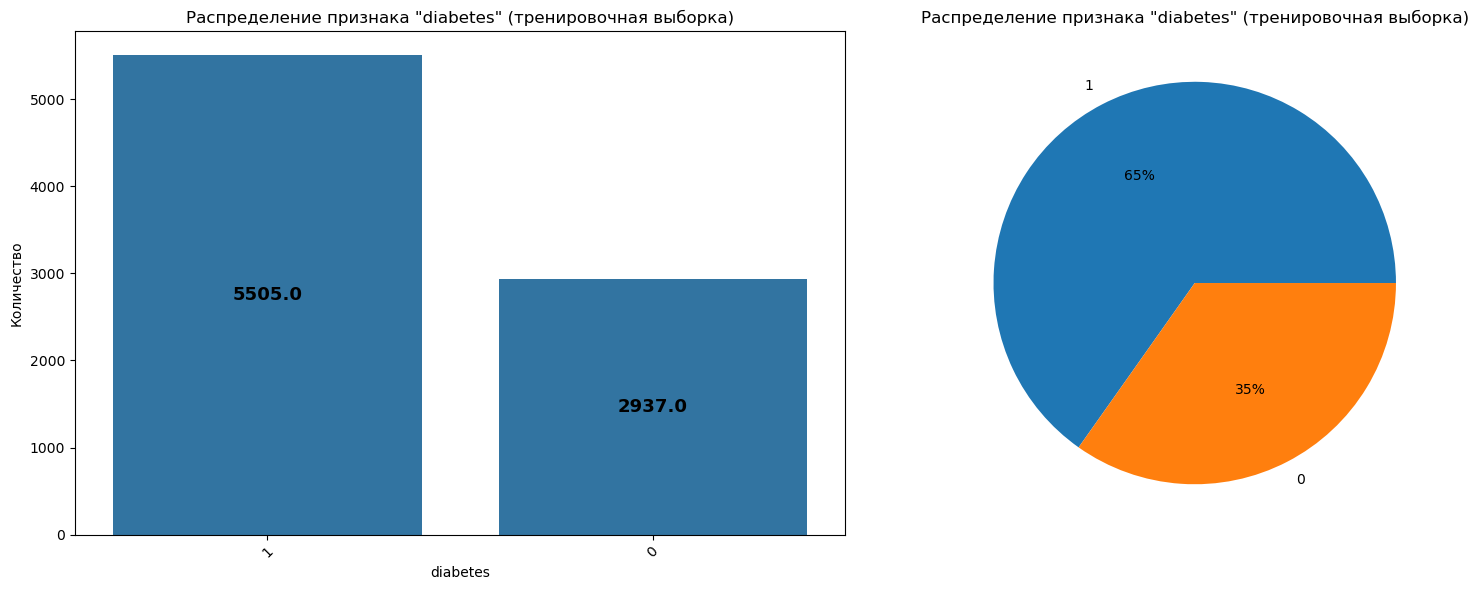

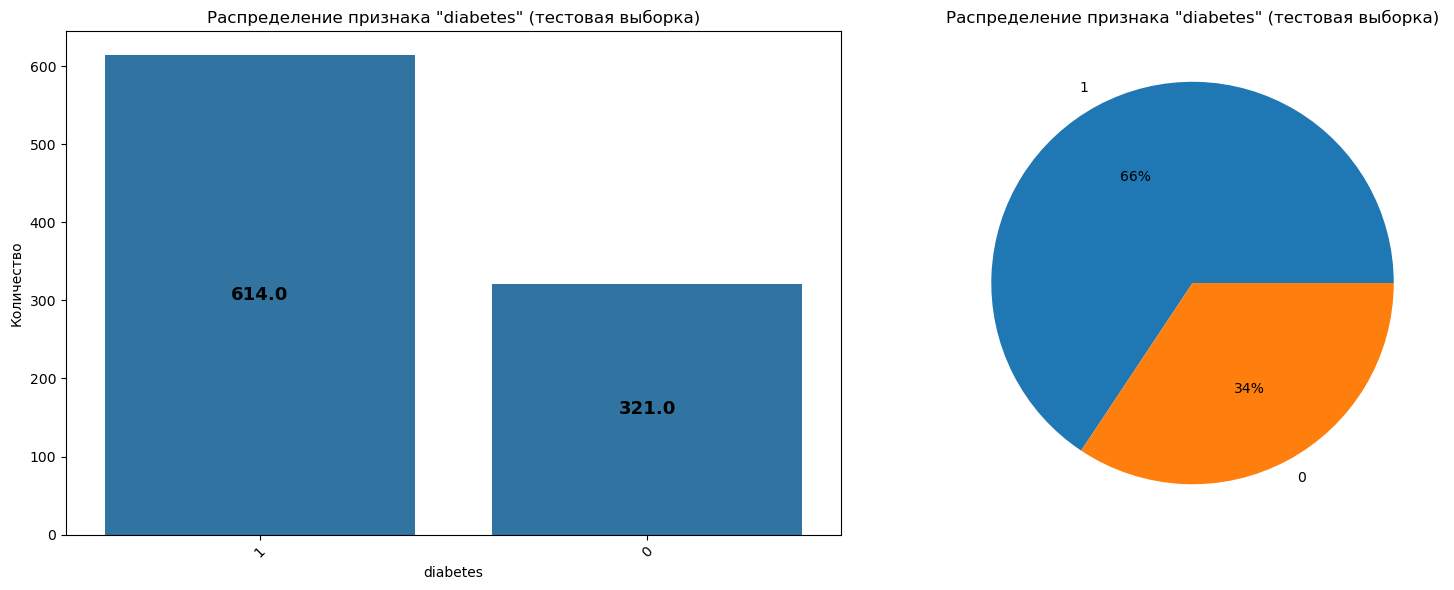

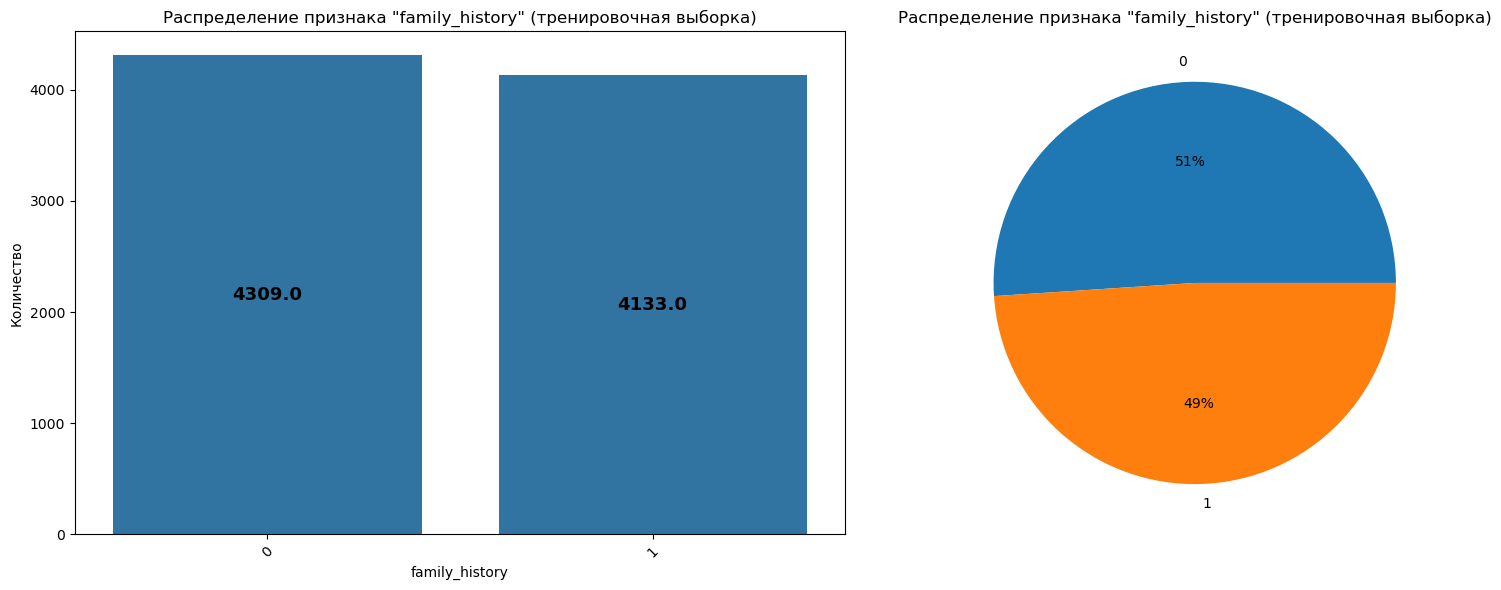

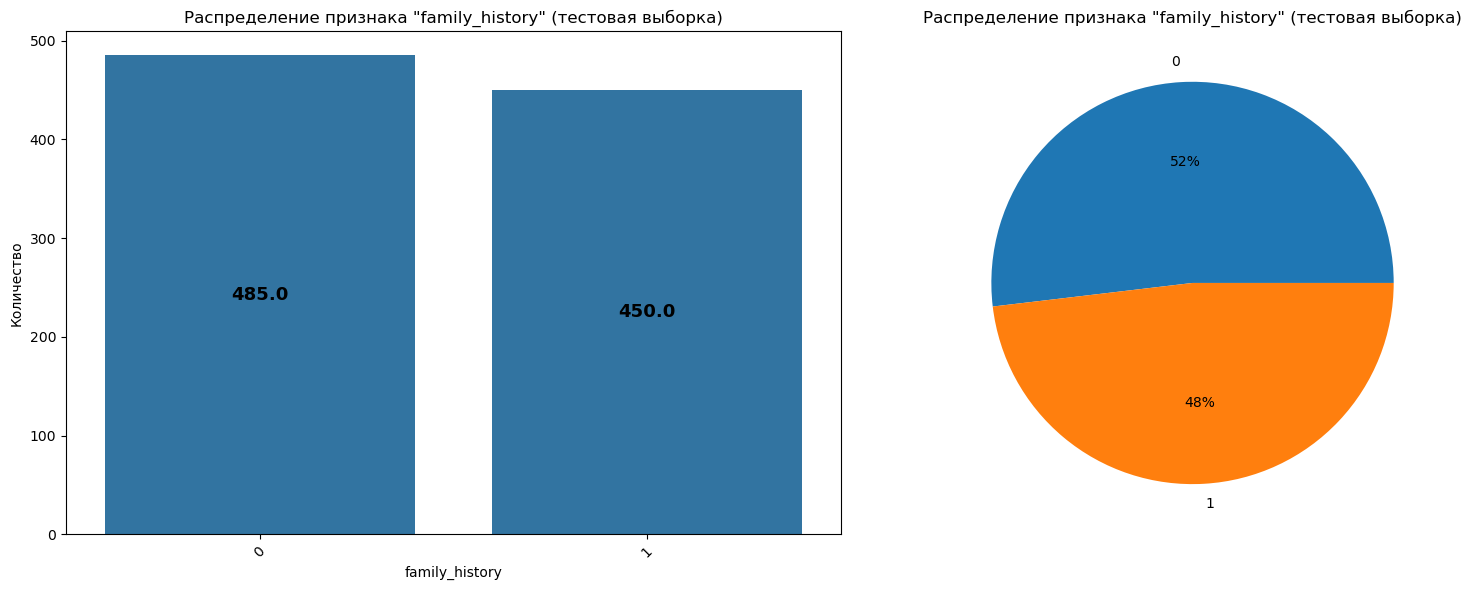

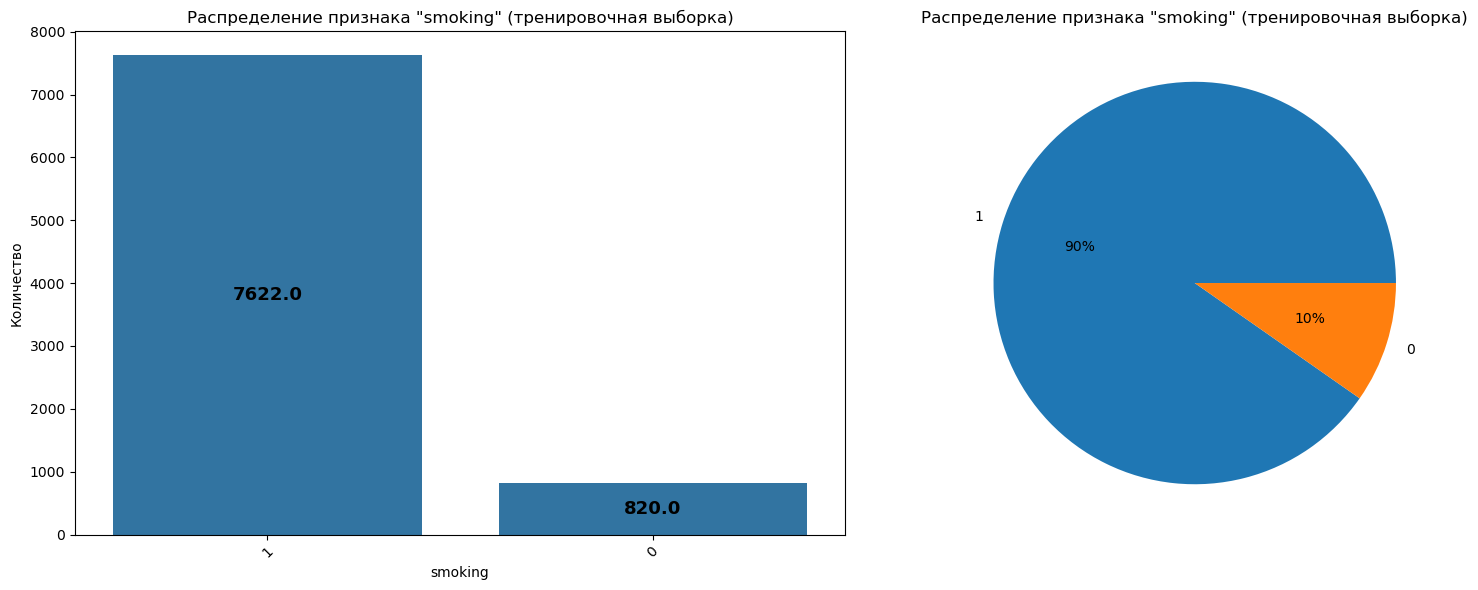

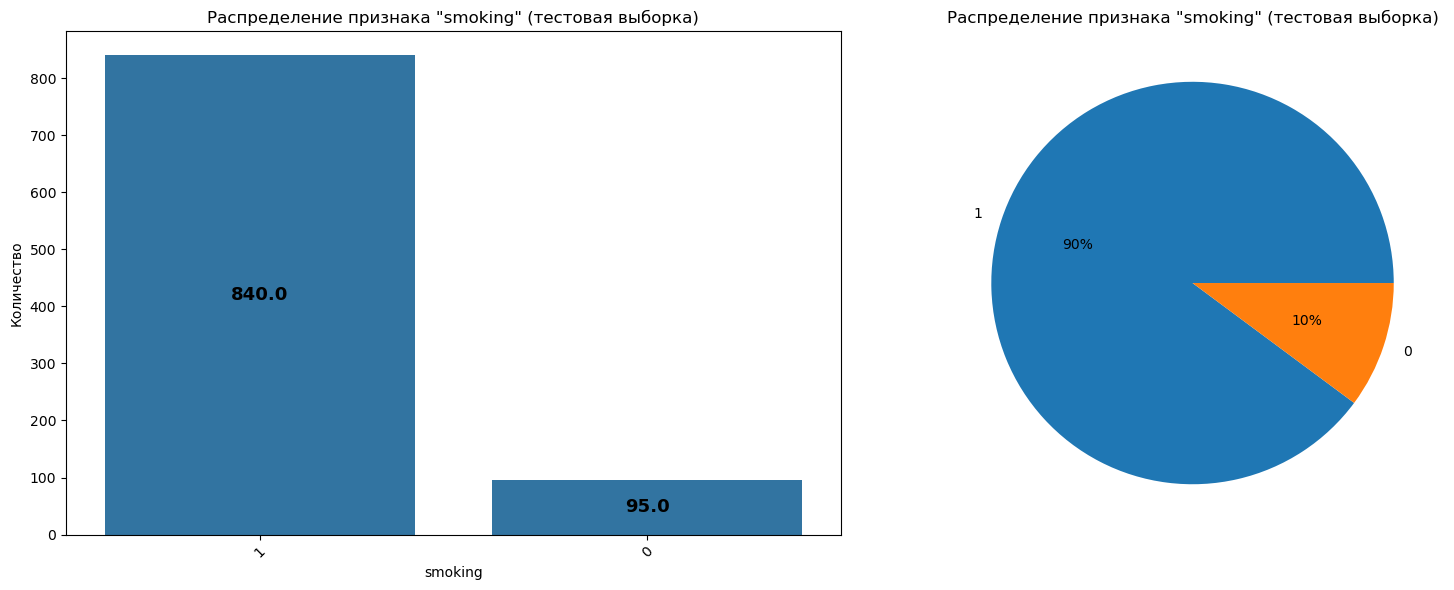

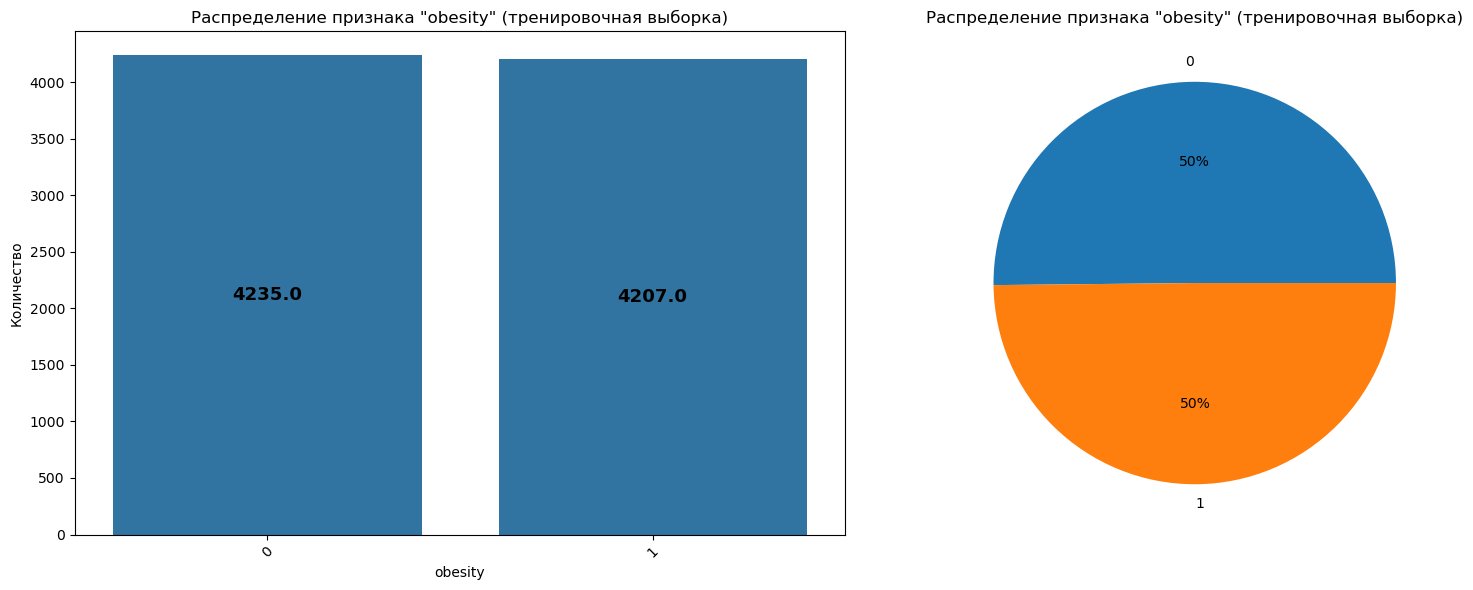

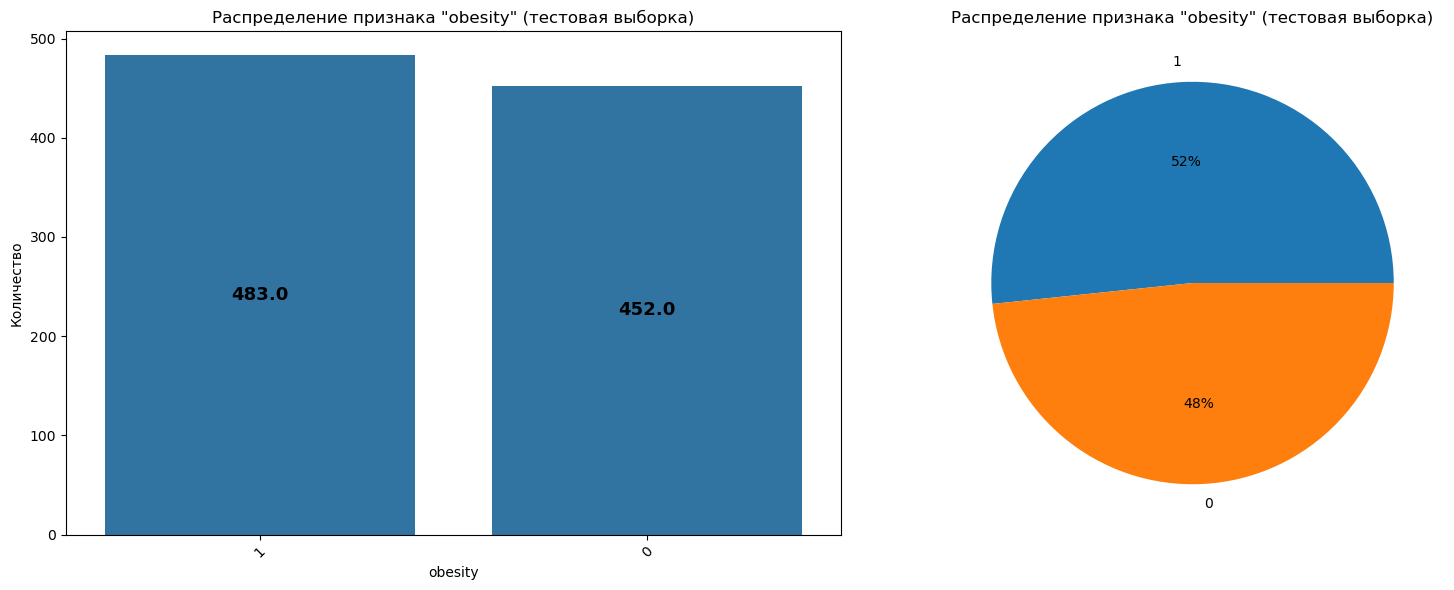

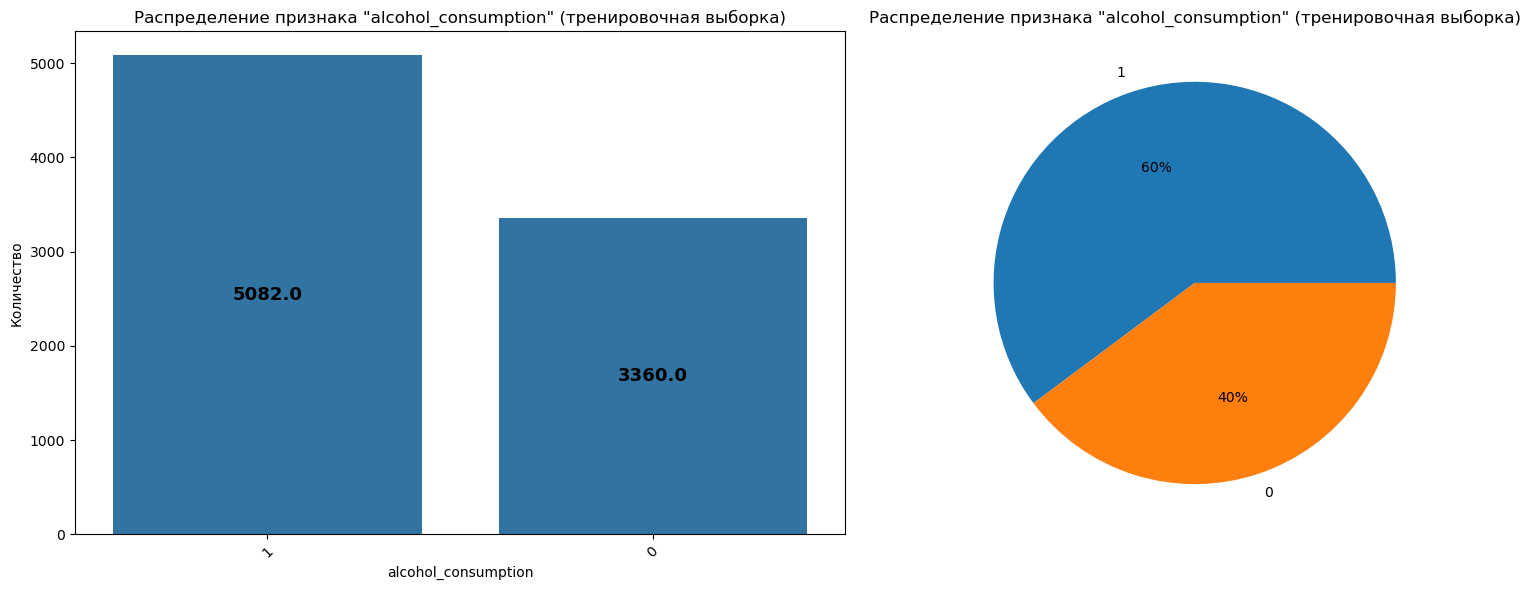

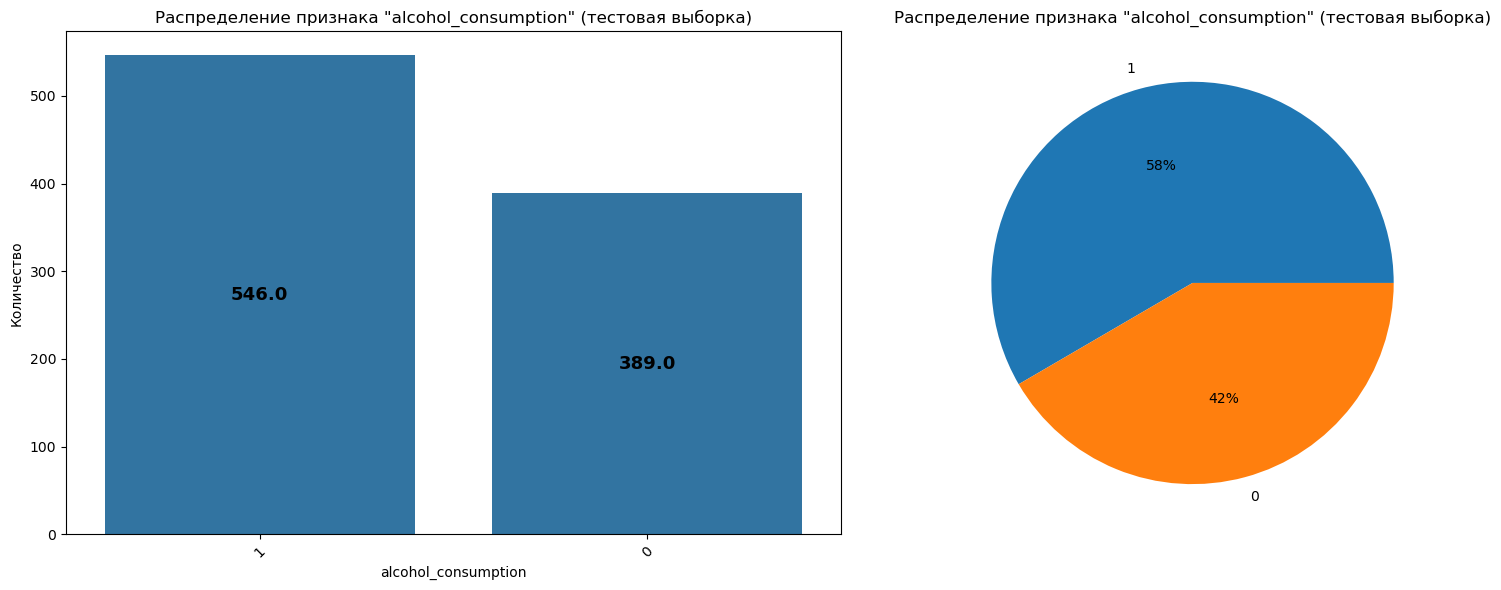

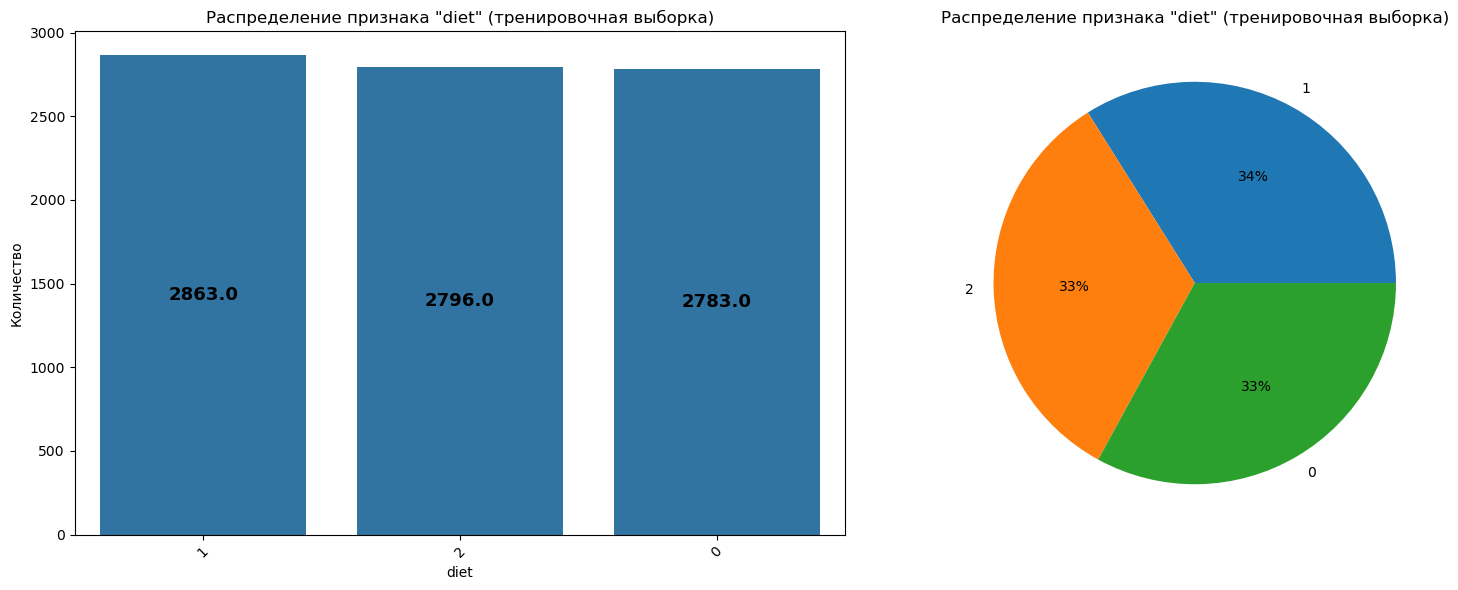

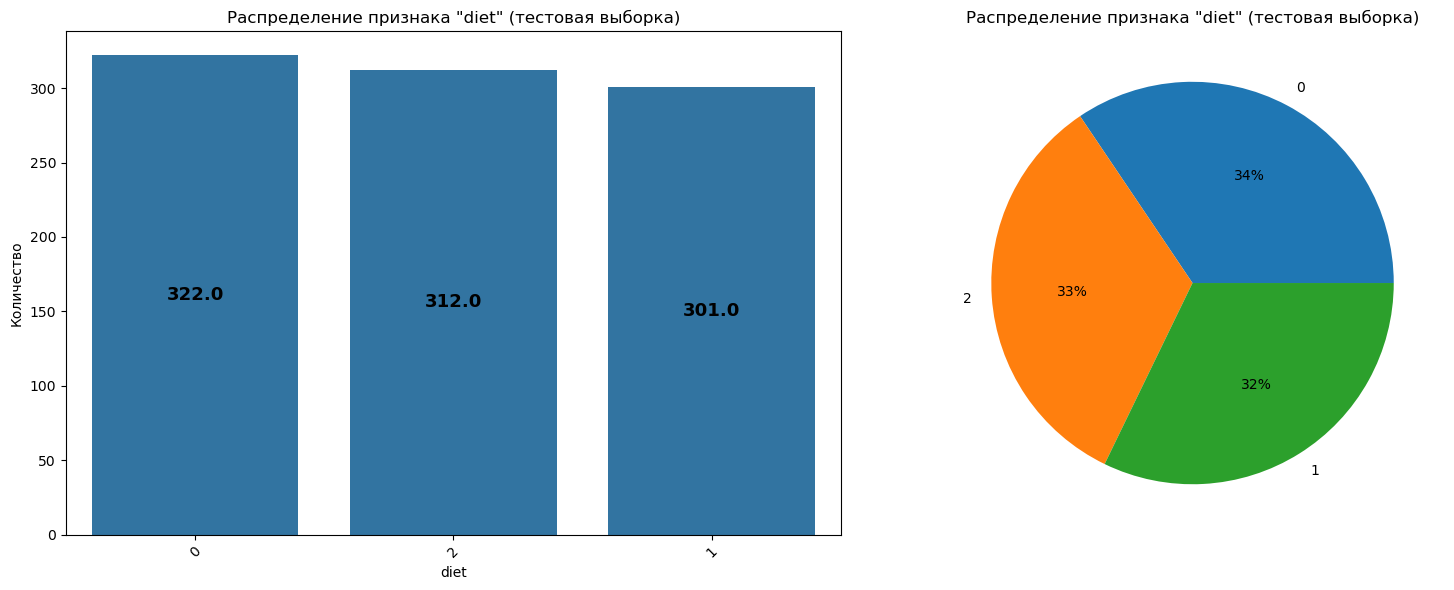

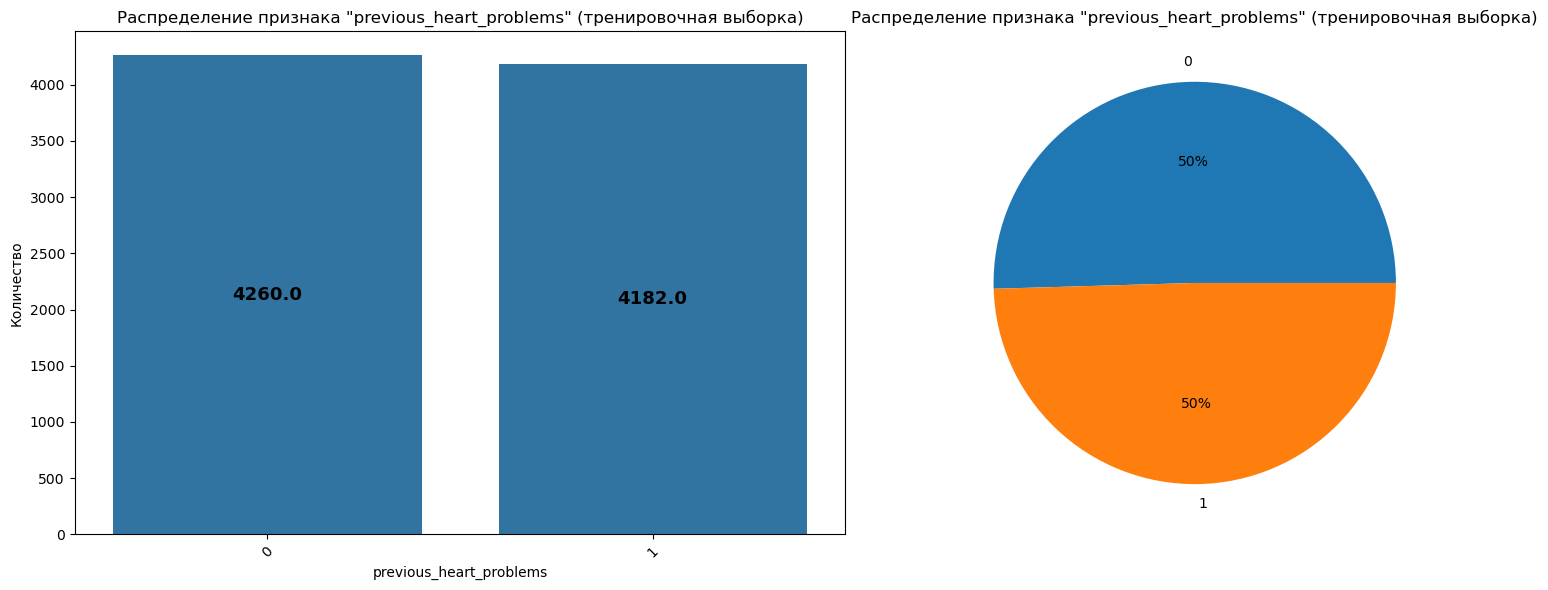

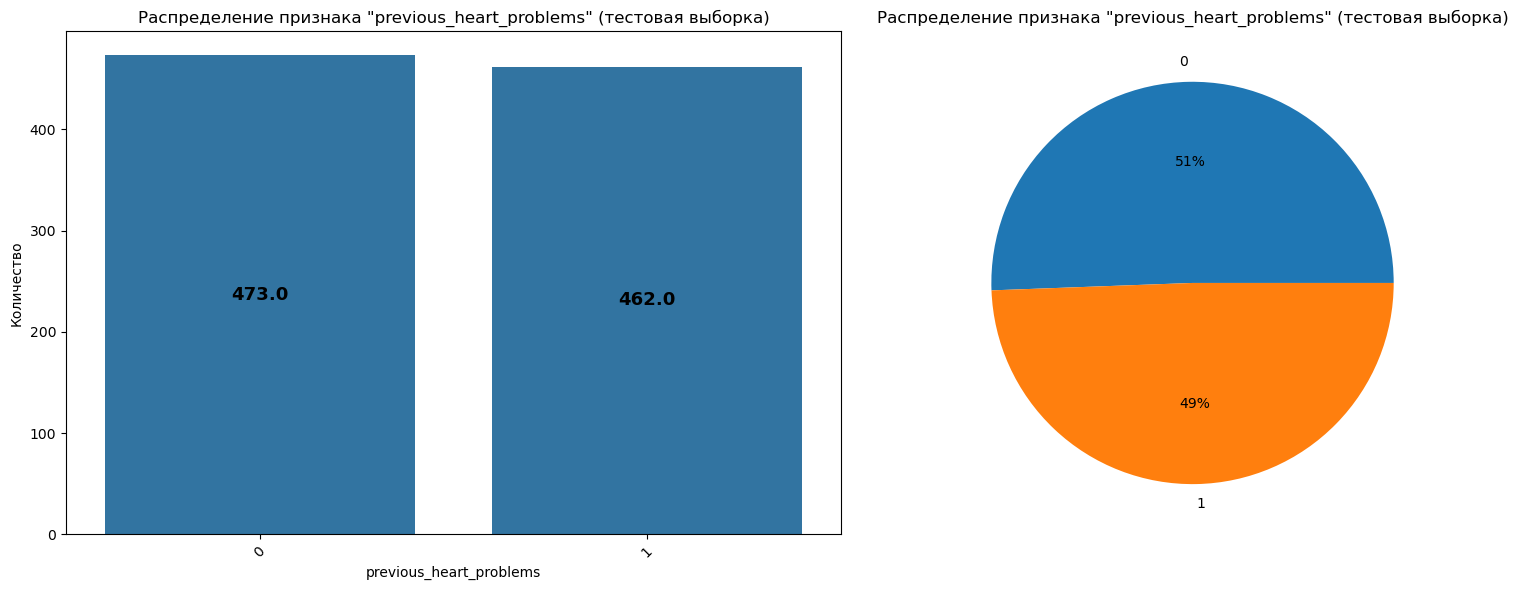

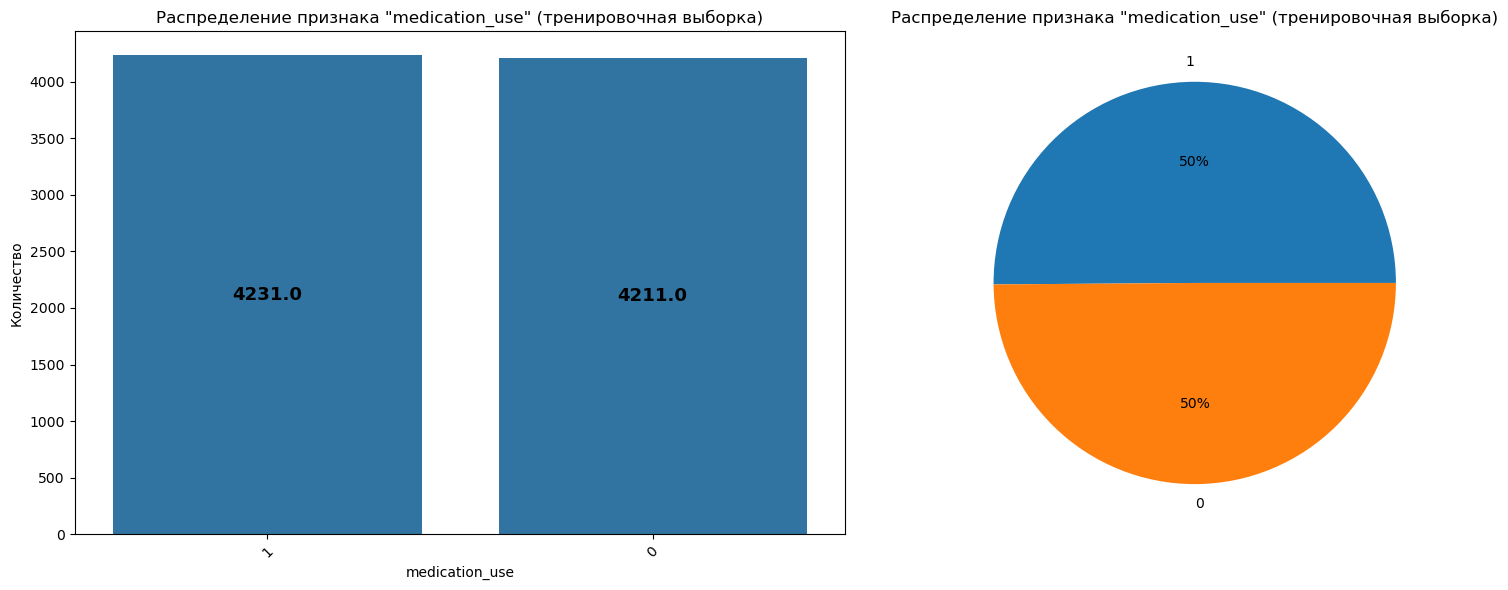

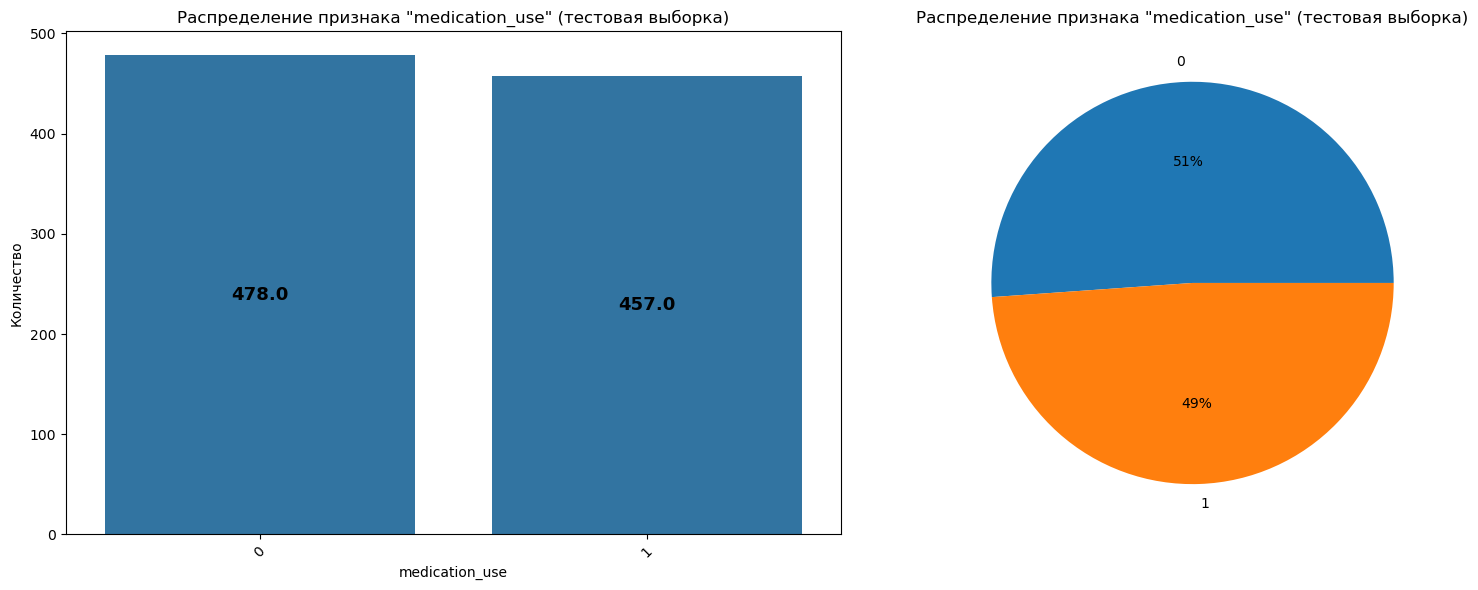

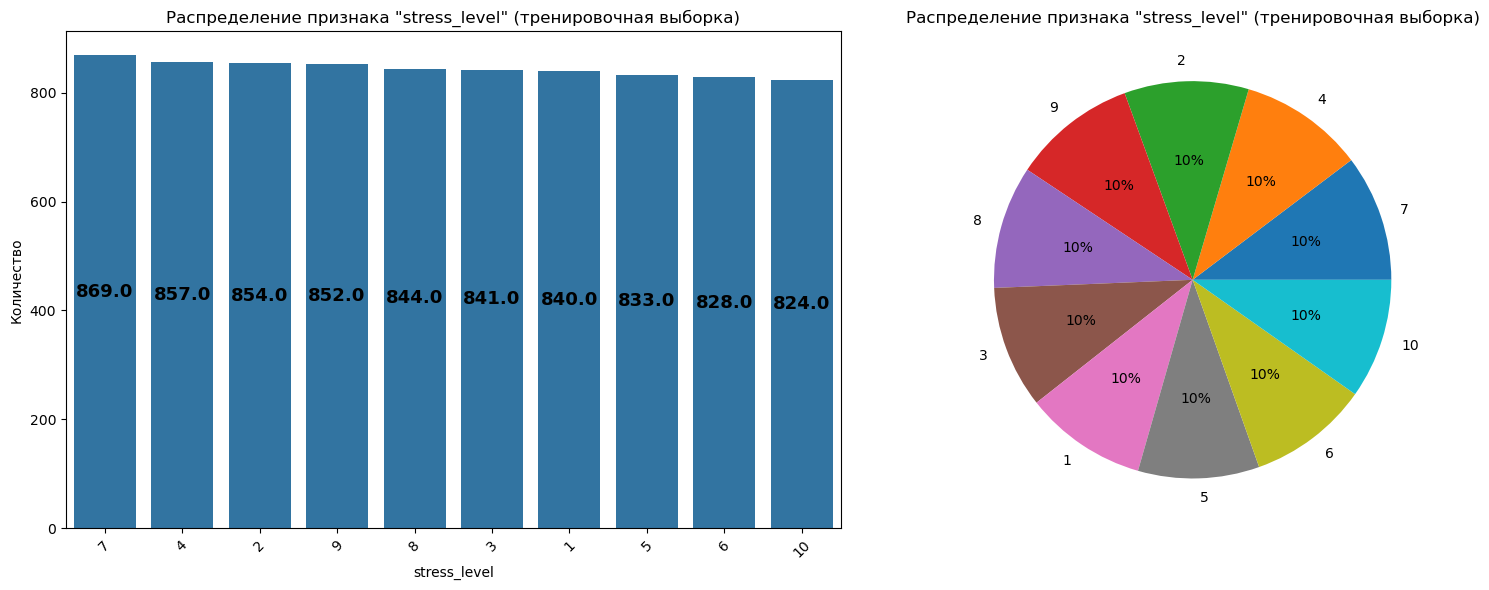

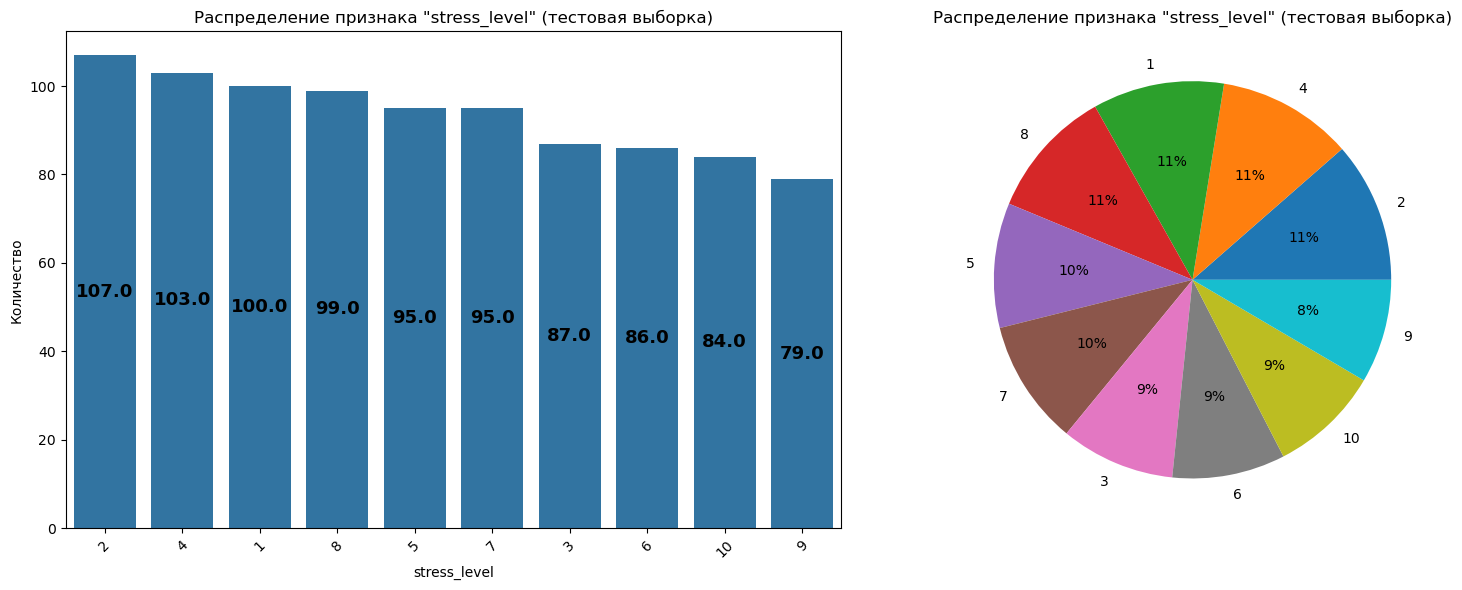

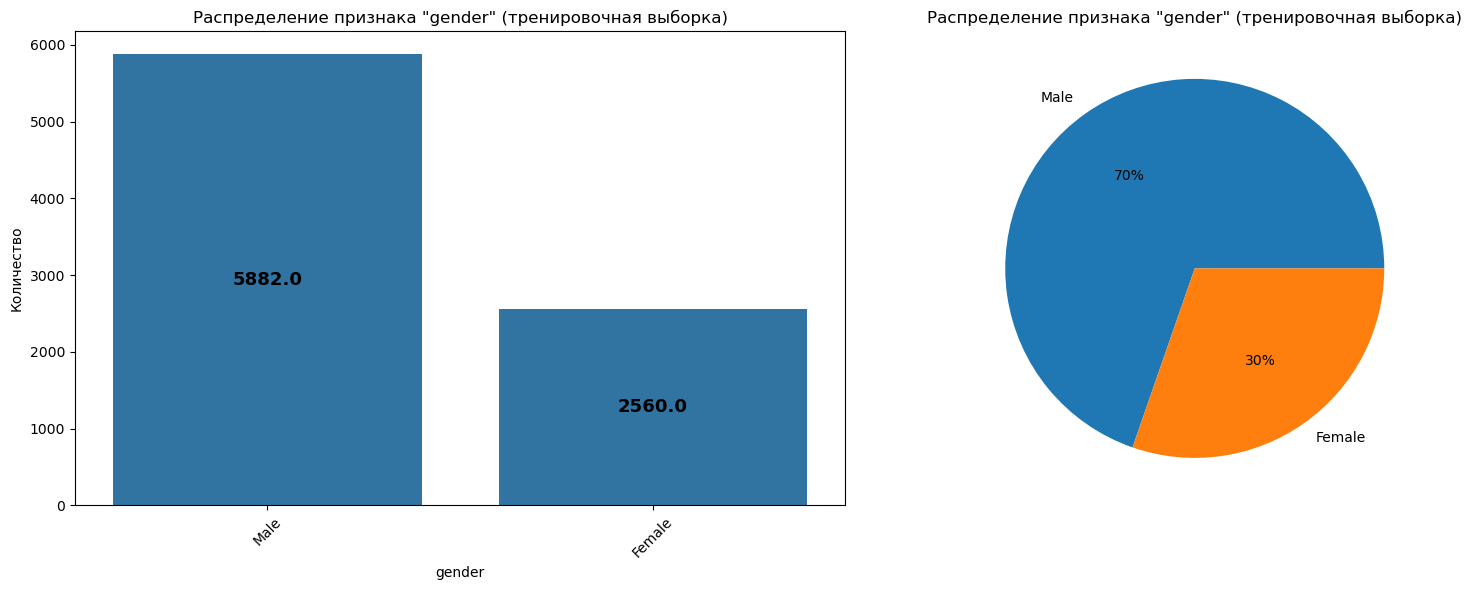

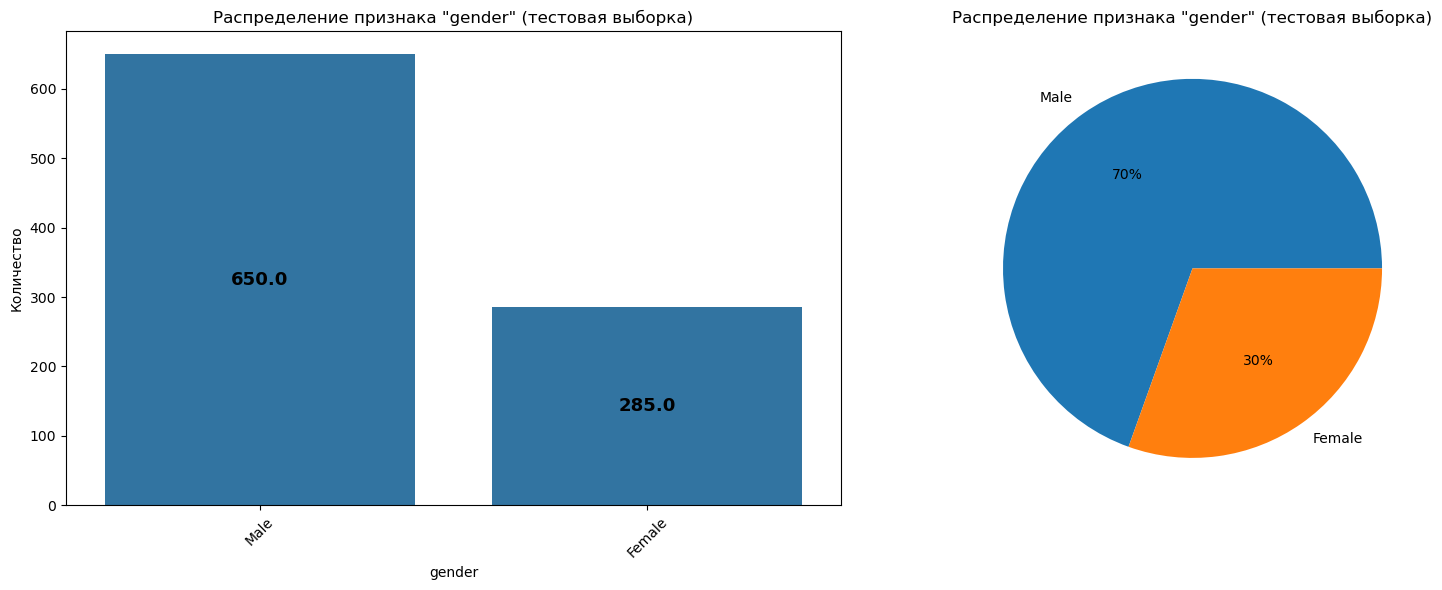

In [51]:

cat_col_names = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 
                 'stress_level', 'gender', 'heart_attack_risk_(binary)']
for i in cat_col_names[:-1]:
    count_pie_plot(
        data=heart_train_cl,
        x=i,
        title=f'Распределение признака "{i}" (тренировочная выборка)', 
        xlabel=f'{i}'
           )
    count_pie_plot(
        data=heart_test_cl, 
        x=i,
        title=f'Распределение признака "{i}" (тестовая выборка)', 
        xlabel=f'{i}'
           )

Здесь тоже значения тренировочной и тестовой выборки очень близки.  

Распределение признаков, в основном, равномерное. Исключения: `gender` (Пол) - 70% мужчины и 30% женщины , `smoking` (Курение) - некурящие составляют лишь 10%, курящие - 90%, `diabetes` (Диабет) - с диабетом 65%, без диабета 35%. 

Посмотрим на распределение целевого признака.

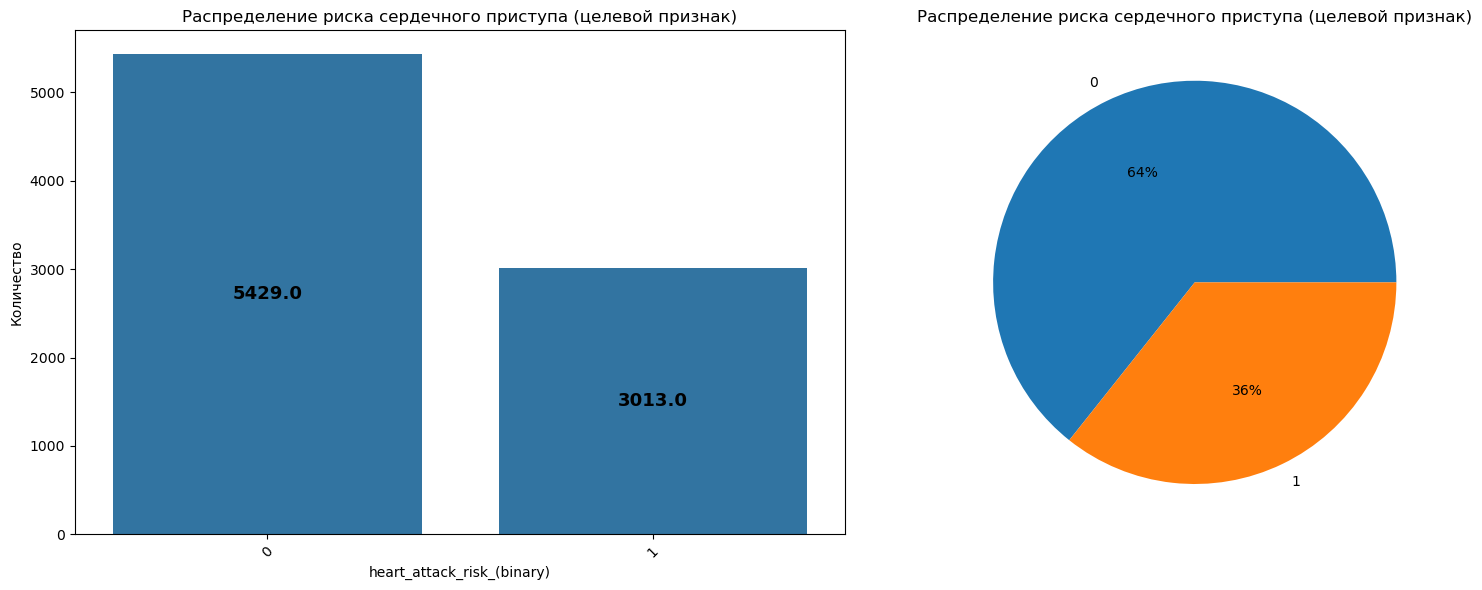

In [52]:
count_pie_plot(
        heart_train_cl,
        'heart_attack_risk_(binary)', 
        'Распределение риска сердечного приступа (целевой признак)', 
        'heart_attack_risk_(binary)')

Наблюдается дисбаланс классов (доля значений с наличием риска сердечного приступа почти в два раза меньше, чем с отсутствием риска сердечного приступа). Чтобы это учесть, можно будет воспользоваться сэмплированием или использовать class_weight. А для оценки качества модели можно использовать устойчивую к дисбалансу метрику ROC-AUC.

### 3.3. Корреляционный анализ

Построим матрицу корреляции $\phi_K$ для `heart_train_cl`

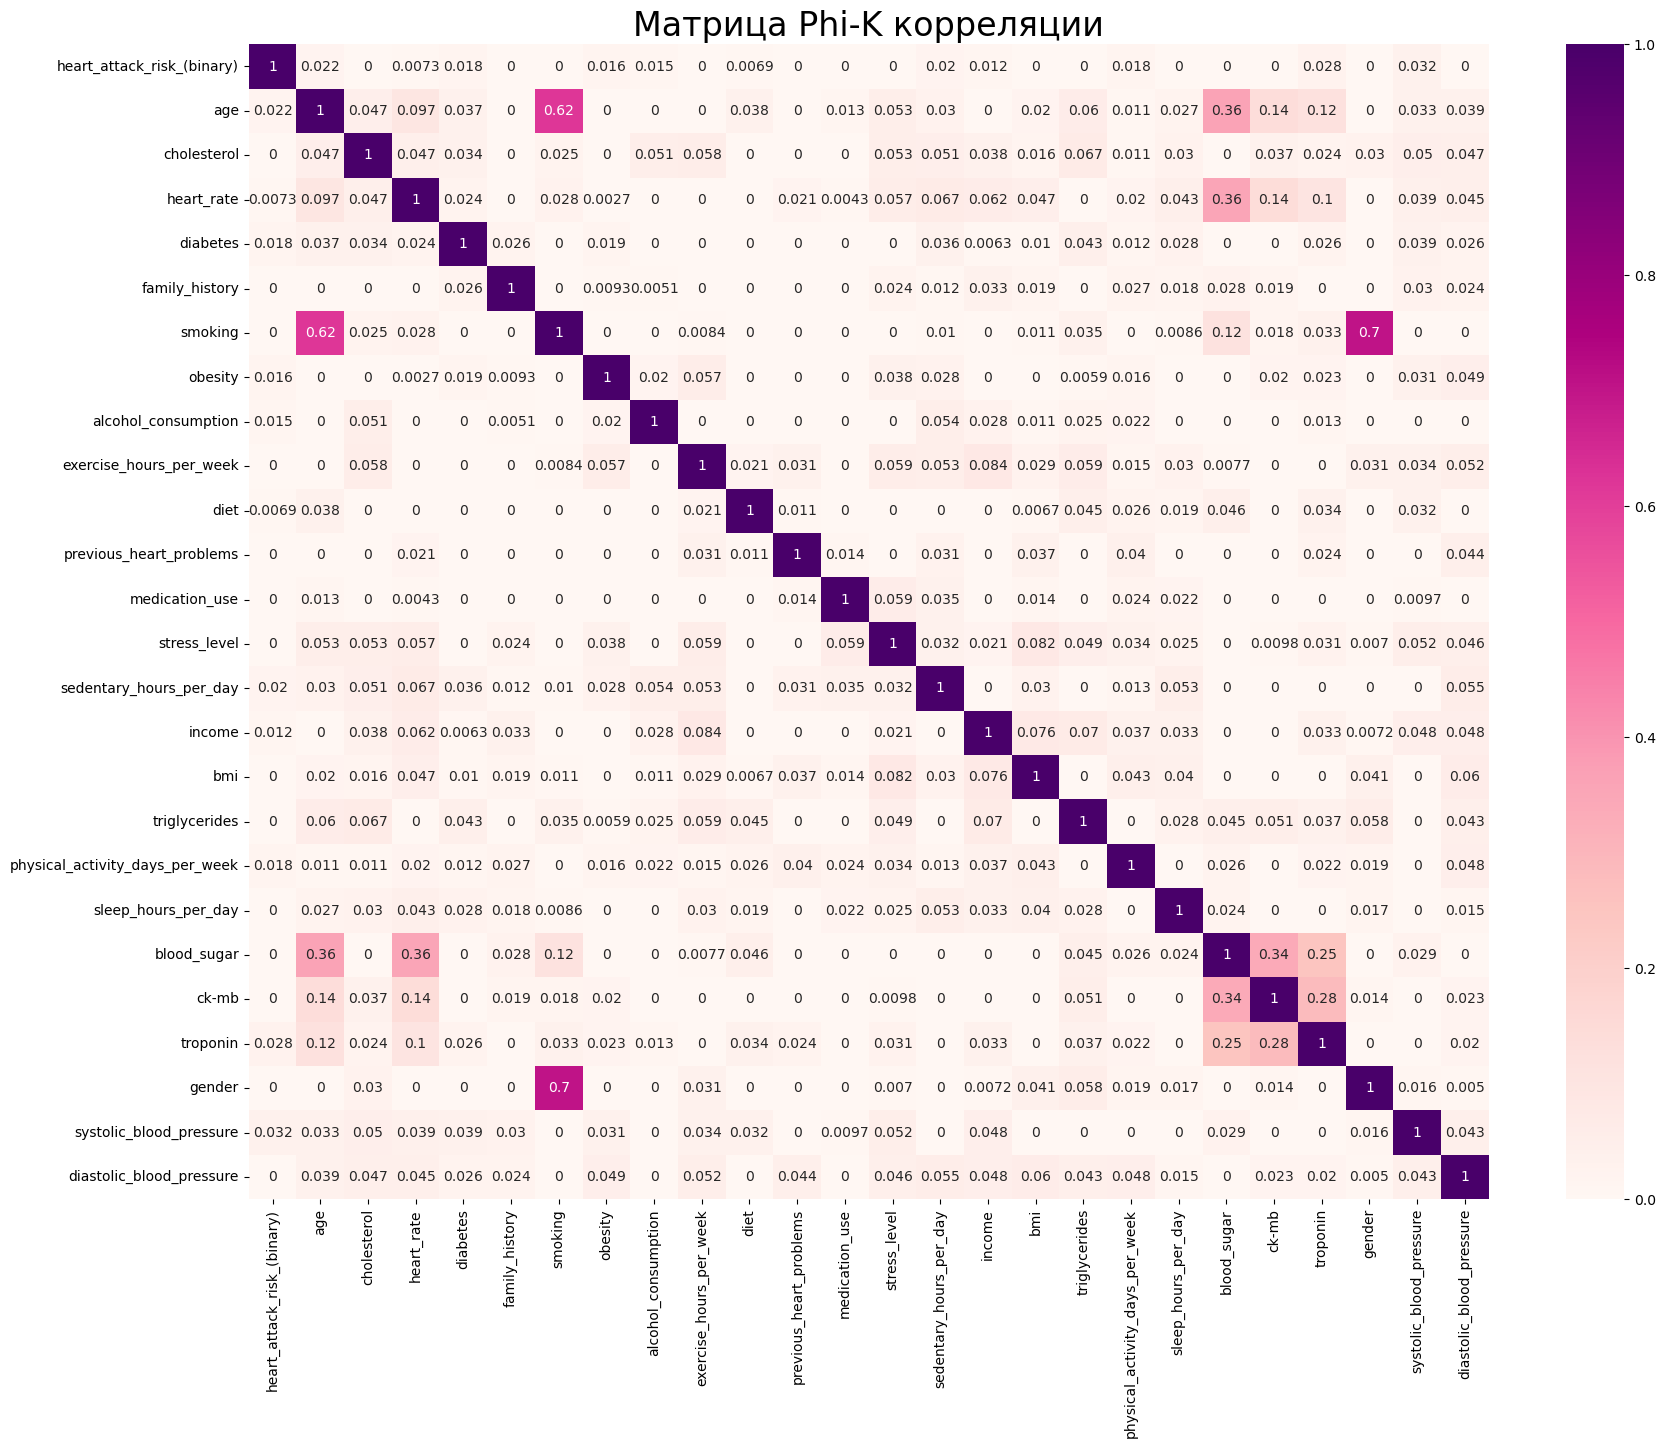

In [53]:
# Построим матрицу корреляции (без колонки 'id') средствами библиотеки `phik``
interval_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', \
'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']

plt.figure(figsize=(20,15))
sns.heatmap(heart_train_cl.drop(columns=['id'], axis=1).phik_matrix(interval_cols=interval_cols)                     
                                         , annot=True, cmap='RdPu')
plt.title('Матрица Phi-K корреляции', fontsize=24)
plt.show()

Наблюдается очень слабая (практически отсутствует) корреляция между целевым признаком с любым из признаков.
Корреляционная матрица показала взаимосвязь признаков `smoking` (Курение) и `gender` (Пол);  `smoking` (Курение) и `age` (Возраст).
Также видим слабую корреляцию между `age` (Возраст) и `blood_sugar` (Уровень сахара), между `heart_rate` (Пульс) и `blood_sugar` (Уровень сахара).   

В остальном мультиколинеарности между входными признаками не наблюдается.

Построим матрицу корреляции $\phi_K$ для `heart_test_cl`

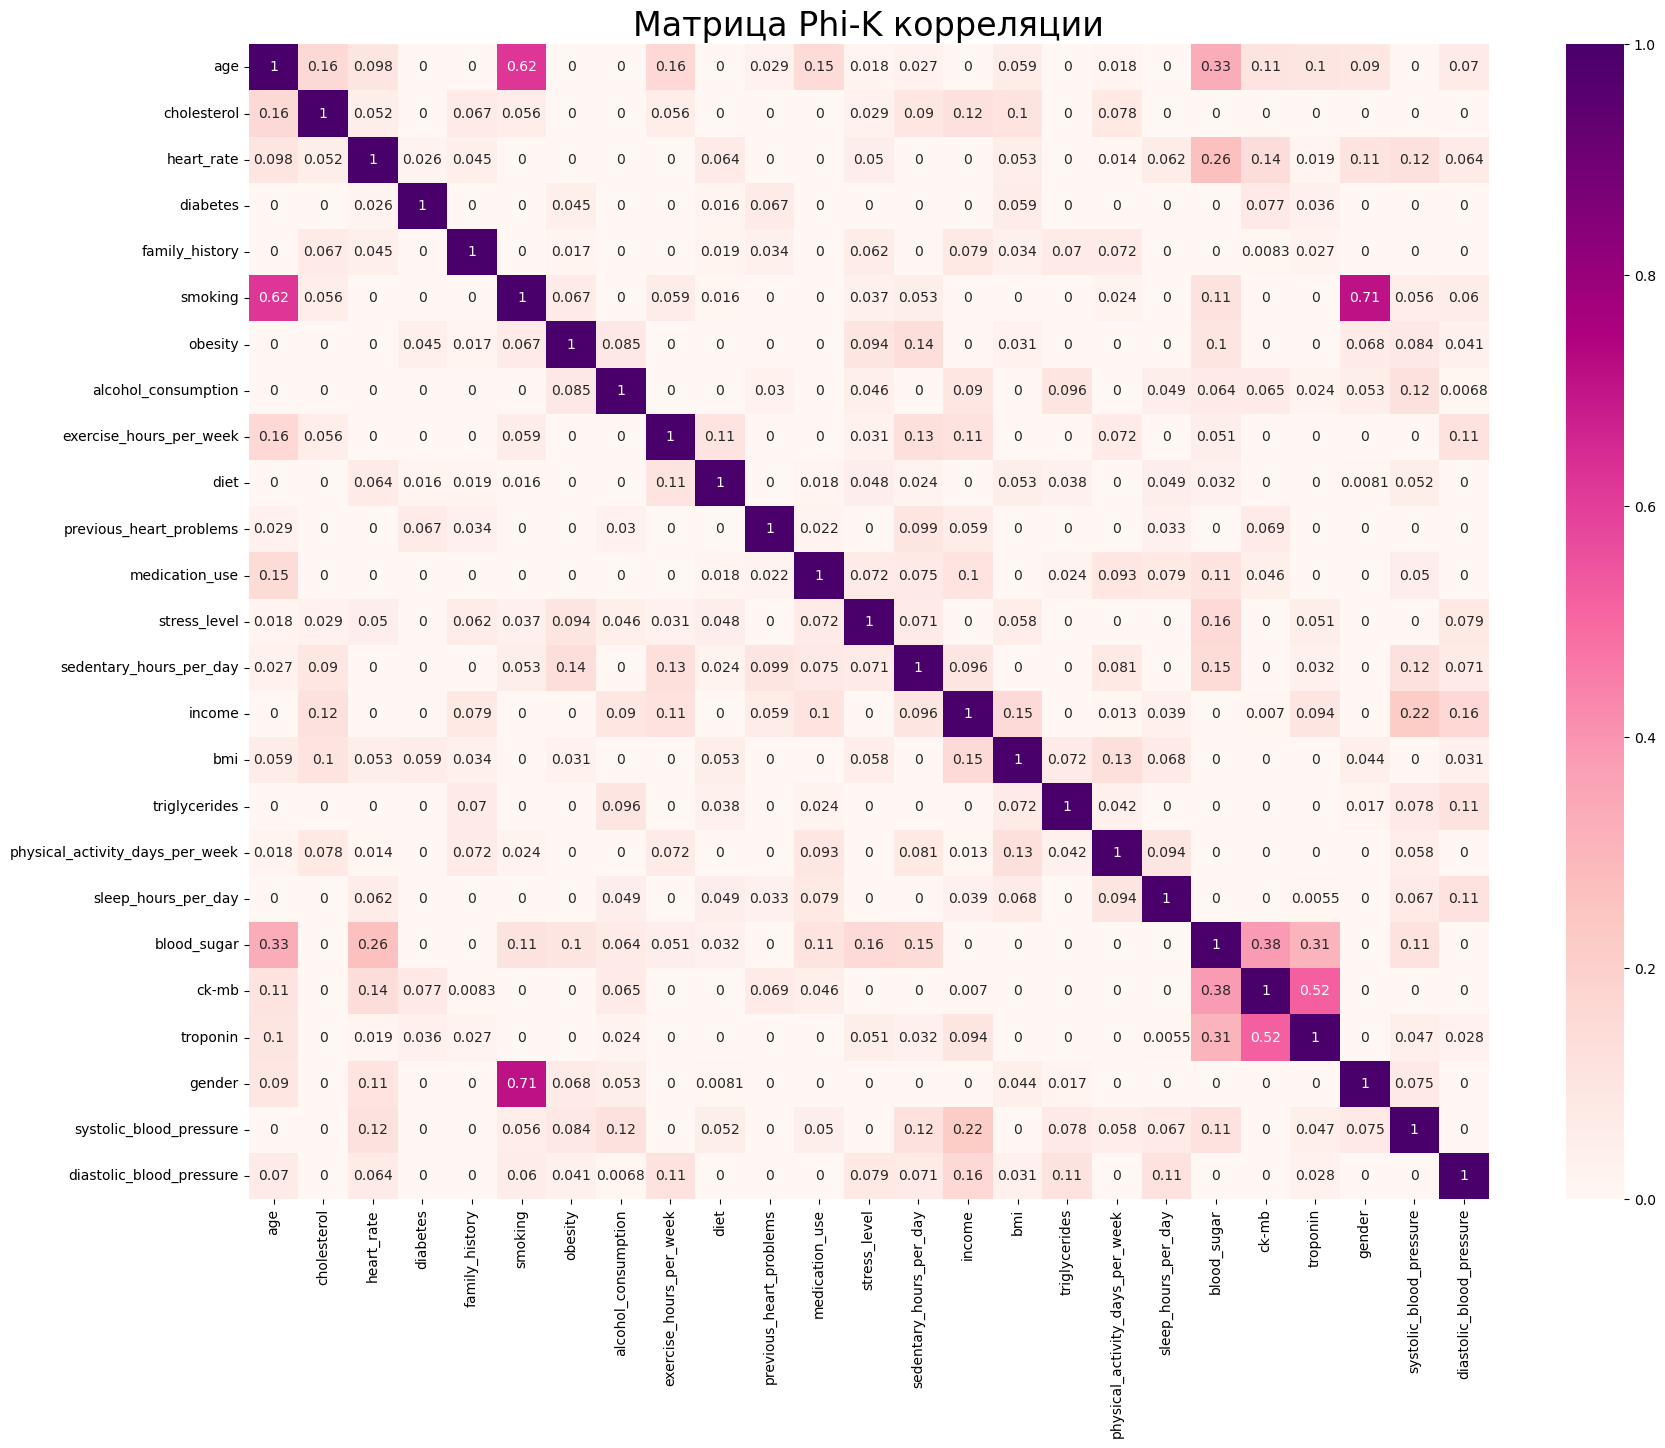

In [54]:
interval_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', \
'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']

plt.figure(figsize=(20,15))
sns.heatmap(heart_test_cl.drop(columns=['id'], axis=1).phik_matrix(interval_cols=interval_cols)                     
                                         , annot=True, cmap='RdPu')
plt.title('Матрица Phi-K корреляции', fontsize=24)
plt.show()

Корреляционная матрица показала взаимосвязь признаков `smoking` (Курение) и `gender` (Пол);  `smoking` (Курение) и `age` (Возраст).

В остальном мультиколинеарности между входными признаками не наблюдается.

Посмотрим, как распределены признаки в зависимости от значения целевого признака.

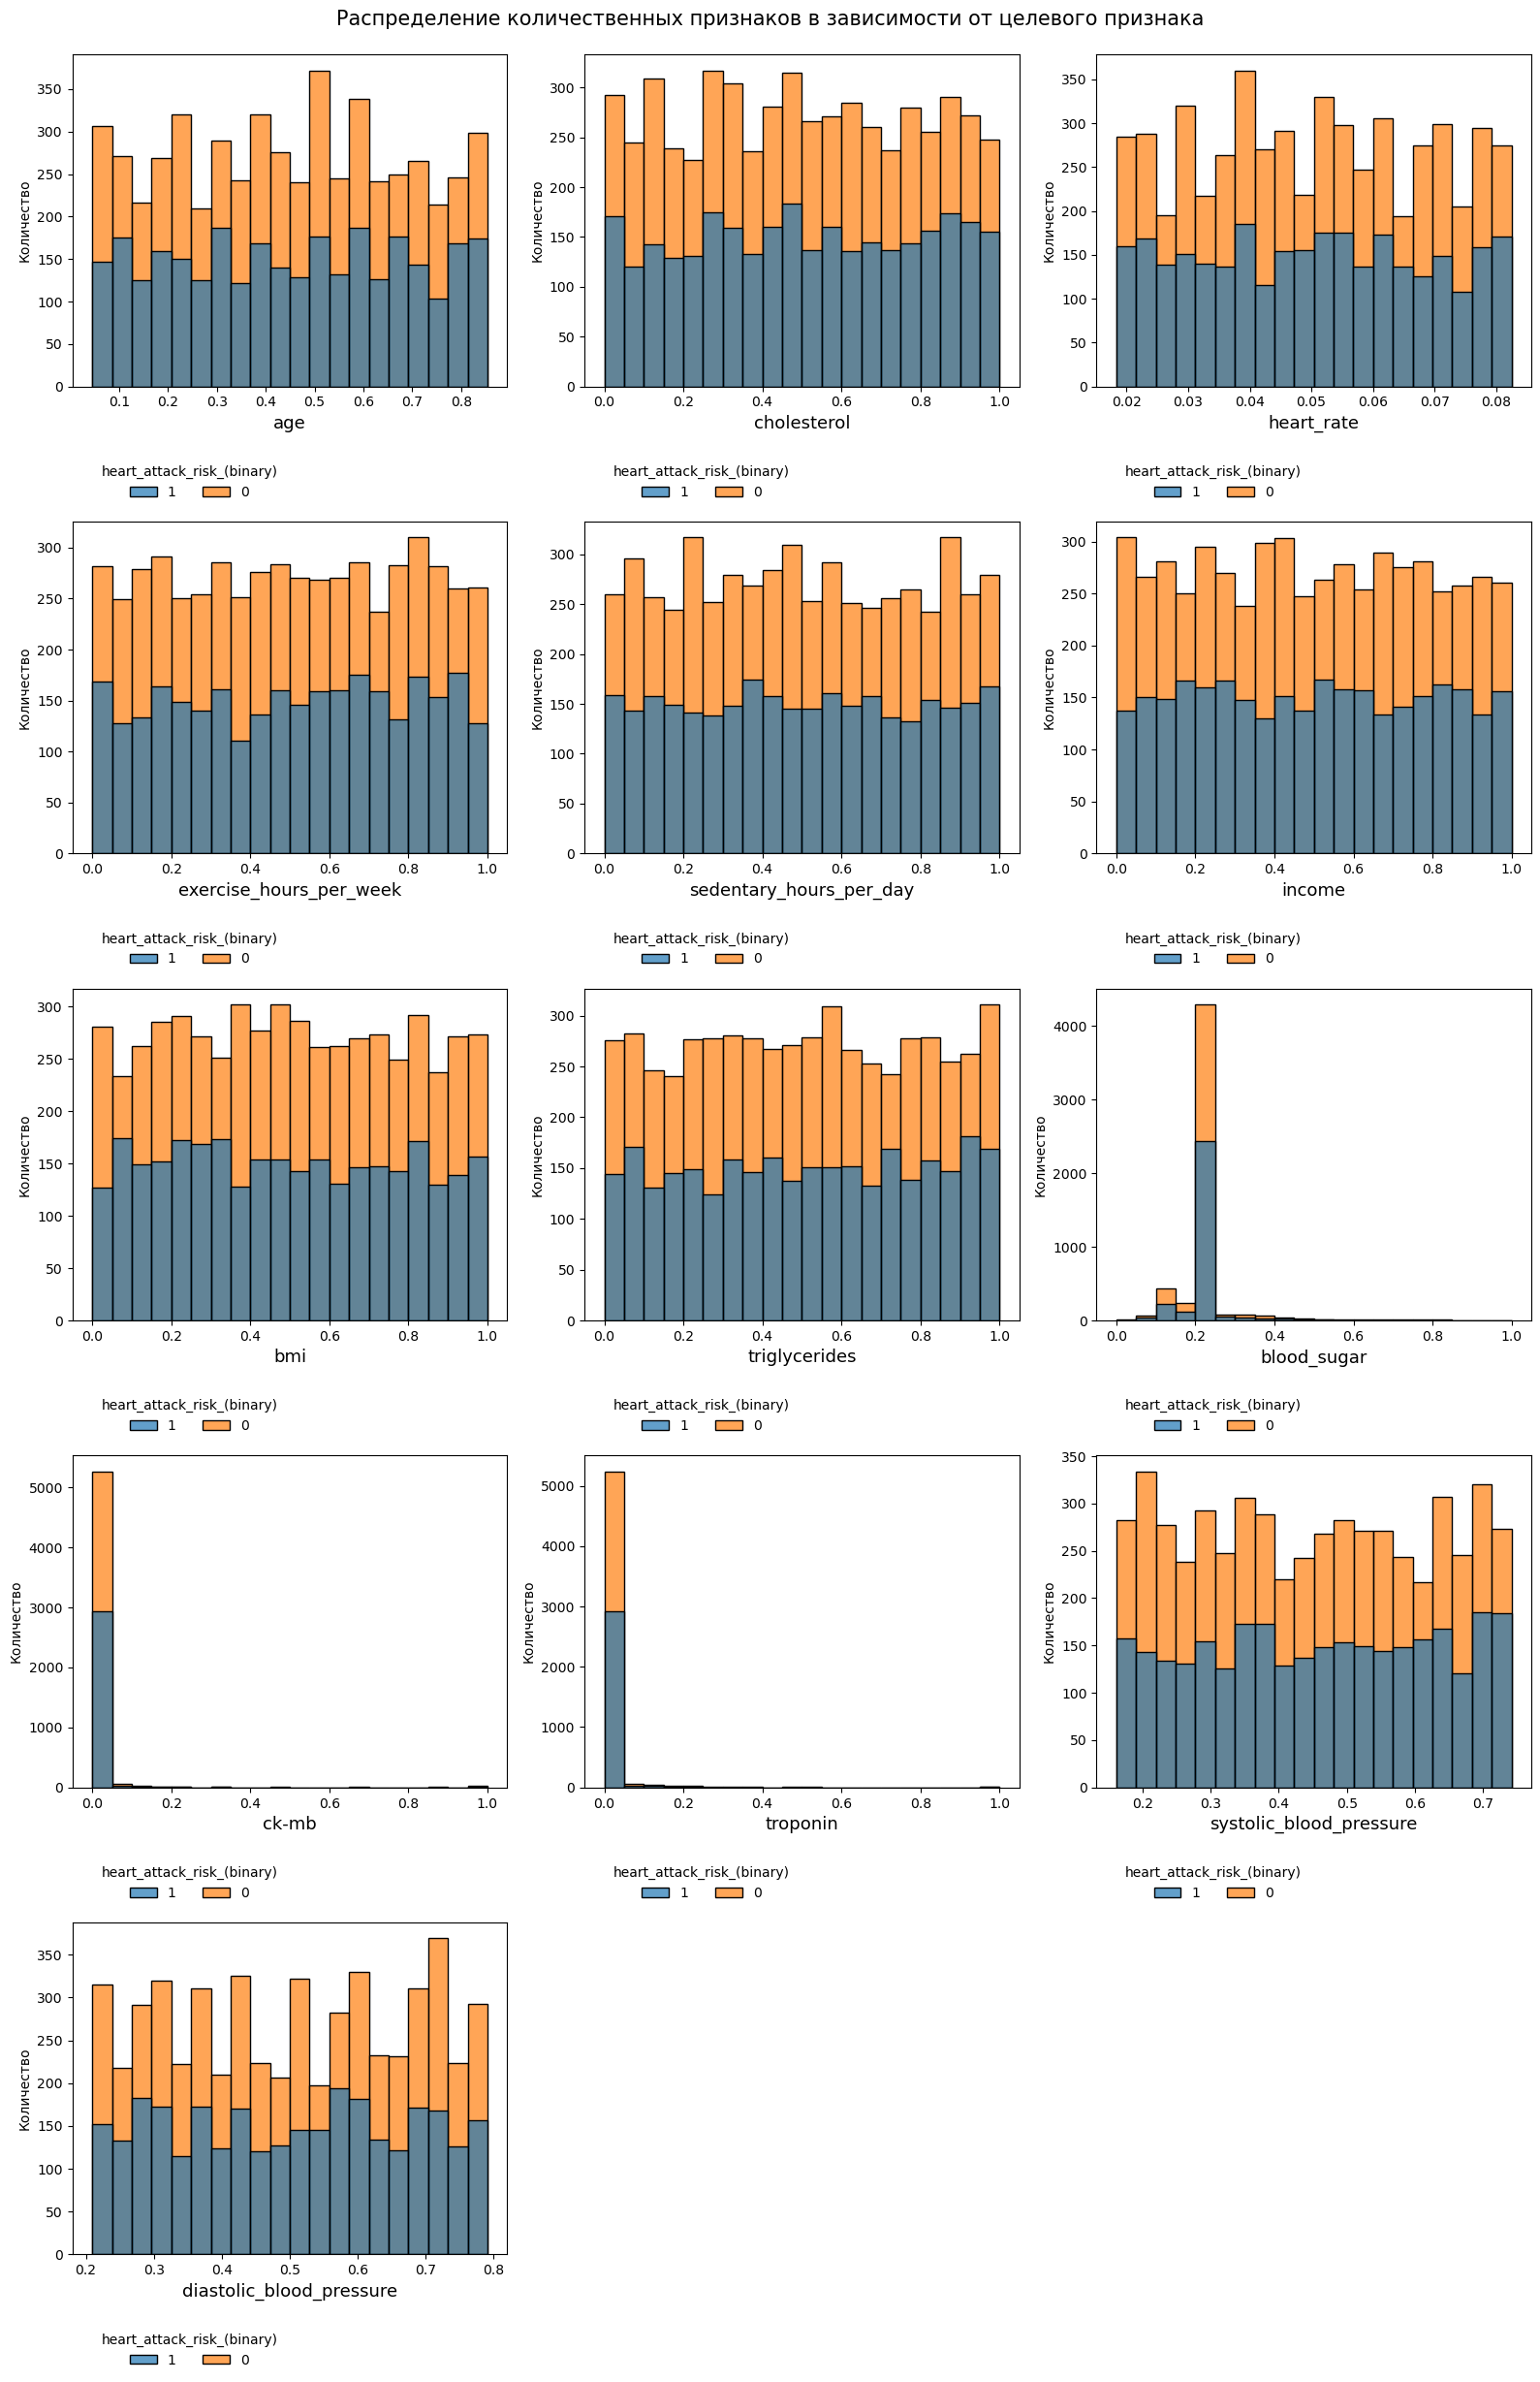

In [55]:
plt.figure(figsize=(16, 25))
for i, feature in enumerate(interval_cols, 1):
    plt.subplot(5, 3, i)
    ax=sns.histplot(data=heart_train_cl, x=feature, bins=20, hue='heart_attack_risk_(binary)', hue_order=[1, 0], alpha=0.7)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Количество')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.suptitle('Распределение количественных признаков в зависимости от целевого признака\n\n', 
             fontsize=15)    
plt.tight_layout()    
plt.show()

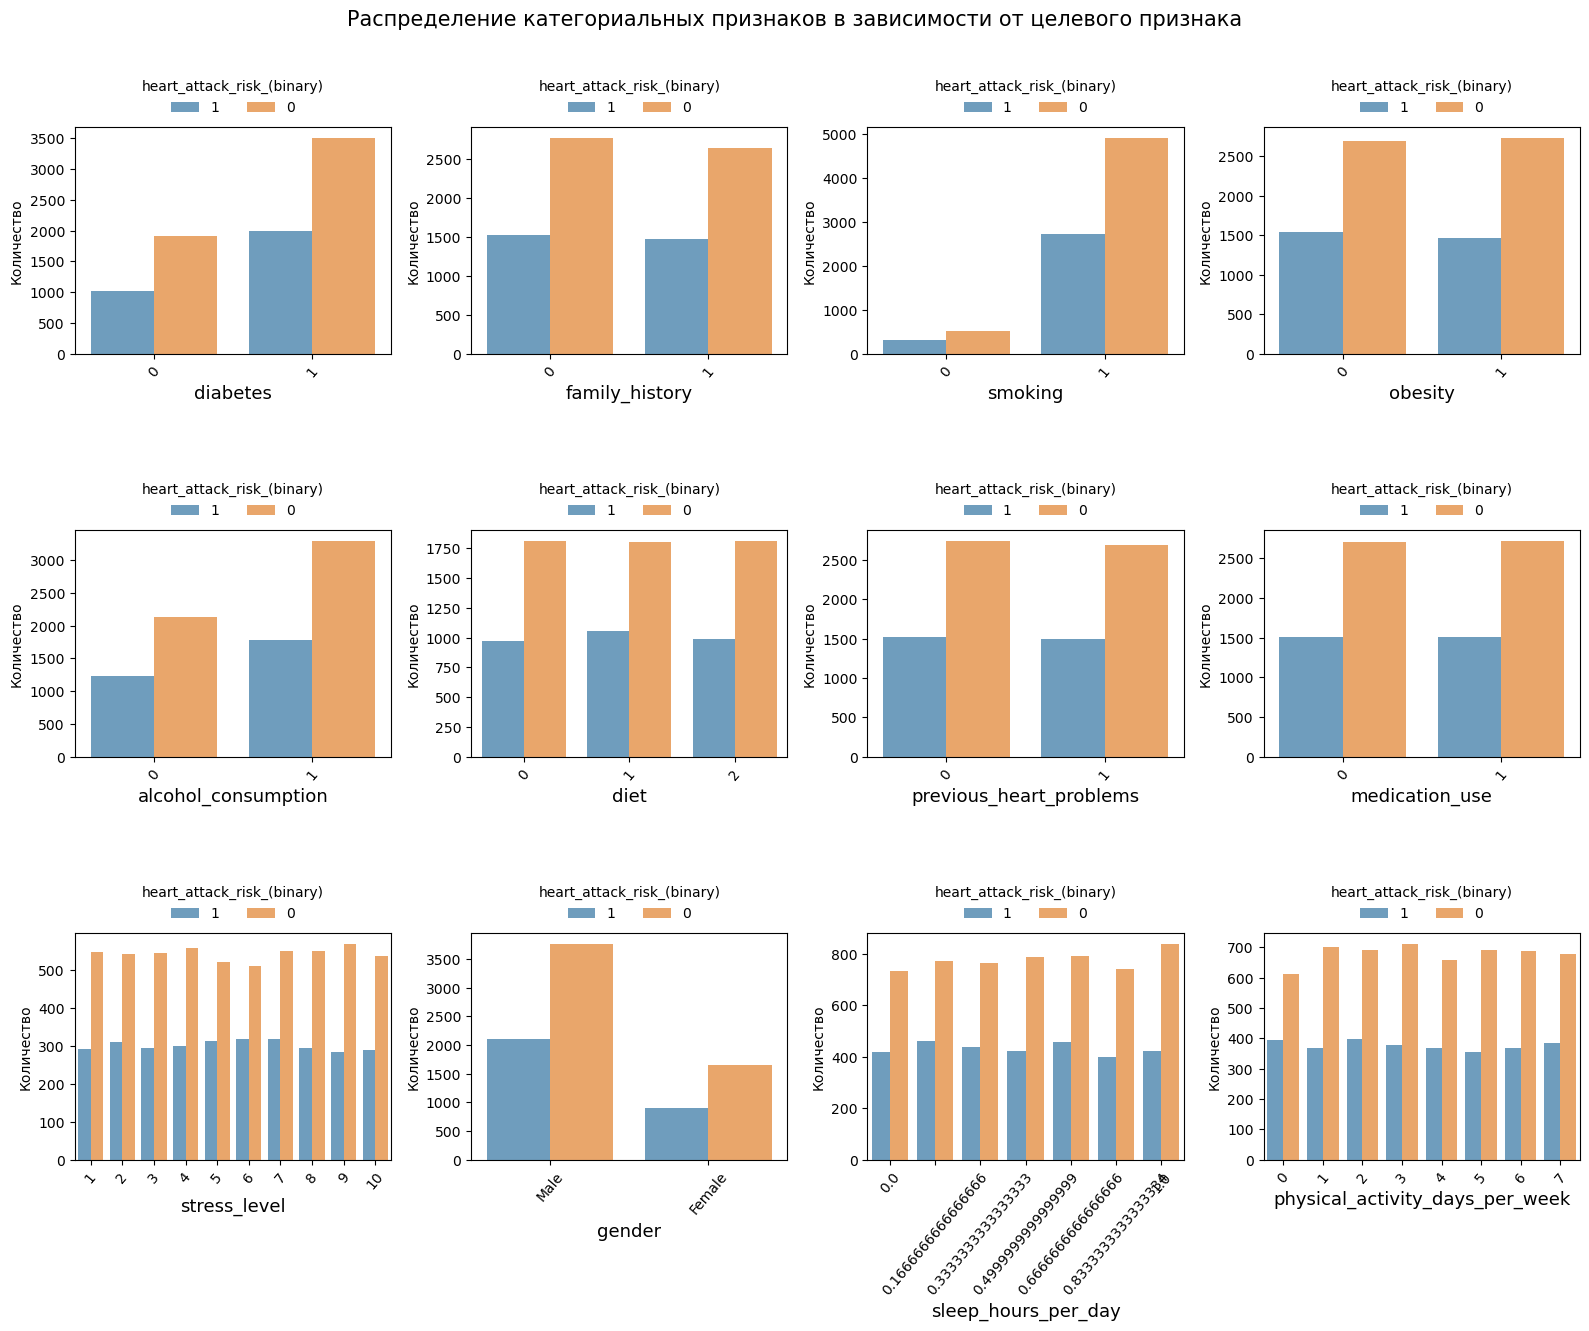

In [56]:
cat_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 
                 'stress_level', 'gender', 'sleep_hours_per_day', 'physical_activity_days_per_week']
plt.figure(figsize=(16, 16))
for i, feature in enumerate(cat_cols, 1):
    plt.subplot(4, 4, i)
    ax=sns.countplot(data=heart_train_cl, x=feature, hue='heart_attack_risk_(binary)', hue_order=[1, 0], alpha=0.7)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Количество')
    plt.xticks(rotation=50)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, frameon=False)

plt.suptitle('Распределение категориальных признаков в зависимости от целевого признака\n\n', 
             fontsize=15)    
plt.tight_layout()  
plt.show()

Здесь также не видно какой-то зависимости между таргетом и количественными признаками. По категориальным признакам: значений с классом 1 немного больше у пациентов с диабетом, курящих, употребляющих алкоголь и мужчин, но, при этом, и общее количество записей с этими значениями выше (т.е. пациентов с диабетом больше, чем без диабета; мужчин больше, чем женщин и т.д.).

### Вывод:  

Был проведен исследовательский анализ данных, в ходе которого были изучены количественные и категориальные признаки. По результатам можно отметить следующее:

Значения тренировочных и тестовых данных очень близки.
Практически у всех признаков (`age`, `cholesterol`, `heart_rate`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `sleep_hours_per_day`, `systolic_blood_pressure`, `diastolic_blood_pressure`) распределение равномерное, выбросы отсутствуют. Так как значения уже масштабированы, они лежат в диапазоне от 0 до 1. Только у признака `heart_rate` значения в 10 раз меньше и распределены в диапазоне от 0.02 до 0.08.
Данные у дискретных признаков `physical_activity_days_per_week` и `sleep_hours_per_day` также распределены равномерно, но только у `sleep_hours_per_day` значения масштабированы и лежат в диапазоне от 0 до 1, а у `physical_activity_days_per_week` значения исходные и находятся в диапазоне от 0 до 7.  
Признаки `ck-mb` и `troponin` - это показатели, повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск, т.е. налицо утечка целевого признака.  
Больше половины значений разницы между верхним(систолическим) и нижним(диастолическим) давлением отрицательные, что могло произойти после масштабирования, хотя не должно оказать значительного влияния на эффективность моделей.   
Есть дисбаланс классов (доля значений с наличием риска сердечного приступа почти в два раза меньше, чем с отсутствием риска сердечного приступа).
Также был проведен корреляционный анализ, который показал, что у целевого признака практически отсутсвуют корреляционные связи с любым из признаков.
Корреляционная матрица показала взаимосвязь признаков `smoking` (Курение) и `gender` (Пол);  `smoking` (Курение) и `age` (Возраст).
В остальном мультиколинеарности между входными признаками не наблюдается.

Не видно какой-либо зависимости между таргетом и количественными признаками. По категориальным признакам: значений с классом 1 немного больше у пациентов с диабетом, курящих, употребляющих алкоголь и мужчин, но, при этом, и общее количество записей с этими значениями выше (т.е. пациентов с диабетом больше, чем без диабета; мужчин больше, чем женщин и т.д.).

## 4. Обучение моделей и выбор лучшей модели и ее параметров

Для начала сделаем `id` индексами, закодируем признак 'gender' (1 - мужской пол, 0 - женский), приведем 'heart_rate' к диапазону от 0 до 1, поскольку он находится в диапазоне от 0.02 до 0.08, чтобы все признаки были в сопоставимых масштабах; удалим признаки 'ck-mb' и 'troponin' (утечка целевого признака), `income` - не особенно нужный признак для анализа по данной теме.   
Также, как уже отмечалось, `Exercise Hours Per Week` и `Physical Activity Days Per Week` связаны между собой, практически дублируют друг друга. Уберем один из них.   
Затем разобьем данные на тренировочную и тестовую выборки с учетом стратификации по целевому признаку, так как ранее мы выявили дисбаланс классов по нему.

In [57]:
hrt_train_cl = heart_train_cl.copy(deep=True)

In [58]:
hrt_train_cl['gender'] = heart_train_cl['gender'].map({'Male': 1, 'Female': 0})

In [59]:
hrt_train_cl = hrt_train_cl.set_index('id')

In [60]:
hrt_train_cl['heart_rate'] = hrt_train_cl['heart_rate'] * 10
hrt_train_cl = hrt_train_cl.drop(['ck-mb', 'troponin', 'income', 'physical_activity_days_per_week'], axis=1)
hrt_train_cl.head()

heart_attack_risk_(binary)       age  cholesterol  heart_rate  diabetes  \
id                                                                            
1                            0  0.595506     0.096429    0.476627         1   
2                            0  0.595506     0.189286    0.476627         0   
4                            0  0.078652     0.792857    0.714940         1   
5                            0  0.078652     0.771429    0.714940         1   
6                            1  0.078652     0.492857    0.714940         1   

    family_history  smoking  obesity  alcohol_consumption  \
id                                                          
1                1        1        1                    1   
2                0        1        0                    1   
4                0        1        1                    0   
5                1        1        0                    1   
6                0        1        0                    0   

    exercise_hours_per_week  diet  previous_heart_problems  medication_use  \
id                                                                           
1                  0.752420     1                        0               0   
2                  0.200998     2                        1               1   
4                  0.601030     2                        1               0   
5                  0.658864     2                        1               0   
6                  0.849607     1                        0               0   

    stress_level  sedentary_hours_per_day       bmi  triglycerides  \
id                                                                   
1              3                 0.710786  0.274469       0.276623   
2              9                 0.320478  0.890332       0.057143   
4              4                 0.315026  0.169495       0.768831   
5              2                 0.910628  0.394175       0.485714   
6              2                 0.583318  0.834293       0.407792   

    sleep_hours_per_day  blood_sugar  gender  systolic_blood_pressure  \
id                                                                      
1              0.666667     0.227018       1                 0.574194   
2              1.000000     0.227018       1                 0.187097   
4              0.166667     0.227018       1                 0.251613   
5              0.666667     0.227018       1                 0.735484   
6              1.000000     0.227018       1                 0.419355   

    diastolic_blood_pressure  
id                            
1                   0.569767  
2                   0.674419  
4                   0.383721  
5                   0.383721  
6                   0.720930

In [61]:
#hrt_test_cl = heart_test_cl.copy(deep=True)
#hrt_test_cl = hrt_test_cl.set_index('id')
#hrt_test_cl['gender'] = hrt_test_cl['gender'].map({'Male': 1, 'Female': 0})
#hrt_test_cl['heart_rate'] = hrt_test_cl['heart_rate'] * 10
#hrt_test_cl = hrt_test_cl.drop(['ck-mb', 'troponin'], axis=1)
#hrt_test_cl.head()

In [62]:
# Определяем целевой признак ('heart_attack_risk_(binary)') и входные признаки
X = hrt_train_cl.drop('heart_attack_risk_(binary)', axis=1)
y = hrt_train_cl['heart_attack_risk_(binary)']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (6331, 21)
Размер X_test: (2111, 21)
Размер y_train: (6331,)
Размер y_test: (2111,)


In [63]:
# Создадим итоговый пайплайн: поскольку подготовка данных уже была проведена, этого этапа в пайплайне не будет. Сразу модель
pipe = Pipeline([
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [64]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
        },
    
    # словарь для модели RandomForestClassifier() 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(150, 300),
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 3),
        'models__class_weight': ['balanced', 'balanced_subsample']          
    },
     
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='poly')],
        'models__C': [0.001, 0.01, 0.1, 1, 10],
        'models__gamma': ['scale', 'auto'],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },

    # CatBoostClassifier()
    {
        'model': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'model__iterations': [500, 2000],
        'model__depth': [10, 12],
        'model__auto_class_weights': ['Balanced', 'SqrtBalanced'],
        'model__learning_rate': [0.1, 0.3]
        #'scaler': [StandardScaler(), 'passthrough']
    }
]

In [65]:
# Поиск гиперпараметров с использованием RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


Для оценки качества моделей выбираем метрику ROC-AUC, поскольку ее имеет смысл использовать, когда объектов с одним значением целевого признака больше, чем с другими, что и имеет место в нашем случае, и можно получить оценку, устойчивую к дисбалансу.

In [66]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 10),
                                         'models__min_samples_split': range(2, 10)},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__class_weight': ['balanced',
                                                                  'bal...
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': [0.001, 0.01, 0.1, 1, 10],
                                         'models__gamma': ['scale', 'auto']},
                                        {'model': [<catboost.core.CatBoostClassifier object at 0x0000021AA0D69400>],
                                         'model__auto_class_weights': ['Balanced',
                                                                       'SqrtBalanced'],
                                         'model__depth': [10, 12],
                                         'model__iterations': [500, 2000],
                                         'model__learning_rate': [0.1, 0.3]}],
                   random_state=42, scoring='roc_auc')

In [67]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, min_samples_leaf=2,
                                        min_samples_split=3, n_estimators=177,
                                        random_state=42))])
Лучшие значения параметров: {'models__n_estimators': 177, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}
Лучшая метрика на кросс-валидации: 0.5697


In [68]:
(pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']])

rank_test_score  mean_test_score  \
3                1         0.569710   
2                2         0.569084   
1                3         0.568621   
7                4         0.568369   
4                5         0.561499   
8                6         0.558717   
9                7         0.549550   
5                8         0.547320   
0                9         0.546947   
6               10         0.545368   

                                                                                                                                                                                                                   params  \
3  {'models__n_estimators': 177, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
2  {'models__n_estimators': 212, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
1  {'models__n_estimators': 226, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
7  {'models__n_estimators': 170, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
4  {'models__n_estimators': 258, 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_depth': 15, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
8  {'models__n_estimators': 162, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
9  {'models__n_estimators': 230, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
5  {'models__n_estimators': 178, 'models__min_samples_split': 4, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}   
0            {'models__n_estimators': 196, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}   
6            {'models__n_estimators': 252, 'models__min_samples_split': 4, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}   

   mean_fit_time  
3       5.030735  
2       5.971438  
1       7.009257  
7       4.782614  
4       6.905739  
8       4.180411  
9       4.335011  
5       3.623114  
0       4.165665  
6       4.403643

In [69]:
print(f'Точность на тесте: {randomized_search.score(X_test, y_test):.4f}')

Точность на тесте: 0.5897


In [70]:
y_test_pred_rf = randomized_search.predict(X_test)
y_test_proba_rf = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_rf[:,1]), 4)}')


Метрика ROC-AUC на тестовой выборке: 0.5897


После комбинирования различных параметров лучше всего показала себя модель RandomForestClassifier со следующими гиперпараметрами: {'models__n_estimators': 177, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}

Лучшая модель показала метрику 0.5697 на тренировочной выборке и 0.5897 на тестовой выборке.

Метрика ROC-AUC на тестовой выборке: 0.5897
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      1358
           1       0.72      0.11      0.20       753

    accuracy                           0.67      2111
   macro avg       0.69      0.54      0.49      2111
weighted avg       0.69      0.67      0.58      2111



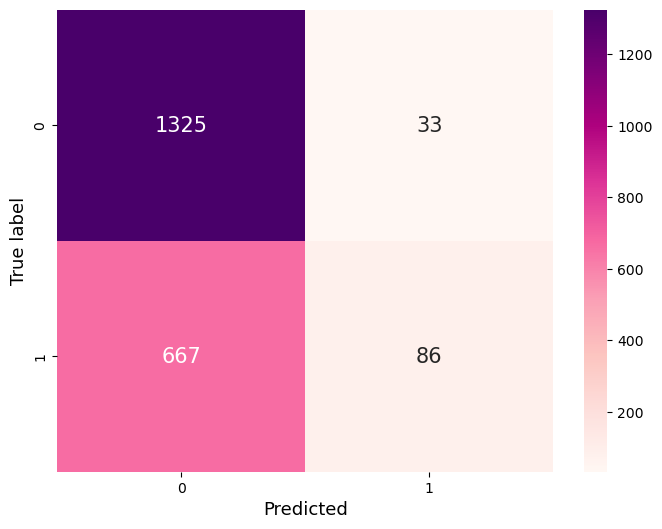

In [71]:
roc_auc_rf = round(roc_auc_score(y_test, y_test_proba_rf[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf:.4f}')

y_predict_rf = randomized_search.predict(X_test)
f1_rf = round(f1_score(y_test, y_predict_rf), 4)
print(classification_report(y_test, y_predict_rf))

cm_rf = confusion_matrix(y_test, y_predict_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

* TP = 86: в 86 случаях модель правильно отнесла наличие риска сердечного приступа к категории 1;
* FP = 33: в 33 случаях модель неправильно отнесла отсутствие риска сердечного приступа к категории '1' (ошибка 1го рода);
* FN = 667: в 667 случаях модель неправильно отнесла наличие риска сердечного приступа к категории ' 0' (ошибка 2го рода);
* TN = 1325: в 1325 случаях модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

Модель плохо предсказывает класс 1, в отличие от класса 0. Очень много ошибок 2-го рода, что опасно для пациентов.

Посмотрим отдельно CatBoostClassifier()

In [72]:
params_cb = {
    'iterations': randint(100, 1000),
    'depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': randint(1, 15),
    #'random_strength': uniform(0.5, 2),
    #'subsample': uniform(0.6, 0.4),  
    'min_data_in_leaf': randint(1, 20),
    #'max_ctr_complexity': randint(1, 4)
}


In [73]:
cb = CatBoostClassifier(random_state=RANDOM_STATE)

randomized_search_cb = RandomizedSearchCV(
    cb, 
    params_cb, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


In [74]:
randomized_search_cb.fit(X_train, y_train, verbose=False)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000021A9E367DA0>,
                   n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021A9E322E10>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021AA010CC80>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021A9BFC1160>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021A9C080CB0>,
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021A9F2FEF00>},
                   scoring='roc_auc')

In [75]:
print('Лучшая модель и её параметры:\n\n', randomized_search_cb.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search_cb.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search_cb.best_score_, 4))

Лучшая модель и её параметры:

Лучшие значения параметров: {'depth': 9, 'iterations': 233, 'l2_leaf_reg': 9, 'learning_rate': 0.17812379669984055, 'min_data_in_leaf': 19}
Лучшая метрика на кросс-валидации: 0.5604


In [76]:
print(f'Точность на тесте: {randomized_search_cb.score(X_test, y_test):.4f}')

Точность на тесте: 0.5863


In [77]:
y_test_pred_cb = randomized_search_cb.predict(X_test)
y_test_proba_cb = randomized_search_cb.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_cb[:,1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.5863


Метрика ROC-AUC на тестовой выборке: 0.5863
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      1358
           1       0.46      0.23      0.31       753

    accuracy                           0.63      2111
   macro avg       0.56      0.54      0.53      2111
weighted avg       0.59      0.63      0.59      2111



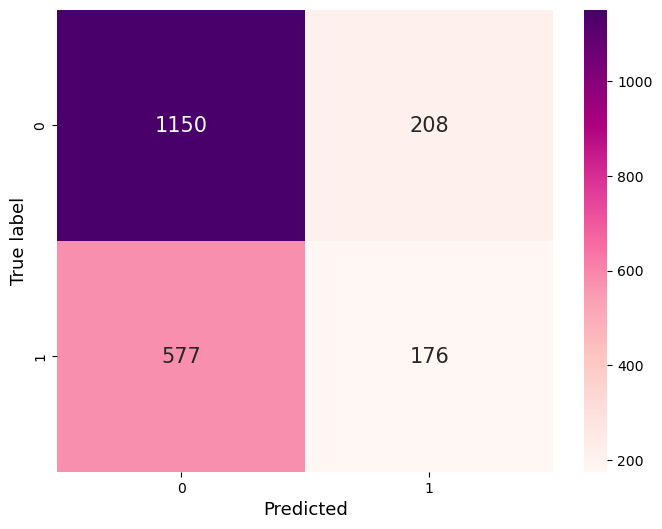

In [78]:
roc_auc_cb = round(roc_auc_score(y_test, y_test_proba_cb[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_cb:.4f}')

y_predict_cb = randomized_search_cb.predict(X_test)
f1_cb = round(f1_score(y_test, y_predict_cb), 4)
print(classification_report(y_test, y_predict_cb))

cm_cb = confusion_matrix(y_test, y_predict_cb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

* TP = 198: в 198 случаях модель правильно отнесла наличие риска сердечного приступа к категории 1;
* FP = 224: в 224 случаях модель неправильно отнесла отсутствие риска сердечного приступа к категории '1' (ошибка 1го рода);
* FN = 555: в 555 случаях модель неправильно отнесла наличие риска сердечного приступа к категории ' 0' (ошибка 2го рода);
* TN = 1134: в 1134 случаях модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

По-прежнем плохо предсказывается класс 1. Для обеих моделей результаты не очень хорошие.

In [79]:
results = pd.DataFrame(columns=['модель', 'f1', 'roc_auc', 'TP', 'FP', 'FN', 'TN'])
results.loc[0] = ['CatBoostClassifier', f1_cb, roc_auc_cb, 198, 224, 555, 1134]
results.loc[1] = ['RandomForestClassifier', f1_rf, roc_auc_rf, 86, 33, 667, 1325]
results

модель      f1  roc_auc   TP   FP   FN    TN
0      CatBoostClassifier  0.3096   0.5863  198  224  555  1134
1  RandomForestClassifier  0.1972   0.5897   86   33  667  1325

Попробуем применить RandomUnderSampler для обработки наших несбалансированных данных, чтобы убрать дисбаланс целевого признака.

In [87]:
# словари с гиперпараметрами для каждой модели
param_cb = {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': randint(100, 1000),
        'models__depth': randint(4, 12),
        'models__learning_rate': uniform(0.01, 0.3),
        'models__l2_leaf_reg': randint(1, 15),
        #'random_strength': uniform(0.5, 2),
        #'subsample': uniform(0.6, 0.4),  
        'models__min_data_in_leaf': randint(1, 20),
        #'max_ctr_complexity': randint(1, 4)
        #'models': [CatBoostClassifier(learning_rate=0.1, random_state=RANDOM_STATE, verbose=False)],
        #'models__iterations': [100, 800],
        #'models__depth': [10, 12]          
    }
param_rf = {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__n_estimators': range(150, 300),
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 3),
        'models__class_weight': ['balanced', 'balanced_subsample'] 
        #'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        #'models__n_estimators': [100, 200],
        #'models__max_depth': [10, 15, 20],
        #'models__class_weight': ['balanced', 'balanced_subsample'] 
    }


In [88]:
# Создание пайплайна с RandomUnderSampler для устранения дисбаланса
pipe_final = ImbPipeline([
('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
('models', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))
])

In [89]:
randomized_search_cb_imb = RandomizedSearchCV(
    pipe_final, 
    param_cb, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)

In [91]:
randomized_search_cb_imb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('models',
                                              <catboost.core.CatBoostClassifier object at 0x0000021AA0FDC560>)]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'models': [<catboost.core.CatBoostClassifier object at 0x0000021AA0CF7380>],
                                        'models__depth': <scipy.stats._distn_infrastructure.rv_discrete_fr...
                                        'models__l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021A9F3DA5A0>,
                                        'models__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021AA0D14770>,
                                        'models__min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021AA3E753A0>},
                   random_state=42, scoring='roc_auc')

In [92]:
print('Лучшая модель и её параметры:\n\n', randomized_search_cb_imb.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search_cb_imb.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search_cb_imb.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000021A97D0D8B0>)])
Лучшие значения параметров: {'models': <catboost.core.CatBoostClassifier object at 0x0000021AA0CF7380>, 'models__depth': 10, 'models__iterations': 535, 'models__l2_leaf_reg': 13, 'models__learning_rate': 0.06503043695984914, 'models__min_data_in_leaf': 8}
Лучшая метрика на кросс-валидации: 0.5433


In [93]:
print(f'Точность на тесте: {randomized_search_cb_imb.score(X_test, y_test):.4f}')

Точность на тесте: 0.5670


In [94]:
y_test_pred_cb_imb = randomized_search_cb_imb.predict(X_test)
y_test_proba_cb_imb = randomized_search_cb_imb.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_cb_imb[:,1]), 4)}')


Метрика ROC-AUC на тестовой выборке: 0.567


Метрика ROC-AUC на тестовой выборке: 0.5670
              precision    recall  f1-score   support

           0       0.67      0.52      0.58      1358
           1       0.38      0.54      0.44       753

    accuracy                           0.52      2111
   macro avg       0.52      0.53      0.51      2111
weighted avg       0.56      0.52      0.53      2111



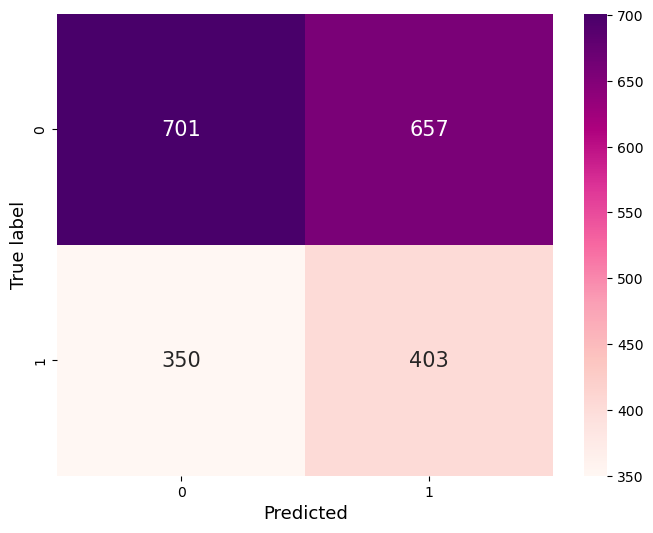

In [95]:
roc_auc_cb_imb = round(roc_auc_score(y_test, y_test_proba_cb_imb[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_cb_imb:.4f}')

y_predict_cb_imb = randomized_search_cb_imb.predict(X_test)
f1_cb_imb = round(f1_score(y_test, y_predict_cb_imb), 4)
print(classification_report(y_test, y_predict_cb_imb))

cm_cb_imb = confusion_matrix(y_test, y_predict_cb_imb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb_imb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Матрица ошибок 

* TP = 403: в 403 случаях модель правильно отнесла наличие риска сердечного приступа к категории 1;
* FP = 657: в 657 случаях модель неправильно отнесла отсутствие риска сердечного приступа к категории '1' (ошибка 1-го рода);
* FN = 350: в 350 случаях модель неправильно отнесла наличие риска сердечного приступа к категории ' 0' (ошибка 2-го рода);
* TN = 701: в 701 случае модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

Выросло ТР, также увеличилось и количество ошибок 1-го рода. В то же время снизились FN и TN.  
Стал лучше предсказываться 1 класс.

Метрика ROC-AUC немного понизилась.

In [96]:
randomized_search_rf_imb = RandomizedSearchCV(
    pipe_final, 
    param_rf, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [97]:
randomized_search_rf_imb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('models',
                                              <catboost.core.CatBoostClassifier object at 0x0000021AA0FDC560>)]),
                   n_jobs=-1,
                   param_distributions={'models': [RandomForestClassifier(random_state=42,
                                                                          verbose=False)],
                                        'models__class_weight': ['balanced',
                                                                 'balanced_subsample'],
                                        'models__max_depth': [10, 15, 20],
                                        'models__min_samples_leaf': range(1, 3),
                                        'models__min_samples_split': range(2, 5),
                                        'models__n_estimators': range(150, 300)},
                   random_state=42, scoring='roc_auc')

In [98]:
print('Лучшая модель и её параметры:\n\n', randomized_search_rf_imb.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search_rf_imb.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search_rf_imb.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, min_samples_leaf=2,
                                        min_samples_split=4, n_estimators=290,
                                        random_state=42, verbose=False))])
Лучшие значения параметров: {'models__n_estimators': 290, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42, verbose=False)}
Лучшая метрика на кросс-валидации: 0.5509


In [99]:
print(f'Точность на тесте: {randomized_search_rf_imb.score(X_test, y_test):.4f}')

Точность на тесте: 0.5689


In [100]:
y_test_pred_rf_imb = randomized_search_rf_imb.predict(X_test)
y_test_proba_rf_imb = randomized_search_rf_imb.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_rf_imb[:,1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.5689


Метрика ROC-AUC на тестовой выборке: 0.5689
              precision    recall  f1-score   support

           0       0.67      0.52      0.59      1358
           1       0.38      0.53      0.44       753

    accuracy                           0.53      2111
   macro avg       0.52      0.53      0.51      2111
weighted avg       0.57      0.53      0.54      2111



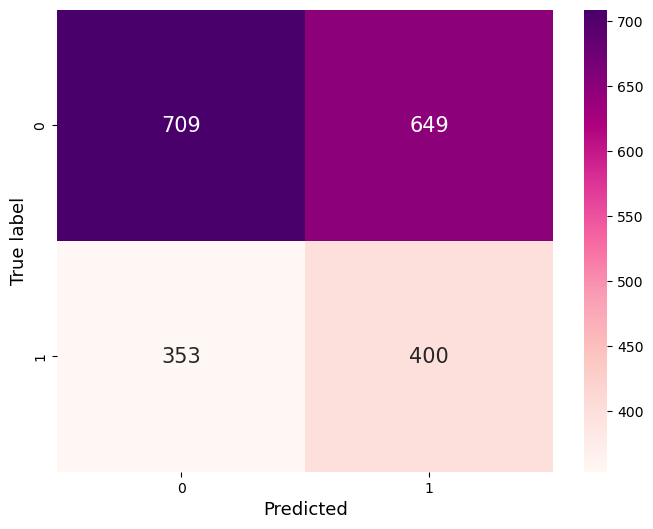

In [101]:
roc_auc_rf_imb = round(roc_auc_score(y_test, y_test_proba_rf_imb[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf_imb:.4f}')

y_predict_rf_imb = randomized_search_rf_imb.predict(X_test)
f1_rf_imb = round(f1_score(y_test, y_predict_rf_imb), 4)
print(classification_report(y_test, y_predict_rf_imb))

cm_rf_imb = confusion_matrix(y_test, y_predict_rf_imb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_imb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Показатели TP, FP, FN, TN очень схожи с предыдущим вариантом CatBoost.  
Метрика стала еще ниже.

In [102]:
results.loc[2] = ['CatBoost+Undersampler', f1_cb_imb, roc_auc_cb_imb, 403, 657, 350, 701]
results.loc[3] = ['RandomForest+Undersampler', f1_rf_imb, roc_auc_rf_imb, 400, 649, 353, 709]
results

модель      f1  roc_auc   TP   FP   FN    TN
0         CatBoostClassifier  0.3096   0.5863  198  224  555  1134
1     RandomForestClassifier  0.1972   0.5897   86   33  667  1325
2      CatBoost+Undersampler  0.4446   0.5670  403  657  350   701
3  RandomForest+Undersampler  0.4440   0.5689  400  649  353   709

**Подбор порога вероятности**


В нашем случае очень важны ошибки 2-го рода, так как предсказание отсутствия риска сердечного приступа, если риск на самом деле есть, может стоить жизни. При этом количество ошибочных предсказаний повышенного риска тому, у кого его нет (ошибки 1-го рода), тоже должно быть не слишком высоким.

Подберем порог вероятности, чтобы снизить ошибки 2-го рода и большему количеству значений присваивать 1 класс, и не слишком сильно увеличить ошибки 1-го рода.

In [103]:
def threshold_choice(thresholds, data):
    '''
    Функция для таблицы с  посчитанными метриками для каждого порога
    '''
    result_data = pd.DataFrame(columns=['порог', 'f1', 'precision', 'recall', 'количество_FN', 
                                        'количество_TP','число_предсказанных_объектов', 'всего_объектов_класса_1'])

    for i in thresholds:
        column_name = 'y_pred_' + str(i)
        f1 = round(f1_score(data['y_test'], data[column_name]), 3)
        precision = round(precision_score(data['y_test'], data[column_name]), 3)
        recall = round(recall_score(data['y_test'], data[column_name]), 3)
        # Число предсказанных объектов
        predicted_objects = data[column_name].sum()
        # Всего объектов класса 1
        total_objects_class_1 = data['y_test'].sum()
        # Количество ложноотрицательных предсказаний (FN)
        false_negatives = data.loc[(data[column_name] == 0) & (data['y_test'] == 1)].shape[0]
        # Количество истинноположительных предсказаний (TP)
        true_positives = data.loc[(data[column_name] == 1) & (data['y_test'] == 1)].shape[0]
        # Добавляем результаты в датафрейм
        new_row = pd.DataFrame({
            'порог': [i],
            'f1': [f1],
            'precision': [precision],
            'recall': [recall],
            'количество_FN': [false_negatives],
            'количество_TP': [true_positives],
            'число_предсказанных_объектов': [predicted_objects],
            'всего_объектов_класса_1': [total_objects_class_1],
        })
        
        result_data = pd.concat([result_data, new_row], ignore_index=True)

    return result_data
           

In [104]:
# для первого пайплайна, где лучшей моделью оказалась RandomForestClassifier
y_proba_rf = randomized_search.predict_proba(X_test)[:, 1]
data = pd.DataFrame(zip(y_test, y_proba_rf), 
                      columns = ['y_test', 'y_proba_rf']).sort_values(by='y_proba_rf', ascending=False)
thresholds = [round(i, 2) for i in np.linspace(0.35, 0.51, num=16, endpoint=False)]
columns = []
for i in thresholds:
    columns.append('y_pred_' + str(i))
    data['y_pred_' + str(i)] = data['y_proba_rf'].apply(lambda x: 1 if x >= i else 0)
data.head()   

y_test  y_proba_rf  y_pred_0.35  y_pred_0.36  y_pred_0.37  y_pred_0.38  \
1341       1    0.921994            1            1            1            1   
402        1    0.919052            1            1            1            1   
1768       1    0.828152            1            1            1            1   
1283       1    0.823089            1            1            1            1   
2020       1    0.776990            1            1            1            1   

      y_pred_0.39  y_pred_0.4  y_pred_0.41  y_pred_0.42  y_pred_0.43  \
1341            1           1            1            1            1   
402             1           1            1            1            1   
1768            1           1            1            1            1   
1283            1           1            1            1            1   
2020            1           1            1            1            1   

      y_pred_0.44  y_pred_0.45  y_pred_0.46  y_pred_0.47  y_pred_0.48  \
1341            1            1            1            1            1   
402             1            1            1            1            1   
1768            1            1            1            1            1   
1283            1            1            1            1            1   
2020            1            1            1            1            1   

      y_pred_0.49  y_pred_0.5  
1341            1           1  
402             1           1  
1768            1           1  
1283            1           1  
2020            1           1

In [105]:
threshold_df = threshold_choice(thresholds, data)
threshold_df

порог     f1  precision  recall количество_FN количество_TP  \
0    0.35  0.532      0.389   0.841           120           633   
1    0.36  0.517      0.386   0.782           164           589   
2    0.37  0.505      0.386   0.729           204           549   
3    0.38  0.488      0.385   0.668           250           503   
4    0.39  0.478      0.392   0.612           292           461   
5    0.40  0.459      0.401   0.537           349           404   
6    0.41  0.432      0.400   0.470           399           354   
7    0.42  0.415      0.415   0.414           441           312   
8    0.43  0.386      0.429   0.351           489           264   
9    0.44  0.359      0.455   0.296           530           223   
10   0.45  0.341      0.490   0.262           556           197   
11   0.46  0.307      0.508   0.220           587           166   
12   0.47  0.278      0.542   0.187           612           141   
13   0.48  0.260      0.637   0.163           630           123   
14   0.49  0.224      0.682   0.134           652           101   
15   0.50  0.197      0.723   0.114           667            86   

   число_предсказанных_объектов всего_объектов_класса_1  
0                          1628                     753  
1                          1526                     753  
2                          1423                     753  
3                          1308                     753  
4                          1177                     753  
5                          1008                     753  
6                           886                     753  
7                           751                     753  
8                           616                     753  
9                           490                     753  
10                          402                     753  
11                          327                     753  
12                          260                     753  
13                          193                     753  
14                          148                     753  
15                          119                     753

В нашем случае медицинской диагностики:
Ошибка 2-го рода (FN) - опаснее: сказали "здоров", а у человека реальный риск приступа
Ошибка 1-го рода (FP) - менее опасна: сказали "есть риск", а человек здоров 
Поэтому нам нужно снизить порог, чтобы:

- увеличить recall (поймать больше реальных случаев)
- уменьшить FN (меньше пропущенных больных)
- принять увеличение FP (больше "перестраховочных" диагнозов)

Остановимся на пороге 0.35.

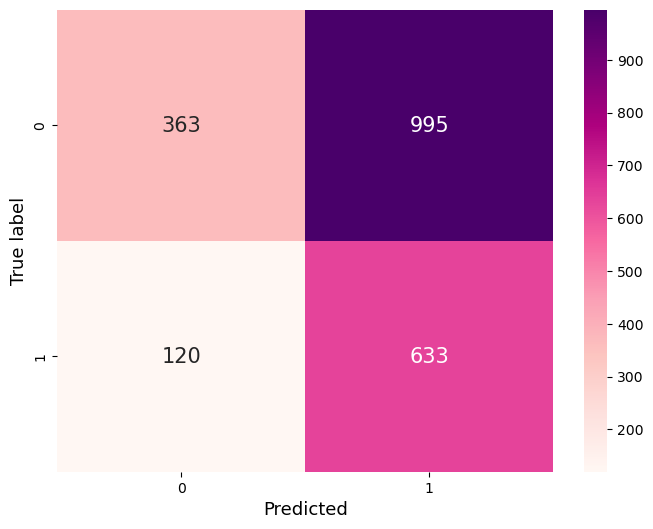

In [106]:
best_threshold = 0.35
y_pred_new_threshold = (randomized_search.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
f1_rf_4= round(f1_score(y_test, y_pred_new_threshold), 4) 

cm_4 = confusion_matrix(y_test, y_pred_new_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

In [107]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.75      0.27      0.39      1358
           1       0.39      0.84      0.53       753

    accuracy                           0.47      2111
   macro avg       0.57      0.55      0.46      2111
weighted avg       0.62      0.47      0.44      2111



In [108]:
results.loc[4] = ['RandomForest+ПодборПорога', f1_rf_4, roc_auc_rf, 633, 995, 120, 363]
results

модель      f1  roc_auc   TP   FP   FN    TN
0         CatBoostClassifier  0.3096   0.5863  198  224  555  1134
1     RandomForestClassifier  0.1972   0.5897   86   33  667  1325
2      CatBoost+Undersampler  0.4446   0.5670  403  657  350   701
3  RandomForest+Undersampler  0.4440   0.5689  400  649  353   709
4  RandomForest+ПодборПорога  0.5317   0.5897  633  995  120   363

In [109]:
# для CatBoostClassifier
y_proba_cb = randomized_search_cb.predict_proba(X_test)[:, 1]
data_cb = pd.DataFrame(zip(y_test, y_proba_cb), 
                      columns = ['y_test', 'y_proba_cb']).sort_values(by='y_proba_cb', ascending=False)
thresholds_cb = [round(i, 2) for i in np.linspace(0.35, 0.51, num=16, endpoint=False)]
columns = []
for i in thresholds_cb:
    columns.append('y_pred_' + str(i))
    data_cb['y_pred_' + str(i)] = data_cb['y_proba_cb'].apply(lambda x: 1 if x >= i else 0)
data_cb.head()   

y_test  y_proba_cb  y_pred_0.35  y_pred_0.36  y_pred_0.37  y_pred_0.38  \
979        1    0.975762            1            1            1            1   
2020       1    0.969092            1            1            1            1   
1123       1    0.964217            1            1            1            1   
402        1    0.959827            1            1            1            1   
1768       1    0.957372            1            1            1            1   

      y_pred_0.39  y_pred_0.4  y_pred_0.41  y_pred_0.42  y_pred_0.43  \
979             1           1            1            1            1   
2020            1           1            1            1            1   
1123            1           1            1            1            1   
402             1           1            1            1            1   
1768            1           1            1            1            1   

      y_pred_0.44  y_pred_0.45  y_pred_0.46  y_pred_0.47  y_pred_0.48  \
979             1            1            1            1            1   
2020            1            1            1            1            1   
1123            1            1            1            1            1   
402             1            1            1            1            1   
1768            1            1            1            1            1   

      y_pred_0.49  y_pred_0.5  
979             1           1  
2020            1           1  
1123            1           1  
402             1           1  
1768            1           1

In [110]:
threshold_df_cb = threshold_choice(thresholds_cb, data_cb)
threshold_df_cb

порог     f1  precision  recall количество_FN количество_TP  \
0    0.35  0.447      0.427   0.469           400           353   
1    0.36  0.432      0.424   0.441           421           332   
2    0.37  0.425      0.426   0.425           433           320   
3    0.38  0.414      0.424   0.405           448           305   
4    0.39  0.415      0.432   0.400           452           301   
5    0.40  0.409      0.435   0.386           462           291   
6    0.41  0.402      0.438   0.372           473           280   
7    0.42  0.388      0.435   0.351           489           264   
8    0.43  0.373      0.431   0.328           506           247   
9    0.44  0.358      0.427   0.308           521           232   
10   0.45  0.349      0.433   0.292           533           220   
11   0.46  0.343      0.439   0.282           541           212   
12   0.47  0.334      0.439   0.270           550           203   
13   0.48  0.333      0.454   0.263           555           198   
14   0.49  0.318      0.449   0.246           568           185   
15   0.50  0.310      0.458   0.234           577           176   

   число_предсказанных_объектов всего_объектов_класса_1  
0                           827                     753  
1                           783                     753  
2                           752                     753  
3                           720                     753  
4                           697                     753  
5                           669                     753  
6                           640                     753  
7                           607                     753  
8                           573                     753  
9                           543                     753  
10                          508                     753  
11                          483                     753  
12                          462                     753  
13                          436                     753  
14                          412                     753  
15                          384                     753

Тут получается не очень удачно. Не будем рассматривать этот вариант.

In [111]:
# для RandomForest+Undersampler
y_proba_rf_imb = randomized_search_rf_imb.predict_proba(X_test)[:, 1]
data_rf_imb = pd.DataFrame(zip(y_test, y_proba_rf_imb), 
                      columns = ['y_test', 'y_proba_rf_imb']).sort_values(by='y_proba_rf_imb', ascending=False)
thresholds_rf_imb = [round(i, 2) for i in np.linspace(0.35, 0.51, num=16, endpoint=False)]
columns = []
for i in thresholds_rf_imb:
    columns.append('y_pred_' + str(i))
    data_rf_imb['y_pred_' + str(i)] = data_rf_imb['y_proba_rf_imb'].apply(lambda x: 1 if x >= i else 0)
data_rf_imb.head() 

y_test  y_proba_rf_imb  y_pred_0.35  y_pred_0.36  y_pred_0.37  \
402        1        0.928346            1            1            1   
1341       1        0.921335            1            1            1   
1283       1        0.852808            1            1            1   
1768       1        0.837580            1            1            1   
1648       1        0.817970            1            1            1   

      y_pred_0.38  y_pred_0.39  y_pred_0.4  y_pred_0.41  y_pred_0.42  \
402             1            1           1            1            1   
1341            1            1           1            1            1   
1283            1            1           1            1            1   
1768            1            1           1            1            1   
1648            1            1           1            1            1   

      y_pred_0.43  y_pred_0.44  y_pred_0.45  y_pred_0.46  y_pred_0.47  \
402             1            1            1            1            1   
1341            1            1            1            1            1   
1283            1            1            1            1            1   
1768            1            1            1            1            1   
1648            1            1            1            1            1   

      y_pred_0.48  y_pred_0.49  y_pred_0.5  
402             1            1           1  
1341            1            1           1  
1283            1            1           1  
1768            1            1           1  
1648            1            1           1

In [112]:
threshold_df_rf_imb = threshold_choice(thresholds_rf_imb, data_rf_imb)
threshold_df_rf_imb

порог     f1  precision  recall количество_FN количество_TP  \
0    0.35  0.539      0.369   0.997             2           751   
1    0.36  0.540      0.370   0.997             2           751   
2    0.37  0.541      0.371   0.996             3           750   
3    0.38  0.542      0.373   0.992             6           747   
4    0.39  0.542      0.374   0.984            12           741   
5    0.40  0.542      0.376   0.973            20           733   
6    0.41  0.541      0.376   0.960            30           723   
7    0.42  0.542      0.380   0.946            41           712   
8    0.43  0.537      0.380   0.918            62           691   
9    0.44  0.528      0.378   0.876            93           660   
10   0.45  0.518      0.376   0.833           126           627   
11   0.46  0.510      0.379   0.780           166           587   
12   0.47  0.502      0.382   0.736           199           554   
13   0.48  0.486      0.381   0.669           249           504   
14   0.49  0.466      0.383   0.594           306           447   
15   0.50  0.444      0.381   0.531           353           400   

   число_предсказанных_объектов всего_объектов_класса_1  
0                          2035                     753  
1                          2029                     753  
2                          2021                     753  
3                          2004                     753  
4                          1981                     753  
5                          1951                     753  
6                          1922                     753  
7                          1874                     753  
8                          1820                     753  
9                          1747                     753  
10                         1667                     753  
11                         1547                     753  
12                         1452                     753  
13                         1323                     753  
14                         1166                     753  
15                         1049                     753

Выберем порог 0.38:  критически важный параметр Recall составляет 0.992 что означает, что мы пропускаем только 0.8% реальных случаев, или в абсолютном выражении - всего 6 человек из 753 (менее 1%).

Precision = 0.373 - из всех предсказанных "больных" 37% действительно больны.

Число предсказаний: 2004.

Соблюдается неплохой баланс между обнаружением и количеством дополнительных обследований.

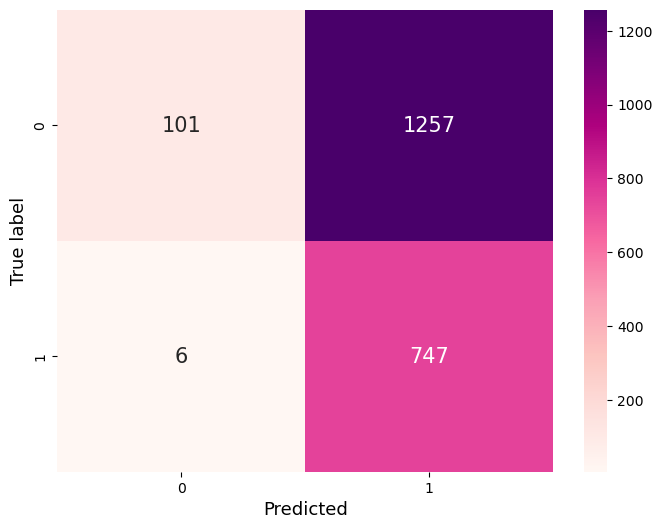

In [113]:
best_threshold_rf_imb = 0.38
y_pred_new_threshold_rf_imb = (randomized_search_rf_imb.predict_proba(X_test)[:, 1] >= best_threshold_rf_imb).astype(int)
f1_rf_imb= round(f1_score(y_test, y_pred_new_threshold_rf_imb), 4) 

cm_rf_imb = confusion_matrix(y_test, y_pred_new_threshold_rf_imb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_imb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

In [114]:
print(classification_report(y_test, y_pred_new_threshold_rf_imb))

              precision    recall  f1-score   support

           0       0.94      0.07      0.14      1358
           1       0.37      0.99      0.54       753

    accuracy                           0.40      2111
   macro avg       0.66      0.53      0.34      2111
weighted avg       0.74      0.40      0.28      2111



In [115]:
results.loc[5] = ['RandomForest+Undersampler+ПодборПорога', f1_rf_imb, roc_auc_rf_imb, 747, 1257, 6, 101]
results

модель      f1  roc_auc   TP    FP   FN  \
0                      CatBoostClassifier  0.3096   0.5863  198   224  555   
1                  RandomForestClassifier  0.1972   0.5897   86    33  667   
2                   CatBoost+Undersampler  0.4446   0.5670  403   657  350   
3               RandomForest+Undersampler  0.4440   0.5689  400   649  353   
4               RandomForest+ПодборПорога  0.5317   0.5897  633   995  120   
5  RandomForest+Undersampler+ПодборПорога  0.5419   0.5689  747  1257    6   

     TN  
0  1134  
1  1325  
2   701  
3   709  
4   363  
5   101

In [116]:
# для CatBoost+Undersampler
y_proba_cb_imb = randomized_search_cb_imb.predict_proba(X_test)[:, 1]
data_cb_imb = pd.DataFrame(zip(y_test, y_proba_cb_imb), 
                      columns = ['y_test', 'y_proba_cb_imb']).sort_values(by='y_proba_cb_imb', ascending=False)
thresholds_cb_imb = [round(i, 2) for i in np.linspace(0.35, 0.51, num=16, endpoint=False)]
columns = []
for i in thresholds_cb_imb:
    columns.append('y_pred_' + str(i))
    data_cb_imb['y_pred_' + str(i)] = data_cb_imb['y_proba_cb_imb'].apply(lambda x: 1 if x >= i else 0)
data_cb_imb.head()  

y_test  y_proba_cb_imb  y_pred_0.35  y_pred_0.36  y_pred_0.37  \
402        1        0.980611            1            1            1   
1768       1        0.977660            1            1            1   
1341       1        0.970656            1            1            1   
979        1        0.969449            1            1            1   
1123       1        0.967393            1            1            1   

      y_pred_0.38  y_pred_0.39  y_pred_0.4  y_pred_0.41  y_pred_0.42  \
402             1            1           1            1            1   
1768            1            1           1            1            1   
1341            1            1           1            1            1   
979             1            1           1            1            1   
1123            1            1           1            1            1   

      y_pred_0.43  y_pred_0.44  y_pred_0.45  y_pred_0.46  y_pred_0.47  \
402             1            1            1            1            1   
1768            1            1            1            1            1   
1341            1            1            1            1            1   
979             1            1            1            1            1   
1123            1            1            1            1            1   

      y_pred_0.48  y_pred_0.49  y_pred_0.5  
402             1            1           1  
1768            1            1           1  
1341            1            1           1  
979             1            1           1  
1123            1            1           1

In [117]:
threshold_df_cb_imb = threshold_choice(thresholds_cb_imb, data_cb_imb)
threshold_df_cb_imb

порог     f1  precision  recall количество_FN количество_TP  \
0    0.35  0.511      0.375   0.801           150           603   
1    0.36  0.512      0.378   0.792           157           596   
2    0.37  0.505      0.376   0.770           173           580   
3    0.38  0.501      0.375   0.752           187           566   
4    0.39  0.500      0.378   0.738           197           556   
5    0.40  0.495      0.377   0.718           212           541   
6    0.41  0.488      0.375   0.700           226           527   
7    0.42  0.481      0.373   0.680           241           512   
8    0.43  0.477      0.373   0.661           255           498   
9    0.44  0.473      0.374   0.644           268           485   
10   0.45  0.471      0.378   0.627           281           472   
11   0.46  0.470      0.381   0.614           291           462   
12   0.47  0.467      0.383   0.598           303           450   
13   0.48  0.455      0.379   0.571           323           430   
14   0.49  0.450      0.378   0.554           336           417   
15   0.50  0.445      0.380   0.535           350           403   

   число_предсказанных_объектов всего_объектов_класса_1  
0                          1607                     753  
1                          1575                     753  
2                          1543                     753  
3                          1508                     753  
4                          1472                     753  
5                          1435                     753  
6                          1405                     753  
7                          1374                     753  
8                          1336                     753  
9                          1297                     753  
10                         1250                     753  
11                         1212                     753  
12                         1175                     753  
13                         1136                     753  
14                         1102                     753  
15                         1060                     753

Выберем порог 0.35 - он дает максимальное обнаружение для этой модели.

Recall равняется 0.801.

Эта модель слабее предыдущей. Если использовать эту модель, она пропустит около 20% реальных случаев даже при оптимальном пороге.

Такая модель с recall 0.8, полагаю, недостаточно надежнаа для скрининга - слишком высок риск пропустить реальных больных.

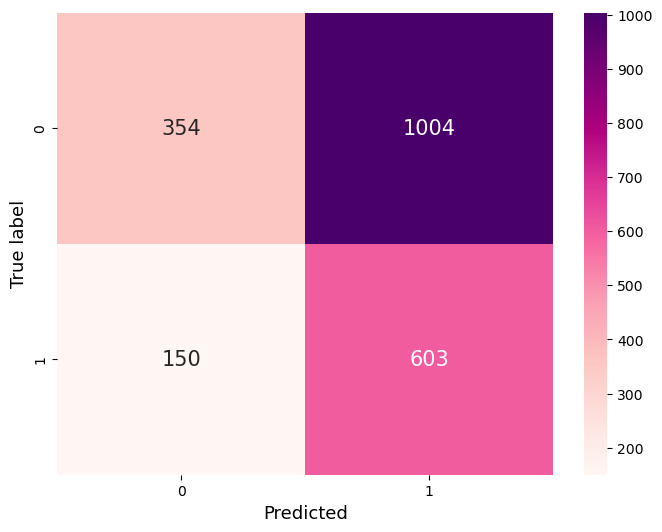

In [118]:
best_threshold_cb_imb = 0.35
y_pred_new_threshold_cb_imb = (randomized_search_cb_imb.predict_proba(X_test)[:, 1] >= best_threshold_cb_imb).astype(int)
f1_cb_imb= round(f1_score(y_test, y_pred_new_threshold_cb_imb), 4) 

cm_cb_imb = confusion_matrix(y_test, y_pred_new_threshold_cb_imb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb_imb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

In [119]:
results.loc[6] = ['CatBoost+Undersampler+ПодборПорога', f1_cb_imb, roc_auc_cb_imb, 603, 1004, 150, 354]
results

модель      f1  roc_auc   TP    FP   FN  \
0                      CatBoostClassifier  0.3096   0.5863  198   224  555   
1                  RandomForestClassifier  0.1972   0.5897   86    33  667   
2                   CatBoost+Undersampler  0.4446   0.5670  403   657  350   
3               RandomForest+Undersampler  0.4440   0.5689  400   649  353   
4               RandomForest+ПодборПорога  0.5317   0.5897  633   995  120   
5  RandomForest+Undersampler+ПодборПорога  0.5419   0.5689  747  1257    6   
6      CatBoost+Undersampler+ПодборПорога  0.5110   0.5670  603  1004  150   

     TN  
0  1134  
1  1325  
2   701  
3   709  
4   363  
5   101  
6   354

Возможности для предсказания не самые хорошие. Тем не менее, исходя из того, что есть выберем лучшую модель.

***Лучшей моделью будем считать:***  

* RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=290, random_state=42, verbose=False)  
  с применением RandomUnderSampler
* порог вероятности: 0.38.

Можно также рассмотреть RandomForest+ПодборПорога. У нее выше ROC-AUC. Тем не менее остановимся на упомянутой выше RandomForest+Undersampler+ПодборПорога.  

Ее преимущества:  

* обнаруживает на 114 больше реальных случаев (747 vs 633)

Практически не пропускает больных (всего 6 ошибок 2-го рода)

Более высокий F1-score (0.5419 vs 0.5317).

**Анализ важности признаков**

In [120]:
# Важность признаков из RandomForest
model = randomized_search_rf_imb.best_estimator_.named_steps['models']
feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

print("Топ-10 важных признаков:")
print(importance_df.head(10))


Топ-10 важных признаков:
                     Признак  Важность
8    exercise_hours_per_week  0.092773
14                       bmi  0.092342
13   sedentary_hours_per_day  0.091699
15             triglycerides  0.089253
1                cholesterol  0.086104
19   systolic_blood_pressure  0.080364
0                        age  0.080214
2                 heart_rate  0.078723
20  diastolic_blood_pressure  0.072907
12              stress_level  0.048389


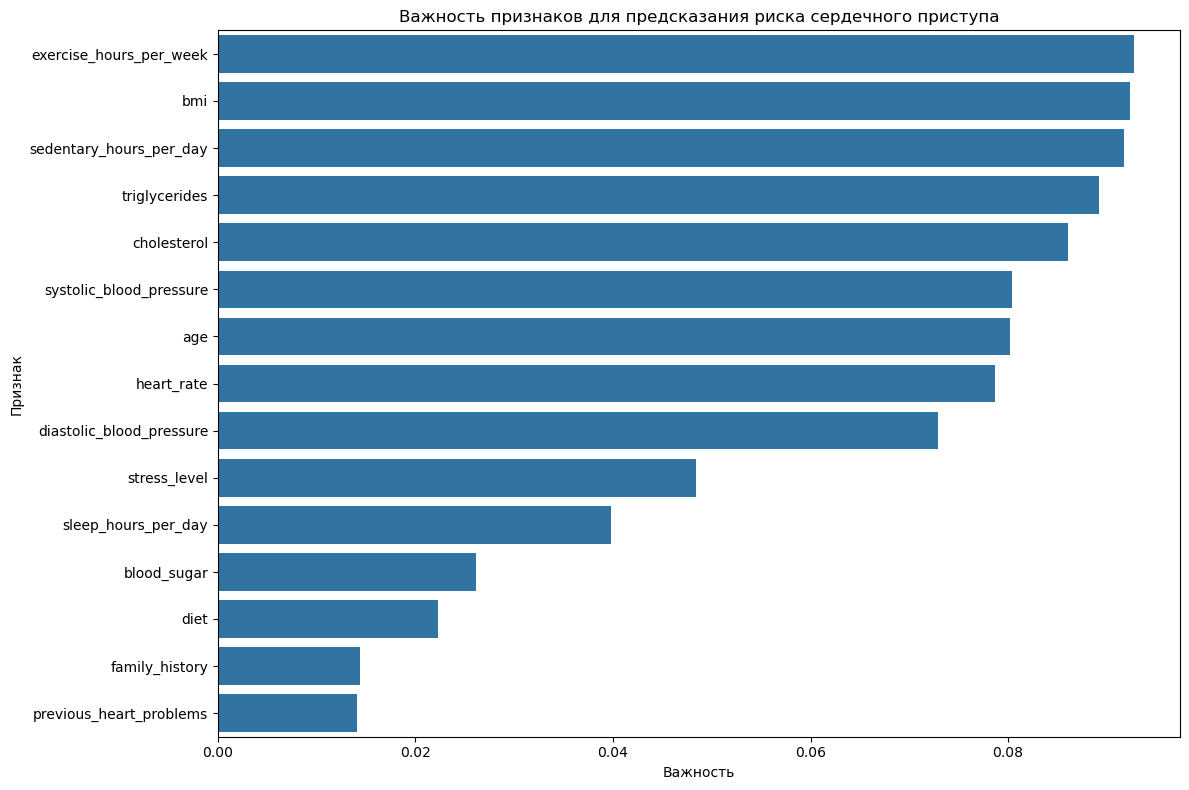

In [121]:
# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Признак', data=importance_df.head(15))
plt.title('Важность признаков для предсказания риска сердечного приступа')
plt.tight_layout()
plt.show()

Показаны наиболее важные с точки зрения модели признаки. Они связаны с образом жизни, антропометрическими, физиологическими, демографическими и медицинскими показателями.

Были выбраны, подготовлены и с помощью RandomizedSearch обучены модели CatBoostClassifier() и RandomForestClassifier() c разными гиперпараметрами.

Чтобы улучшить модель мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке) и удалили несколько ненужных признаков.

Также мы подообрали оптимальный порог вероятности, чтобы уменьшить количество ошибок 2-го рода (когда модель неправильно отнесла наличие риска сердечного приступа к категории '0').

В итоге, в качестве лучшей модели была выбрана:

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=290, random_state=42, verbose=False)
с применением RandomUnderSampler  
порог вероятности: 0.38.


## 5. Предсказания на тестовой выборке

In [122]:
heart_test_cl.head()

id       age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0   0  0.595506     0.314286    0.047663         0               0        1   
1   3  0.078652     0.960714    0.071494         1               1        1   
2  10  0.786517     0.375000    0.048579         1               1        1   
3  14  0.584270     0.935714    0.066911         0               1        1   
4  19  0.853933     0.160714    0.058662         0               1        1   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0        0                    0                 0.208326     0   
1        1                    1                 0.090557     2   
2        1                    1                 0.173545     1   
3        0                    1                 0.292691     1   
4        1                    0                 0.284116     2   

   previous_heart_problems  medication_use  stress_level  \
0                        0               0             9   
1                        1               0             1   
2                        0               0             4   
3                        1               1             4   
4                        0               1             3   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.551234  0.862268  0.602363       0.332468   
1                 0.413584  0.949316  0.417945       0.266234   
2                 0.572033  0.187454  0.146128       0.971429   
3                 0.495582  0.633684  0.596568       0.279221   
4                 0.910359  0.681431  0.447749       0.297403   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                                0             0.333333     0.227018   
1                                1             0.500000     0.227018   
2                                7             0.666667     0.227018   
3                                2             0.000000     0.227018   
4                                5             0.666667     0.227018   

      ck-mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512    Male                 0.600000   
1  0.048229  0.036512    Male                 0.645161   
2  0.048229  0.036512  Female                 0.593548   
3  0.048229  0.036512    Male                 0.690323   
4  0.048229  0.036512    Male                 0.625806   

   diastolic_blood_pressure  
0                  0.534884  
1                  0.593023  
2                  0.267442  
3                  0.360465  
4                  0.790698

**Подготовка данных для прогноза**

Сделаем `id` индексами, закодируем признак 'gender' (1 - мужской пол, 0 - женский), приведем 'heart_rate' к диапазону от 0 до 1, поскольку он находится в диапазоне от 0.02 до 0.08, чтобы все признаки были в сопоставимых масштабах; удалим признаки 'ck-mb' и 'troponin' (утечка целевого признака), `income` - не особенно нужный признак для анализа по данной теме.   
Также, как уже отмечалось, `Exercise Hours Per Week` и `Physical Activity Days Per Week` связаны между собой, практически дублируют друг друга. Уберем `Physical Activity Days Per Week`.   


In [123]:
hrt_test_cl = heart_test_cl.copy(deep=True)

In [124]:
hrt_test_cl['gender'] = heart_test_cl['gender'].map({'Male': 1, 'Female': 0})
hrt_test_cl = hrt_test_cl.set_index('id')
hrt_test_cl['heart_rate'] = hrt_test_cl['heart_rate'] * 10
hrt_test_cl = hrt_test_cl.drop(['ck-mb', 'troponin', 'income', 'physical_activity_days_per_week'], axis=1)
hrt_test_cl.head()

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
id                                                                         
0   0.595506     0.314286    0.476627         0               0        1   
3   0.078652     0.960714    0.714940         1               1        1   
10  0.786517     0.375000    0.485793         1               1        1   
14  0.584270     0.935714    0.669111         0               1        1   
19  0.853933     0.160714    0.586618         0               1        1   

    obesity  alcohol_consumption  exercise_hours_per_week  diet  \
id                                                                
0         0                    0                 0.208326     0   
3         1                    1                 0.090557     2   
10        1                    1                 0.173545     1   
14        0                    1                 0.292691     1   
19        1                    0                 0.284116     2   

    previous_heart_problems  medication_use  stress_level  \
id                                                          
0                         0               0             9   
3                         1               0             1   
10                        0               0             4   
14                        1               1             4   
19                        0               1             3   

    sedentary_hours_per_day       bmi  triglycerides  sleep_hours_per_day  \
id                                                                          
0                  0.551234  0.602363       0.332468             0.333333   
3                  0.413584  0.417945       0.266234             0.500000   
10                 0.572033  0.146128       0.971429             0.666667   
14                 0.495582  0.596568       0.279221             0.000000   
19                 0.910359  0.447749       0.297403             0.666667   

    blood_sugar  gender  systolic_blood_pressure  diastolic_blood_pressure  
id                                                                          
0      0.227018       1                 0.600000                  0.534884  
3      0.227018       1                 0.645161                  0.593023  
10     0.227018       0                 0.593548                  0.267442  
14     0.227018       1                 0.690323                  0.360465  
19     0.227018       1                 0.625806                  0.790698

In [125]:
hrt_test_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 9362
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       935 non-null    float64
 1   cholesterol               935 non-null    float64
 2   heart_rate                935 non-null    float64
 3   diabetes                  935 non-null    int32  
 4   family_history            935 non-null    int32  
 5   smoking                   935 non-null    int32  
 6   obesity                   935 non-null    int32  
 7   alcohol_consumption       935 non-null    int32  
 8   exercise_hours_per_week   935 non-null    float64
 9   diet                      935 non-null    int64  
 10  previous_heart_problems   935 non-null    int32  
 11  medication_use            935 non-null    int32  
 12  stress_level              935 non-null    int32  
 13  sedentary_hours_per_day   935 non-null    float64
 14  bmi           

In [127]:
hrt_test_cl.isna().sum()

age                         0
cholesterol                 0
heart_rate                  0
diabetes                    0
family_history              0
smoking                     0
obesity                     0
alcohol_consumption         0
exercise_hours_per_week     0
diet                        0
previous_heart_problems     0
medication_use              0
stress_level                0
sedentary_hours_per_day     0
bmi                         0
triglycerides               0
sleep_hours_per_day         0
blood_sugar                 0
gender                      0
systolic_blood_pressure     0
diastolic_blood_pressure    0
dtype: int64

In [128]:
hrt_test_cl.duplicated().sum()

0

In [129]:
hrt_test_cl['prediction'] = (randomized_search_rf_imb.predict_proba(hrt_test_cl)[:, 1] >= best_threshold_rf_imb).astype(int)

In [131]:
hrt_test_cl.sample(10)

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
id                                                                           
743   0.370787     0.003571    0.201650         0               1        1   
4301  0.550562     0.832143    0.641613         1               1        1   
3776  0.516854     0.767857    0.384968         1               0        1   
8099  0.191011     0.485714    0.650779         0               0        1   
4999  0.303371     0.896429    0.513291         0               1        1   
856   0.797753     0.914286    0.614115         1               0        1   
7910  0.404494     0.571429    0.540788         1               1        1   
5143  0.168539     0.617857    0.430797         1               0        1   
7908  0.404494     0.571429    0.540788         1               1        1   
7222  0.044944     0.417857    0.595784         0               1        0   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
id                                                                  
743         0                    0                 0.137213     1   
4301        1                    1                 0.105521     1   
3776        1                    0                 0.864516     1   
8099        0                    1                 0.800002     2   
4999        1                    1                 0.224217     0   
856         0                    1                 0.718790     1   
7910        0                    1                 0.069167     1   
5143        1                    0                 0.490275     0   
7908        0                    1                 0.069167     1   
7222        1                    1                 0.800009     0   

      previous_heart_problems  medication_use  stress_level  \
id                                                            
743                         1               1             9   
4301                        0               1             8   
3776                        1               1            10   
8099                        0               1             2   
4999                        1               1             8   
856                         1               1             9   
7910                        1               1             7   
5143                        0               1             5   
7908                        1               1             7   
7222                        1               0             2   

      sedentary_hours_per_day       bmi  triglycerides  sleep_hours_per_day  \
id                                                                            
743                  0.792639  0.886749       0.506494             0.333333   
4301                 0.033289  0.546646       0.387013             0.833333   
3776                 0.200695  0.630350       0.977922             0.000000   
8099                 0.181076  0.058748       0.193506             0.500000   
4999                 0.141202  0.854659       0.987013             0.166667   
856                  0.361286  0.784982       0.744156             0.000000   
7910                 0.312382  0.936693       0.390909             0.666667   
5143                 0.797546  0.887856       0.164935             0.833333   
7908                 0.312382  0.936693       0.390909             0.666667   
7222                 0.239277  0.002598       0.288312             0.500000   

      blood_sugar  gender  systolic_blood_pressure  diastolic_blood_pressure  \
id                                                                             
743      0.227018       0                 0.470968                  0.279070   
4301     0.114625       0                 0.664516                  0.581395   
3776     0.333992       0                 0.296774                  0.372093   
8099     0.227018       1                 0.180645                  0.267442   
4999     0.227018       1                 0.735484         

In [132]:
# предсказания по строкам, в которых не было пропусков во входных признаках
predictions = hrt_test_cl['prediction'].reset_index()
predictions

id  prediction
0       0           1
1       3           1
2      10           1
3      14           1
4      19           1
..    ...         ...
930  9338           1
931  9346           1
932  9348           1
933  9359           1
934  9362           0

[935 rows x 2 columns]

In [133]:
# предсказания по всем строкам (по тем строкам, где были пропуски предсказания заменены на -100)
predictions_f = pd.merge(heart_test, predictions, on='id', how='left')[['id', 'prediction']]
predictions_f = predictions_f.fillna(-100).astype(int)


In [135]:
predictions_f

id  prediction
0       0           1
1       3           1
2      10           1
3      14           1
4      19           1
..    ...         ...
961  9613        -100
962  9616        -100
963  9617        -100
964  9636        -100
965  9644        -100

[966 rows x 2 columns]

Рассмотрите использование предыдущей модели (где был recall 0.992) - она намного лучше для медицинской диагностикиРассмотрите использование предыдущей модели (где был recall 0.992) - она намного лучше для медицинской диагностики

In [136]:
# сохранение модели
with open('model.pickle', 'wb') as wf:
  pickle.dump(randomized_search_rf_imb, wf)

In [139]:
try:
    # Создаем папку
    os.makedirs('Predictions', exist_ok=True)
    
    # Проверяем и преобразуем данные
    if not isinstance(predictions, pd.DataFrame):
        predictions = pd.DataFrame(predictions, columns=['prediction'])
    if not isinstance(predictions_f, pd.DataFrame):
        predictions_f = pd.DataFrame(predictions_f)
    
    # Сохраняем без индекса
    predictions.to_csv('Predictions/predictions.csv', index=False)
    predictions_f.to_csv('Predictions/predictions_full.csv', index=False)
    
    # Проверяем, что файлы созданы
    if os.path.exists('Predictions/predictions.csv'):
        print("✓ predictions.csv успешно сохранен!")
    if os.path.exists('Predictions/predictions_full.csv'):
        print("✓ predictions_full.csv успешно сохранен!")
        
except Exception as e:
    print(f"Ошибка при сохранении: {e}")

✓ predictions.csv успешно сохранен!
✓ predictions_full.csv успешно сохранен!


## Общий вывод

Основной задачей проекта было разработать модель машинного обучения для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья, пр., подготовить предсказания на тестовой выборке, а также реализовать приложение на FastAPI для получения предсказаний по пользовательскому запросу.

В данном проекте проводилась работа с датасетами из открытого источника.

*Разработать модель машинного обучения для предсказания риска сердечного приступа, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.*

Для реализации задачи была проведена предварительная подготовка имеющихся наборов данных (поиск пропусков, явных и неявных дубликатов и т.д.), проведен исследовательский и корреляционный анализ данных.  

Необходимо отметить, что признаки `ck-mb` и `troponin` - это показатели, повышенный уровень которых является следствием инфаркта, а не фактором, увеличивающим риск, т.е. налицо утечка целевого признака. Данные признаки были удалены. Также удалили признак `income` - не особенно нужный признак для анализа по данной теме.
В то же время признаки `Exercise Hours Per Week` и `Physical Activity Days Per Week` связаны между собой, практически дублируют друг друга. Убрали один из них - `Physical Activity Days Per Week`.

В ходе исследования были разработаны и обучены модели: DecisionTreeClassifier(), SVC(), CatBoostClassifier() и RandomForestClassifier() c разными гиперпараметрами, а также проведен анализ важности признаков.  

На первом этапе остановились на моделях CatBoostClassifier() и RandomForestClassifier(). Затем чтобы улучшить модель мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке).

Также мы подобрали оптимальный порог вероятности, чтобы уменьшить количество ошибок 2-го рода (когда модель неправильно отнесла наличие риска сердечного приступа к категории '0')и постараться соблюсти лучший баланс между обнаружением и количеством дополнительных обследований, поскольку в медицинской диагностике лучше ошибиться в сторону перестраховки (ложные срабатывания), чем пропустить реальный случай.

В итоге, в качестве лучшей модели была выбрана:

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=290, random_state=42, verbose=False) с применением RandomUnderSampler

Наиболее важными с точки зрения модели признаками оказались следующие (в порядке уменьшения важности):
`exercise_hours_per_week`, `bmi`, `sedentary_hours_per_day`, `triglycerides`, `cholesterol`, `systolic_blood_pressure`, `age`, `heart_rate`, `diastolic_blood_pressure`. 

In [143]:
os.makedirs('models', exist_ok=True)
print("Папка models создана")

Папка models создана


In [144]:
joblib.dump(randomized_search_rf_imb, 'models/best_model.pkl')
joblib.dump(randomized_search_rf_imb, 'models/best_model.pkl')

['models/best_model.pkl']

In [145]:
# Сохраним порог в отдельный файл
joblib.dump(best_threshold_rf_imb, 'models/best_threshold.pkl')

print(f"✅ Порог сохранен: {best_threshold_rf_imb}")

✅ Порог сохранен: 0.38
